In [126]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff

import holidays

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler   # u otros scalers
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, LassoCV, RidgeCV, ElasticNetCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import KNNImputer #agregado
from sklearn.pipeline import Pipeline #agregado

In [2]:
### carga datos de dataset en dataframe
file_path= 'uber_fares.csv'

df = pd.read_csv(file_path)

In [3]:
### visualizacion de algunos datos
df.head()

,key,date,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5


#### Contexto  
El proyecto trata sobre **Uber Inc.**, la compañía de taxis más grande del mundo. En este trabajo, nuestro objetivo es **predecir la tarifa de futuros viajes**.  

Uber brinda servicio a millones de clientes cada día, por lo que gestionar adecuadamente sus datos es clave para desarrollar nuevas estrategias de negocio y obtener mejores resultados.  

### Variables del conjunto de datos  

**Variables explicativas:**  
- **key**: identificador único de cada viaje.  
- **pickup_datetime**: fecha y hora en que se inició el viaje.  
- **passenger_count**: cantidad de pasajeros en el vehículo (dato ingresado por el conductor).  
- **pickup_longitude**: longitud del punto de inicio del viaje.  
- **pickup_latitude**: latitud del punto de inicio del viaje.  
- **dropoff_longitude**: longitud del punto de destino.  
- **dropoff_latitude**: latitud del punto de destino.  

**Variable objetivo (target):**  
- **fare_amount**: costo del viaje en dólares.  

In [4]:
### Columnas, ¿cuáles son variables numéricas y cuales variables categóricas?
df.columns

Index(['key', 'date', 'fare_amount', 'pickup_datetime', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count'],
      dtype='object')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   key                200000 non-null  int64  
 1   date               200000 non-null  object 
 2   fare_amount        200000 non-null  float64
 3   pickup_datetime    200000 non-null  object 
 4   pickup_longitude   200000 non-null  float64
 5   pickup_latitude    200000 non-null  float64
 6   dropoff_longitude  199999 non-null  float64
 7   dropoff_latitude   199999 non-null  float64
 8   passenger_count    200000 non-null  int64  
dtypes: float64(5), int64(2), object(2)
memory usage: 13.7+ MB


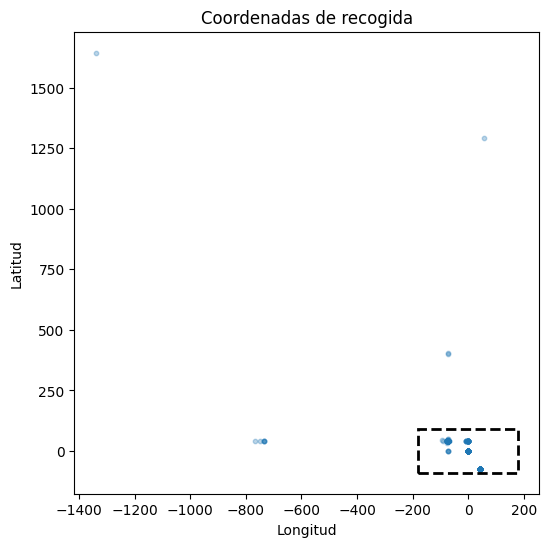

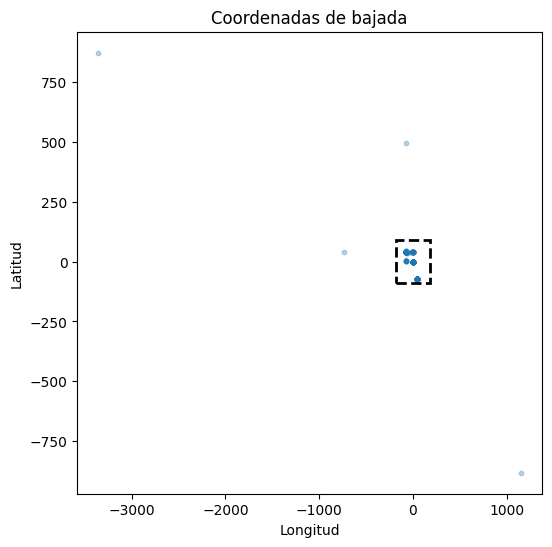

In [6]:
#Coordenadas de Pickup
plt.figure(figsize=(6,6))
plt.scatter(df["pickup_longitude"], df["pickup_latitude"], s=10, alpha=0.3)

world_rect = patches.Rectangle(
    (-180, -90),  
    360,          
    180,           
    linewidth=2, edgecolor='black', facecolor='none', linestyle='--'
)
plt.gca().add_patch(world_rect)

plt.xlabel("Longitud")
plt.ylabel("Latitud")
plt.title("Coordenadas de recogida")
plt.show()

#Coordenadas de Dropoff
plt.figure(figsize=(6,6))
plt.scatter(df["dropoff_longitude"], df["dropoff_latitude"], s=10, alpha=0.3)

world_rect = patches.Rectangle(
    (-180, -90),  
    360,          
    180,           
    linewidth=2, edgecolor='black', facecolor='none', linestyle='--'
)
plt.gca().add_patch(world_rect)

plt.xlabel("Longitud")
plt.ylabel("Latitud")
plt.title("Coordenadas de bajada")
plt.show()


***JUSTIFICACION DE POR QUE DROPEAMOS COORDENADAS INVALIDAS***

Primero validamos las coordenadas para evitar que valores inválidos generen distancias absurdas. Incluso dentro del rango [-90,90]/[-180,180]

In [7]:
#Coordenadas reales
lat_min, lat_max = -90, 90  
lon_min, lon_max = -180, 180

valid_pickup_lat = df["pickup_latitude"].between(lat_min, lat_max)
valid_pickup_lon = df["pickup_longitude"].between(lon_min, lon_max)
valid_dropoff_lat = df["dropoff_latitude"].between(lat_min, lat_max)
valid_dropoff_lon = df["dropoff_longitude"].between(lon_min, lon_max)

invalid_counts = (
    (~valid_pickup_lat).astype(int) +
    (~valid_pickup_lon).astype(int) +
    (~valid_dropoff_lat).astype(int) +
    (~valid_dropoff_lon).astype(int)
)

#Dropeamos filas con más de 1 coordenada inválida
df_filtrado = df[invalid_counts <= 1]


#Reemplazamos las coordenadas inválidas con NaN
df_filtrado.loc[~valid_pickup_lat, "pickup_latitude"] = np.nan
df_filtrado.loc[~valid_pickup_lon, "pickup_longitude"] = np.nan
df_filtrado.loc[~valid_dropoff_lat, "dropoff_latitude"] = np.nan
df_filtrado.loc[~valid_dropoff_lon, "dropoff_longitude"] = np.nan
df_filtrado.isna().sum()



 

key                  0
date                 0
fare_amount          0
pickup_datetime      0
pickup_longitude     6
pickup_latitude      2
dropoff_longitude    1
dropoff_latitude     1
passenger_count      0
dtype: int64

Cantidad de valores negativos en fare_amount: 22
Porcentaje de valores negativos sobre el total de registros en fare_amount: 0.011000165002475037%


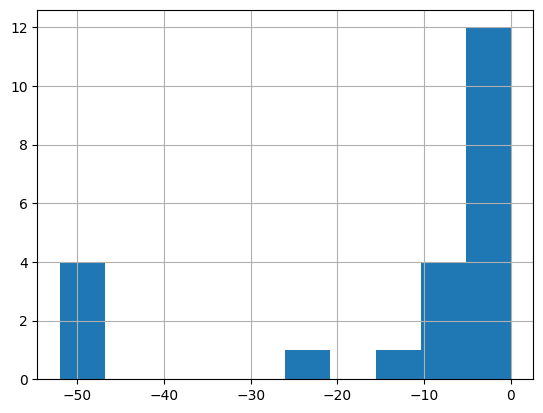

In [8]:
df_filtrado['fare_amount'].isnull().sum() #no hay nulos en fare_amount
df_filtrado[df_filtrado["fare_amount"] <= 0]["fare_amount"].hist()
negativos = df_filtrado[df_filtrado["fare_amount"] <= 0]['fare_amount'].size
print(f"Cantidad de valores negativos en fare_amount: {negativos}")
print(f"Porcentaje de valores negativos sobre el total de registros en fare_amount: {negativos / df_filtrado.fare_amount.size * 100}%")  # porcentaje de negativos en fare_amount
df_filtrado = df_filtrado[df_filtrado['fare_amount'] > 0]  # eliminamos los negativos y ceros


In [9]:
df_filtrado.shape

(199975, 9)

***AGREGAR JUSTIFICACION DE PORQUE BOLETEAMOS LOS NULOS***

<Axes: xlabel='distance_km'>

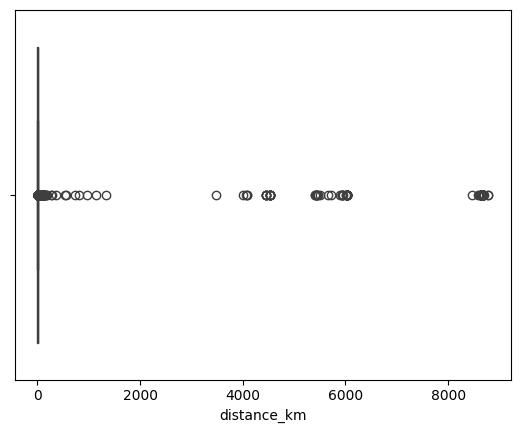

In [10]:
def haversine_km(lat1, lon1, lat2, lon2):
    # retorna distancia en kilómetros (vectorizado)
    R = 6371.0
    lat1, lon1, lat2, lon2 = map(np.radians, (lat1, lon1, lat2, lon2))
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c


df_filtrado['distance_km'] = haversine_km(
    df_filtrado['pickup_latitude'], df_filtrado['pickup_longitude'],
    df_filtrado['dropoff_latitude'], df_filtrado['dropoff_longitude']
)

df_filtrado['distance_km'].describe()
sns.boxplot(x=df_filtrado['distance_km'])



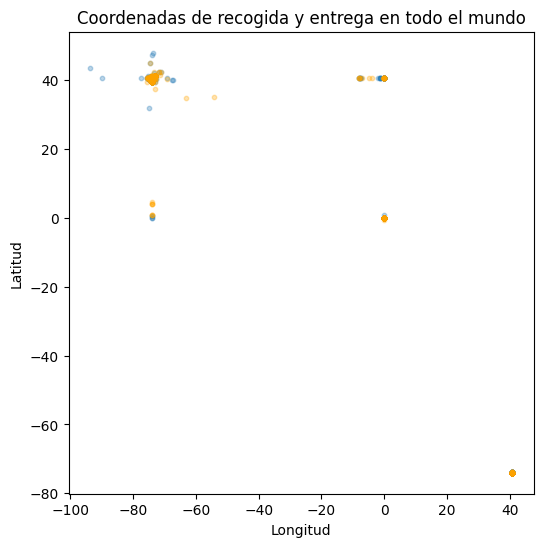

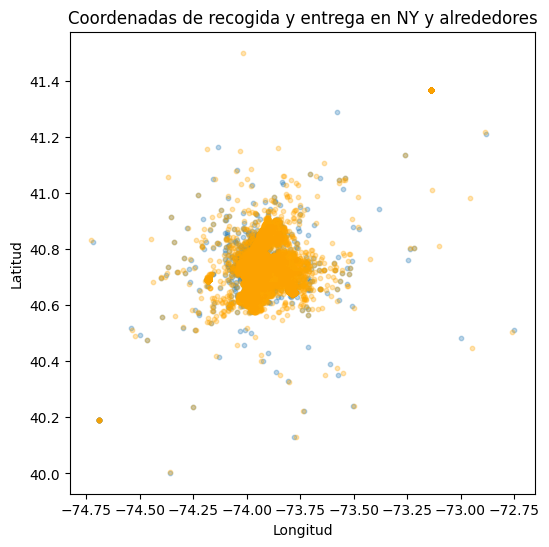

In [11]:
ny_coords = (
    (df_filtrado["pickup_latitude"].between(40, 42)| df_filtrado["pickup_latitude"].isna())&
    (df_filtrado["pickup_longitude"].between(-75, -72) | df_filtrado["pickup_longitude"].isna()) &
    (df_filtrado["dropoff_latitude"].between(40, 42) | df_filtrado["dropoff_latitude"].isna()) &
    (df_filtrado["dropoff_longitude"].between(-75, -72) | df_filtrado["dropoff_longitude"].isna())
)
df_filtrado_ny = df_filtrado[ny_coords].copy()
plt.figure(figsize=(6,6))
plt.scatter(df_filtrado["pickup_longitude"], df_filtrado["pickup_latitude"], s=10, alpha=0.3)
plt.scatter(df_filtrado["dropoff_longitude"], df_filtrado["dropoff_latitude"], s=10, alpha=0.3, color='orange')
plt.xlabel("Longitud")          
plt.ylabel("Latitud")
plt.title("Coordenadas de recogida y entrega en todo el mundo")      
plt.show()

plt.figure(figsize=(6,6))
plt.scatter(df_filtrado_ny["pickup_longitude"], df_filtrado_ny["pickup_latitude"], s=10, alpha=0.3)
plt.scatter(df_filtrado_ny["dropoff_longitude"], df_filtrado_ny["dropoff_latitude"], s=10, alpha=0.3, color='orange')
plt.xlabel("Longitud")          
plt.ylabel("Latitud")
plt.title("Coordenadas de recogida y entrega en NY y alrededores")      
plt.show()

In [12]:
df_filtrado_ny["pickup_datetime"] = pd.to_datetime(df["pickup_datetime"], errors="coerce", utc=True)

df_filtrado_ny["pickup_datetime"] = df_filtrado_ny["pickup_datetime"].dt.tz_convert("America/New_York")

us_holidays = holidays.US(years=df_filtrado_ny["pickup_datetime"].dt.year.unique(), state="NY")

df_filtrado_ny["is_holiday"] = df_filtrado_ny["pickup_datetime"].dt.date.isin(us_holidays).astype(int)


df_filtrado_ny["is_workday"] = (
    (df_filtrado_ny["pickup_datetime"].dt.dayofweek < 4) &  # lunes a jueves
    (~df_filtrado_ny["pickup_datetime"].dt.date.astype('datetime64[ns]').isin(us_holidays))  # feriado o fin de semana
).astype(int)

df_filtrado_ny[[ "is_holiday", "is_workday"]].value_counts()

# Extraer hora
df_filtrado_ny["hora_recogida"] = df_filtrado_ny["pickup_datetime"].dt.hour

df_filtrado_ny["mañana"] = (
    df_filtrado_ny["hora_recogida"].between(6, 11)
).astype(int)

df_filtrado_ny["tarde"] = (
    df_filtrado_ny["hora_recogida"].between(12, 19)
).astype(int)   

df_filtrado_ny["noche"] = (
    df_filtrado_ny["hora_recogida"].between(20, 23)
).astype(int)


df_modelo = df_filtrado_ny.drop(columns=["key", "hora_recogida", "pickup_datetime", "date"])

df_modelo["is_holiday"].value_counts()

C:\Users\Usuario\AppData\Local\Temp\ipykernel_8796\467827371.py:12: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  (~df_filtrado_ny["pickup_datetime"].dt.date.astype('datetime64[ns]').isin(us_holidays))  # feriado o fin de semana


is_holiday
0    190063
1      5734
Name: count, dtype: int64

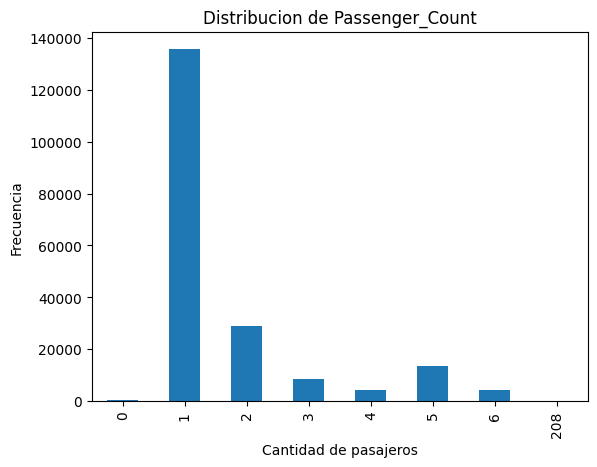

passenger_count
1      135491
2       28835
5       13722
3        8696
6        4184
4        4182
0         686
208         1
Name: count, dtype: int64

In [13]:
df_modelo["passenger_count"].value_counts().sort_index().plot(kind='bar')
plt.title("Distribucion de Passenger_Count")
plt.xlabel("Cantidad de pasajeros")
plt.ylabel("Frecuencia")
plt.show()
df_modelo["passenger_count"].value_counts()


In [14]:
### Creamos una nueva variable dummie con el tipo de viaje por pasajero 

df_modelo["uber_comun"] = df_modelo["passenger_count"].isin([1, 2, 3, 4]).astype(int)
df_modelo["uber_grande"] = df_modelo["passenger_count"].isin([5, 6]).astype(int)
#Convertimos el valor 208 en nulo 
df_modelo["passenger_count"] = df_modelo["passenger_count"].replace(208, np.nan)

Cantidad de viajes con distancia = 0: 2038

Estadísticas de fare_amount en viajes con distancia = 0:
count    2038.000000
mean       11.101305
std        14.647066
min         2.500000
25%         4.900000
50%         6.500000
75%        10.100000
max       200.000000
Name: fare_amount, dtype: float64


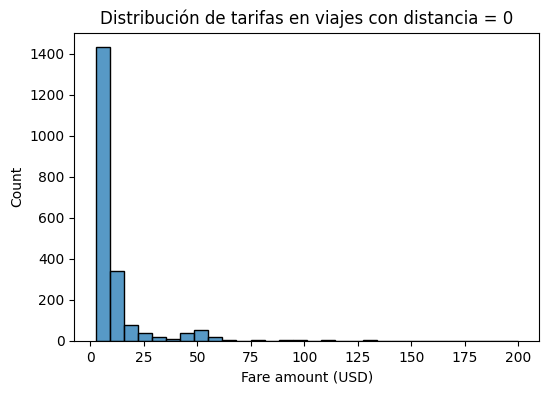

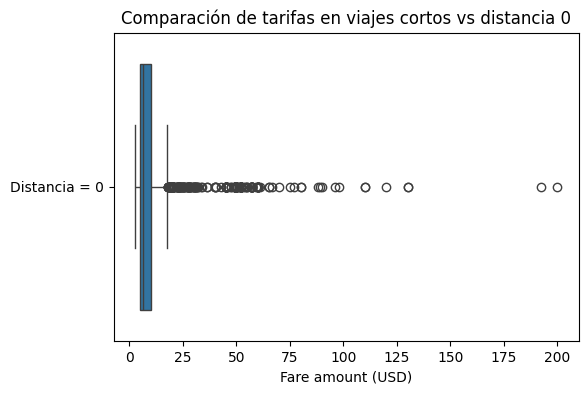

(1012,)

In [65]:
# 1. Contar cuántos viajes tienen distancia 0
zero_dist = df_modelo[df_modelo["distance_km"] == 0]
print("Cantidad de viajes con distancia = 0:", len(zero_dist))

# 2. Describir sus tarifas
print("\nEstadísticas de fare_amount en viajes con distancia = 0:")
print(zero_dist["fare_amount"].describe())

# 3. Histograma de esas tarifas
plt.figure(figsize=(6,4))
sns.histplot(zero_dist["fare_amount"], bins=30, kde=False)
plt.xlabel("Fare amount (USD)")
plt.title("Distribución de tarifas en viajes con distancia = 0")
plt.show()

plt.figure(figsize=(6,4))
sns.boxplot(
    data=[zero_dist["fare_amount"]],
    orient="h"
)
plt.yticks([0], ["Distancia = 0"])
plt.xlabel("Fare amount (USD)")
plt.title("Comparación de tarifas en viajes cortos vs distancia 0")
plt.show()

zero_dist[zero_dist["fare_amount"] > 6.5]["fare_amount"].shape


De 2000 registros con distancia 0, graficamos y analizamos el target de cada uno, seleccionando como "precio base" hasta 6.5 USD, para tomar como válidos los viajes con distancia 0 y darle una mínima referencia al modelo. Quedaron dropeados 1012 y 925 dentro del dataset.

In [66]:
X_train, X_test, y_train, y_test = train_test_split(df_modelo.drop(columns='fare_amount'), df_modelo['fare_amount'], test_size=0.2, random_state=42)


IMPUTACION DE VALORES FALTANTES EN COORDENADAS Y DISTANCIAS 
--------------------------------------------------------------

In [67]:
coords = ["pickup_latitude","pickup_longitude","dropoff_latitude","dropoff_longitude"]

invalidas = X_train[coords].isna().sum(axis=1)
filas_a_imputar = X_train[invalidas == 1].copy()


scaler = StandardScaler()
X_escaladas_train = scaler.fit_transform(filas_a_imputar[coords])

# 3️⃣ Imputación KNN en X_train
imputer = KNNImputer(n_neighbors=5)
X_imputadas_train = imputer.fit_transform(X_escaladas_train)

# 4️⃣ Volvemos a coordenadas originales en X_train
filas_a_imputar[coords] = scaler.inverse_transform(X_imputadas_train)

# 5️⃣ Reintegrar al X_train original
X_train.update(filas_a_imputar)

# 6️⃣ Imputación en X_test usando los mismos scaler e imputador
invalidas_test = X_test[coords].isna().sum(axis=1)
filas_a_imputar_test = X_test[invalidas_test == 1].copy()

# Escalar X_test con scaler ya ajustado
X_escaladas_test = scaler.transform(filas_a_imputar_test[coords])

# Imputar usando imputador ya ajustado
X_imputadas_test = imputer.transform(X_escaladas_test )

# Volvemos a coordenadas originales en X_test
filas_a_imputar_test[coords] = scaler.inverse_transform(X_imputadas_test)

# Reintegrar al X_test original
X_test.update(filas_a_imputar_test)



C:\Users\Usuario\AppData\Local\Temp\ipykernel_8796\2858692640.py:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0 0 0 ... 0 0 0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  X_train.update(filas_a_imputar)
C:\Users\Usuario\AppData\Local\Temp\ipykernel_8796\2858692640.py:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0 1 1 ... 1 0 0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  X_train.update(filas_a_imputar)
C:\Users\Usuario\AppData\Local\Temp\ipykernel_8796\2858692640.py:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0 0 0 ... 1 0 0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  X_train.update(filas_a_imputar)
C:\Users\Usuario\Ap

In [68]:
X_train['distance_km'] = haversine_km(
    X_train['pickup_latitude'], X_train['pickup_longitude'],
    X_train['dropoff_latitude'], X_train['dropoff_longitude']
)

X_test['distance_km'] = haversine_km(
    X_test['pickup_latitude'], X_test['pickup_longitude'],
    X_test['dropoff_latitude'], X_test['dropoff_longitude']
)
   

DROP DE COORDENADAS

In [69]:
##Dropeamos pickup_latitude y dropoff_latitude

X_train = X_train.drop(columns=['pickup_latitude', 'dropoff_latitude', 'pickup_longitude', 'dropoff_longitude'])
X_test  = X_test.drop(columns=['pickup_latitude', 'dropoff_latitude', 'pickup_longitude', 'dropoff_longitude'])

df_modelo = df_modelo.drop(columns=['pickup_latitude', 'dropoff_latitude', 'pickup_longitude', 'dropoff_longitude'])

IMPUTACION DE LOS VALORES DE FARE_AMOUNT DE LA DISTANCIA 0


In [ ]:
### IMPUTAMOS PASAJEROS POR LA MODA
# Encontrar la moda en el conjunto de entrenamiento
zero_dist_train = y_train[X_train["distance_km"] < 0.1]
# Encontrar la moda solo en train
moda_fare_train = zero_dist_train.mode()[0]
# Imputar en train y test usando la misma moda
y_train.loc[X_train["distance_km"] < 0.1] = moda_fare_train
y_test.loc[X_test["distance_km"] < 0.1] = moda_fare_train



IMPUTACION DE PASAJEROS POR LA MODA
-----------------------------------

In [71]:
##imputamos valor nulo de passenger_count por la moda
moda_passenger = X_train["passenger_count"].mode()[0]
X_train["passenger_count"].fillna(moda_passenger, inplace=True)
X_test["passenger_count"].fillna(moda_passenger, inplace=True)  


C:\Users\Usuario\AppData\Local\Temp\ipykernel_8796\3257366643.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_train["passenger_count"].fillna(moda_passenger, inplace=True)
C:\Users\Usuario\AppData\Local\Temp\ipykernel_8796\3257366643.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as

***AGREGAR JUSTIFICACION DE QUE VAMOS A HACER CON EL OUTLIER***
No eliminamos filas innecesariamente y no inventamos datos arbitrarios. Usamos la moda porque refleja el valor más frecuente y es consistente con la realidad del dominio (viajes de 1 pasajero).

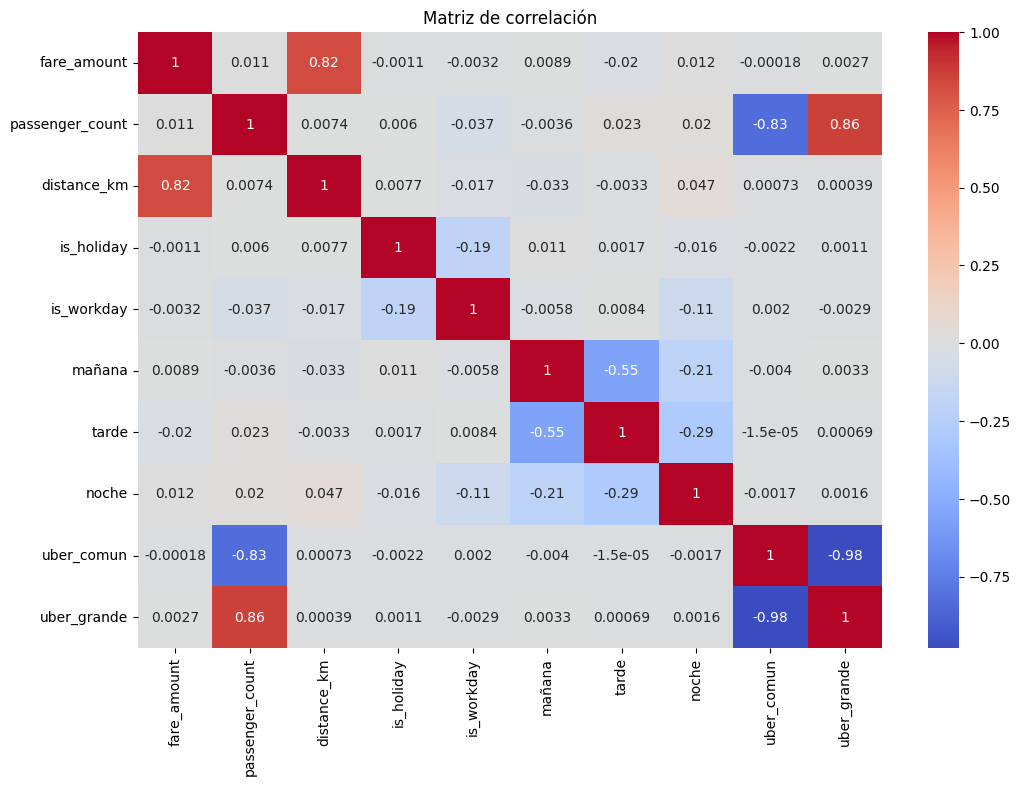

In [72]:
# Supongamos que tus features están en un DataFrame "df"
corr = df_modelo.corr()

plt.figure(figsize=(12,8))
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.title("Matriz de correlación")
plt.show()


passenger_count    1.00000
distance_km        0.00079
is_holiday         0.00000
is_workday         0.00000
mañana             0.00000
tarde              0.00000
noche              0.00000
uber_comun         1.00000
uber_grande        0.00000
Name: 170081, dtype: float64

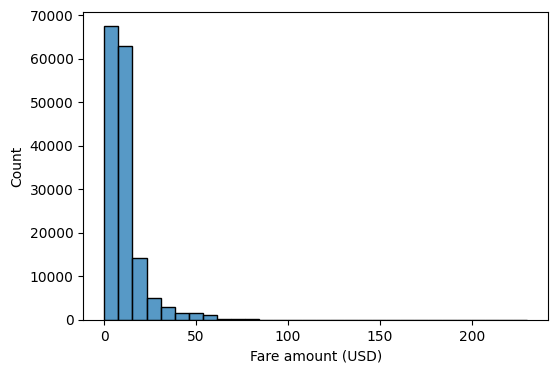

In [73]:
##histograma de fare_amount
plt.figure(figsize=(6,4))   
sns.histplot(y_train, bins=30, kde=False)
plt.xlabel("Fare amount (USD)")
##fare_amount mayores a 200
y_train[y_train > 200]
##ver fila del indice 170081
X_train.loc[170081]



In [138]:
from sklearn.compose import ColumnTransformer

num_cols = ["distance_km", "passenger_count"]
cat_cols = ["is_holiday", "is_workday", "mañana", "tarde", "noche", "uber_comun", "uber_grande"]

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", "passthrough", cat_cols)  # deja las dummies como están
    ]
)
X_train_scaled = preprocessor.fit_transform(X_train)
X_test_scaled = preprocessor.transform(X_test)

In [ ]:
#imputar coordenadas con knn

pipe_lr = Pipeline([
    ("scaler", preprocessor),
    ("model", LinearRegression())
])

# Entrenamos el pipeline con training set
pipe_lr.fit(X_train, y_train)

# Predicciones sobre train y test
y_train_pred = pipe_lr.predict(X_train)
y_test_pred = pipe_lr.predict(X_test)

print("Entrenamiento:")
### RMSE calcular el RMSE
rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
print("RMSE:", rmse)
print("R²:", r2_score(y_train, y_train_pred))

print("\nPrueba:")
rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
print("RMSE:", rmse)
print("R²:", r2_score(y_test, y_test_pred))



Entrenamiento:
RMSE: 4.794307854395589
R²: 0.7437364442778991

Prueba:
RMSE: 4.6205065713146976
R²: 0.7687200415986352


In [ ]:

# Supongamos que estas son tus columnas
from sklearn.compose import ColumnTransformer

num_cols = ["distance_km", "passenger_count"]
cat_cols = ["is_holiday", "is_workday", "mañana", "tarde", "noche", "uber_comun", "uber_grande"]

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", "passthrough", cat_cols)  # deja las dummies como están
    ]
)

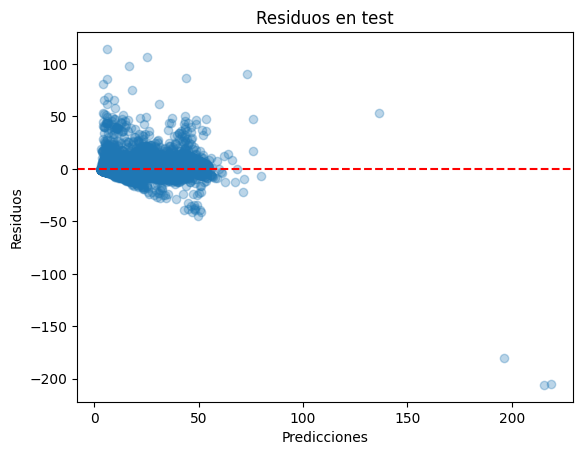

In [76]:
plt.scatter(y_test_pred, y_test - y_test_pred, alpha=0.3)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Predicciones")
plt.ylabel("Residuos")
plt.title("Residuos en test")
plt.show()

Se detectaron 486 outliers
     y_real     y_pred    residuo
6      4.10  25.825727 -21.725727
104    3.30  28.588481 -25.288481
129   89.80  53.730382  36.069618
189   49.57   6.169058  43.400942
477   33.83  19.699504  14.130496


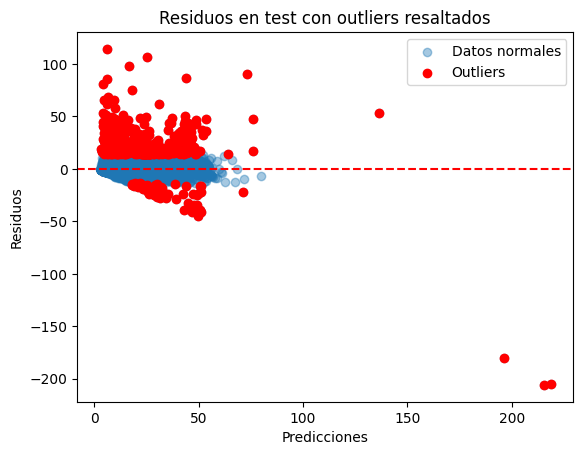

In [85]:

# Suponiendo que y_test y y_pred ya son numpy arrays o pandas Series
y_real = np.ravel(y_test)   # convierte a array 1D
y_pred = np.ravel(y_test_pred)   # convierte a array 1D

residuos = y_real - y_pred

# Calcular media y desvío estándar
mean_res = np.mean(residuos)
std_res = np.std(residuos)

# Definir umbral (3 sigmas)
umbral = 3 * std_res

# Detectar outliers
outliers_mask = np.abs(residuos - mean_res) > umbral
outliers = pd.DataFrame({
    "y_real": y_real,
    "y_pred": y_pred,
    "residuo": residuos
})[outliers_mask]

print(f"Se detectaron {outliers.shape[0]} outliers")
print(outliers.head())

# Gráfico con outliers resaltados
plt.scatter(y_pred, residuos, alpha=0.4, label="Datos normales")
plt.scatter(outliers["y_pred"], outliers["residuo"], color="red", label="Outliers")
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Predicciones")
plt.ylabel("Residuos")
plt.legend()
plt.title("Residuos en test con outliers resaltados")
plt.show()


GRADIENTE DESCENDIENTE


C:\Users\Usuario\AppData\Local\Temp\ipykernel_8796\204331158.py:31: RuntimeWarning: overflow encountered in square
  train_mse = np.mean(error_train ** 2)
C:\Users\Usuario\AppData\Local\Temp\ipykernel_8796\204331158.py:37: RuntimeWarning: overflow encountered in square
  test_mse = np.mean(error_test ** 2)


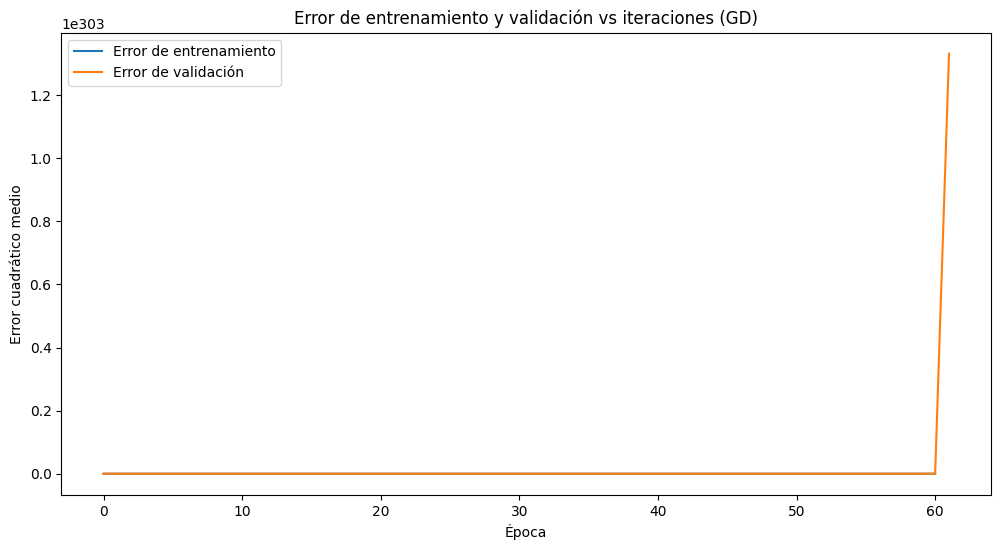

array([[ 1.33371798e+243],
       [-9.86620078e+244],
       [ 5.43503126e+244],
       [-9.86608132e+244],
       [ 5.43507535e+244],
       [ 2.24717314e+243],
       [ 4.43901576e+243],
       [ 3.91761093e+241],
       [ 7.31720831e+242],
       [ 3.82832109e+242],
       [ 5.76420321e+242],
       [ 1.31324719e+242],
       [ 1.20676339e+243],
       [ 1.22239026e+242]])

In [28]:
def gradient_descent(X_train, y_train, X_val, y_val, lr=0.01, epochs=100):
    """
    shapes:
        X_train = nxm
        y_train = nx1
        X_val = pxm
        y_test = px1
        W = mx1
    """
    n = X_train.shape[0]
    m = X_train.shape[1]
    
    o = X_val.shape[0]

    # Poner columna de unos a las matrices X
    X_train = np.hstack((np.ones((n, 1)), X_train))
    X_val = np.hstack((np.ones((o, 1)), X_val))
    

    # Inicializar pesos aleatorios
    W = np.random.randn(m+1).reshape(m+1, 1)

    train_errors = []  # Para almacenar el error de entrenamiento en cada época
    test_errors = []   # Para almacenar el error de prueba en cada época

    for _ in range(epochs):
        # Calcular predicción y error de entrenamiento
        prediction_train = np.matmul(X_train, W) 
        error_train = y_train - prediction_train  
        #print(error_train)
        train_mse = np.mean(error_train ** 2)
        train_errors.append(train_mse)

        # Calcular predicción y error de prueba
        prediction_test = np.matmul(X_val, W) 
        error_test = y_val - prediction_test 
        test_mse = np.mean(error_test ** 2)
        test_errors.append(test_mse)

        # Calcular el gradiente y actualizar pesos
        grad_sum = np.sum(error_train * X_train, axis=0)
        grad_mul = -2/n * grad_sum  # 1xm
        gradient = np.transpose(grad_mul).reshape(-1, 1)  # mx1

        W = W - (lr * gradient)

    # Graficar errores de entrenamiento y prueba
    # Definir una figura
    plt.figure(figsize=(12, 6))
    # Plotear errores de entrenamiento
    plt.plot(train_errors, label='Error de entrenamiento')
    # Plotear errores de prueba
    plt.plot(test_errors, label='Error de validación')
    # Poner labels en los ejes
    plt.xlabel('Época')
    plt.ylabel('Error cuadrático medio')
    # Activar la leyenda
    plt.legend()
    # Poner titulo
    plt.title('Error de entrenamiento y validación vs iteraciones (GD)')
    # Terminar y mostrar gráfico
    plt.show()

    return W

gradient_descent(X_train.values, y_train.values.reshape(-1, 1), X_test.values, y_test.values.reshape(-1, 1), lr=0.01, epochs=100)

ANDA RE LINDO

Época 0/100 - Train MSE: 214.2434 - Val MSE: 218.2681
Época 10/100 - Train MSE: 114.8746 - Val MSE: 117.6535
Época 20/100 - Train MSE: 71.8066 - Val MSE: 73.6966
Época 30/100 - Train MSE: 51.4178 - Val MSE: 52.6348
Época 40/100 - Train MSE: 40.8020 - Val MSE: 41.4910
Época 50/100 - Train MSE: 34.7780 - Val MSE: 35.0445
Época 60/100 - Train MSE: 31.1241 - Val MSE: 31.0484
Época 70/100 - Train MSE: 28.8026 - Val MSE: 28.4482
Época 80/100 - Train MSE: 27.2813 - Val MSE: 26.6990
Época 90/100 - Train MSE: 26.2630 - Val MSE: 25.4942


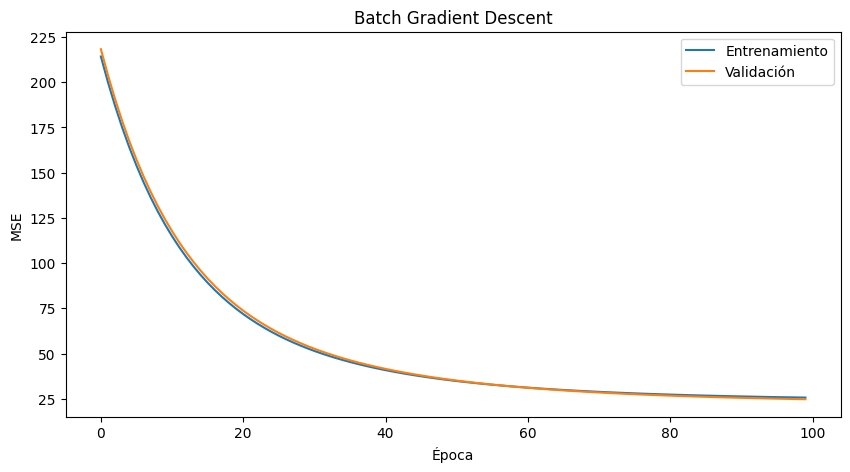

In [142]:
def gradient_descent(X_train, y_train, X_val, y_val, lr=0.01, epochs=100, schedule=False):
    n, m = X_train.shape
    o = X_val.shape[0]

    # Agregar columna de unos (bias)
    X_train = np.hstack((np.ones((n, 1)), X_train))
    X_val   = np.hstack((np.ones((o, 1)), X_val))

    # Asegurar vectores columna
    y_train = y_train.reshape(-1, 1)
    y_val   = y_val.reshape(-1, 1)

    # Inicializar pesos en cero
    W = np.zeros((m+1, 1))

    train_errors = []
    val_errors = []

    for ep in range(epochs):
        # Predicción entrenamiento
        pred_train = X_train @ W
        error_train = y_train - pred_train

        # MSE entrenamiento
        train_mse = np.mean(error_train**2)
        train_errors.append(train_mse)

        # Predicción validación
        pred_val = X_val @ W
        error_val = y_val - pred_val

        # MSE validación
        val_mse = np.mean(error_val**2)
        val_errors.append(val_mse)

        # Gradiente vectorizado: -(2/n) Xᵀ (y - XW)
        grad = -(2/n) * (X_train.T @ error_train)

        # Learning rate con schedule opcional
        lr_t = lr / np.sqrt(ep+1) if schedule else lr
        W -= lr_t * grad

        if ep % 10 == 0:
            print(f"Época {ep}/{epochs} - Train MSE: {train_mse:.4f} - Val MSE: {val_mse:.4f}")

    # Graficar
    plt.figure(figsize=(10, 5))
    plt.plot(train_errors, label='Entrenamiento')
    plt.plot(val_errors, label='Validación')
    plt.xlabel('Época')
    plt.ylabel('MSE')
    plt.legend()
    plt.title('Batch Gradient Descent')
    plt.show()

    return W



W_batch = gradient_descent(
    X_train_scaled, y_train.values,
    X_test_scaled, y_test.values,
    lr=0.01, epochs=100
)



Gradiente Estocástico


ESTA MIERDA NO ANDA

In [141]:
def stochastic_gradient_descent(X_train, y_train, X_test, y_test, lr=0.01, epochs=100):
    
    n = X_train.shape[0]
    m = X_train.shape[1]

    X_train = np.hstack((np.ones((n, 1)), X_train))
    X_test = np.hstack((np.ones((X_test.shape[0], 1)), X_test))

    W = np.random.randn(m + 1).reshape(-1, 1)

    train_errors = []
    test_errors = []

    for i in range(epochs):
        # Permutación aleatoria de los datos
        permutation = np.random.permutation(n)
        X_train = X_train[permutation]
        y_train = y_train[permutation]

        for j in range(n):
            # Obtener una muestra aleatoria de un solo dato para hacer SGD
            x_sample = X_train[j].reshape(1, -1)
            y_sample = y_train[j]

            prediction = np.matmul(x_sample, W)
            error = y_sample - prediction
            

            gradient = -2 * error * x_sample.T  

            W = W - (lr * gradient)
        
        prediction_train = np.matmul(X_train, W)
        train_mse = np.mean((y_train - prediction_train) ** 2)
        train_errors.append(train_mse)
        
        prediction_test = np.matmul(X_test, W)
        test_mse = np.mean((y_test - prediction_test)** 2)
        test_errors.append(test_mse)

            

    plt.figure(figsize=(12, 6))
    plt.plot(train_errors, label='Error de entrenamiento')
    plt.plot(test_errors, label='Error de prueba')
    plt.xlabel('Iteración')
    plt.ylabel('Error cuadrático medio')
    plt.legend()
    plt.title('Error de entrenamiento y prueba vs iteraciones (SGD)')
    plt.show()

    return W


stochastic_gradient_descent(X_train_scaled, np.array(y_train).reshape(-1,1), X_test_scaled, np.array(y_test).reshape(-1,1), lr=0.001, epochs=20)

KeyboardInterrupt: 

ESTE SI :)

Época 1/10 - Train MSE: 72.0938 - Test MSE: 73.9728
Época 2/10 - Train MSE: 54.4466 - Test MSE: 55.7641
Época 3/10 - Train MSE: 46.7112 - Test MSE: 47.7121
Época 4/10 - Train MSE: 41.7044 - Test MSE: 42.4405
Época 5/10 - Train MSE: 38.5053 - Test MSE: 39.0471
Época 6/10 - Train MSE: 36.2731 - Test MSE: 36.6565
Época 7/10 - Train MSE: 34.5944 - Test MSE: 34.8458
Época 8/10 - Train MSE: 33.0497 - Test MSE: 33.1644
Época 9/10 - Train MSE: 31.7235 - Test MSE: 31.7083
Época 10/10 - Train MSE: 30.9131 - Test MSE: 30.8157


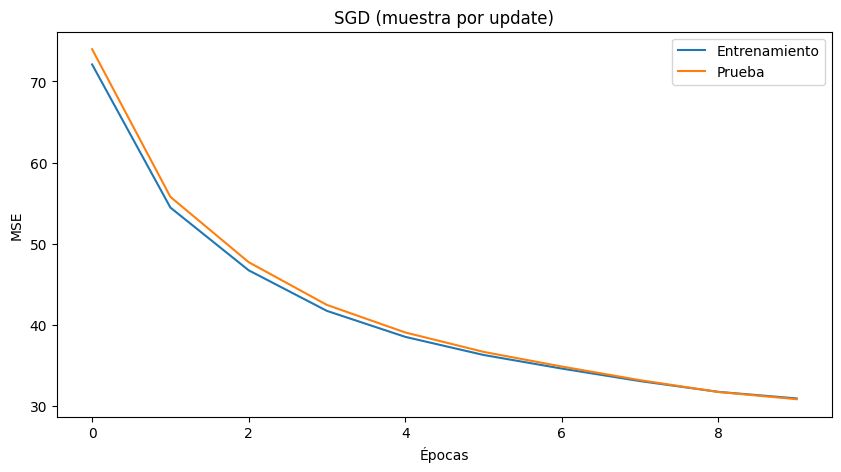

In [143]:
def stochastic_gradient_descent(
    X_train, y_train, X_test, y_test,
    lr=0.001, epochs=20, updates_per_epoch=10000, schedule=True
):
    n, m = X_train.shape

    # Agregar bias
    X_train = np.hstack((np.ones((n, 1)), X_train))
    X_test  = np.hstack((np.ones((X_test.shape[0], 1)), X_test))

    W = np.zeros((m + 1, 1))  # pesos iniciales

    train_errors, test_errors = [], []
    t = 0  # contador de updates totales

    for ep in range(epochs):
        # indices aleatorios para elegir muestras
        idx = np.random.permutation(n)
        k = min(updates_per_epoch, n)   # límite de updates por época
        pick = idx[:k]

        for j in pick:
            x_sample = X_train[j:j+1]   # (1, m+1)
            y_sample = y_train[j:j+1]   # (1, 1)

            prediction = x_sample @ W
            error = y_sample - prediction

            gradient = -2 * (x_sample.T @ error)
            lr_t = lr / np.sqrt(t+1) if schedule else lr
            W -= lr_t * gradient
            t += 1

        # calcular errores por época
        train_pred = X_train @ W
        train_mse = np.mean((y_train - train_pred)**2)
        train_errors.append(train_mse)

        test_pred = X_test @ W
        test_mse = np.mean((y_test - test_pred)**2)
        test_errors.append(test_mse)

        print(f"Época {ep+1}/{epochs} - Train MSE: {train_mse:.4f} - Test MSE: {test_mse:.4f}")

    # gráfico
    plt.figure(figsize=(10, 5))
    plt.plot(train_errors, label='Entrenamiento')
    plt.plot(test_errors, label='Prueba')
    plt.xlabel('Épocas')
    plt.ylabel('MSE')
    plt.legend()
    plt.title('SGD (muestra por update)')
    plt.show()

    return W


# Ejecutar SGD
W_sgd = stochastic_gradient_descent(
    X_train_scaled, np.array(y_train).reshape(-1,1),
    X_test_scaled,  np.array(y_test).reshape(-1,1),
    lr=0.001, epochs=10, updates_per_epoch=10000
)


Mini batch

NO ANDA

In [38]:
def mini_batch_gradient_descent(X_train, y_train, X_test, y_test, lr=0.01, epochs=100, batch_size=11):
    n = X_train.shape[0]
    m = X_train.shape[1]

    X_train = np.hstack((np.ones((n, 1)), X_train))
    X_test = np.hstack((np.ones((X_test.shape[0], 1)), X_test))

    W = np.random.randn(m + 1).reshape(-1, 1)

    train_errors = []
    test_errors = []

    for i in range(epochs):
        
        # Permutación aleatoria de los datos
        permutation = np.random.permutation(n)
        X_train = X_train[permutation]
        y_train = y_train[permutation]


        for j in range(0, n, batch_size):
            # Obtener un lote (mini-batch) de datos
            x_batch = X_train[j:j+batch_size, :]
            y_batch = y_train[j:j+batch_size].reshape(-1, 1)

            prediction = np.matmul(x_batch, W)
            error = y_batch - prediction
            train_mse = np.mean(error ** 2)
            train_errors.append(train_mse)

            gradient = -2 * np.matmul(x_batch.T, error) / batch_size

            W = W - (lr * gradient)

            prediction_test = np.matmul(X_test, W)
            error_test = y_test - prediction_test
            test_mse = np.mean(error_test ** 2)
            test_errors.append(test_mse)

    plt.figure(figsize=(12, 6))
    plt.plot(train_errors, label='Error de entrenamiento')
    plt.plot(test_errors, label='Error de prueba')
    plt.xlabel('Iteración')
    plt.ylabel('Error cuadrático medio')
    plt.legend()
    plt.title('Error de entrenamiento y prueba vs iteraciones (Mini-Batch GD)')
    plt.show()

    return W

mini_batch_gradient_descent(X_train, y_train, X_test, y_test, lr=0.01, epochs=100, batch_size=11)

KeyError: '[98276, 97534, 64384, 88908, 82953, 69485, 104487, 75366, 61185, 5397, 23264, 111626, 317, 25587, 84209, 22346, 57480, 80888, 58551, 37197, 142114, 88430, 47366, 22350, 111817, 64202, 153326, 133515, 12432, 150373, 11497, 53146, 58045, 138303, 3366, 32428, 109170, 80162, 44238, 1486, 872, 6628, 75107, 136597, 25362, 8109, 57568, 138266, 155447, 59479, 19651, 79041, 19011, 8952, 109566, 63185, 139874, 28631, 10091, 50594, 64737, 150379, 97912, 41233, 1374, 67862, 114919, 35714, 30913, 41844, 82088, 107848, 32800, 117816, 85863, 107629, 94193, 22138, 146073, 12271, 77022, 138347, 80196, 141150, 26341, 81032, 131593, 51707, 15780, 152257, 50682, 45530, 83349, 79685, 84690, 43336, 33715, 53805, 111066, 19408, 130063, 41067, 66891, 81864, 32098, 54496, 31702, 96225, 131326, 57064, 112315, 90430, 144387, 33229, 132864, 107072, 110957, 1829, 140584, 120439, 44020, 65, 154189, 12603, 31560, 154296, 110117, 108459, 118064, 102352, 116899, 37250, 18871, 117761, 90461, 146193, 35385, 110024, 123684, 121272, 76009, 58168, 143008, 59881, 69869, 13226, 132016, 51968, 13876, 62472, 123831, 126727, 82820, 25917, 101243, 78644, 130412, 21976, 107348, 23641, 127472, 62580, 69030, 61187, 37203, 125778, 66742, 44771, 9069, 107877, 20326, 94418, 41793, 48331, 58709, 28947, 15640, 122, 150030, 118487, 84778, 114754, 237, 105801, 155312, 51186, 109322, 100499, 93550, 89100, 120264, 83732, 156598, 21509, 150004, 150292, 58738, 16967, 74222, 2843, 118451, 101850, 134350, 15662, 33600, 15200, 103768, 107708, 26866, 123239, 109044, 127932, 110870, 86926, 87608, 88737, 1501, 142838, 2107, 133148, 7938, 30507, 148364, 134386, 46470, 45232, 130630, 141680, 14504, 113170, 19736, 122616, 5687, 117859, 9385, 152517, 139263, 96812, 54786, 13302, 151124, 65410, 71611, 138280, 44596, 20481, 37655, 15511, 139273, 53849, 93579, 46762, 22736, 110407, 82779, 71351, 130425, 48882, 51742, 2167, 22507, 151296, 89911, 59984, 12970, 108797, 71278, 39256, 86668, 2570, 98581, 154301, 6465, 50690, 99812, 137986, 99866, 135060, 113375, 17454, 36663, 60708, 10178, 130478, 4077, 99105, 139381, 8850, 62942, 70124, 130922, 103838, 99145, 107389, 27888, 147543, 36052, 138218, 136911, 102417, 19812, 134410, 145945, 94656, 125887, 150874, 40153, 7527, 151120, 104071, 126696, 83872, 91946, 110860, 36325, 116620, 39975, 121000, 136215, 47832, 90586, 49638, 92216, 135520, 13361, 41140, 137580, 36, 141522, 141792, 2162, 149032, 42723, 150302, 155827, 17544, 85491, 5336, 60767, 127384, 104681, 20694, 128384, 148533, 135489, 94334, 125001, 29776, 22891, 1444, 37020, 113484, 98065, 87452, 138119, 148257, 134241, 67106, 132816, 70412, 129037, 139138, 115937, 111548, 45933, 143849, 155150, 124114, 74566, 47941, 114261, 44572, 44592, 133725, 101970, 32443, 136038, 60566, 148290, 148741, 129368, 136352, 2685, 53393, 143691, 96751, 32038, 101740, 131452, 141200, 72364, 21309, 110692, 84141, 89732, 134935, 31078, 29251, 152397, 93716, 119498, 151719, 33482, 53229, 99727, 62198, 127872, 50880, 1301, 78300, 35454, 52624, 2369, 24119, 93549, 706, 72509, 104137, 15609, 19096, 43089, 60905, 131004, 154144, 133431, 77782, 12686, 115687, 79557, 116491, 67344, 56361, 86321, 78259, 6396, 63174, 29767, 52170, 138654, 136265, 40276, 73928, 93966, 58606, 149841, 147646, 78852, 77076, 120278, 64670, 153274, 107825, 86701, 120124, 121462, 103777, 67452, 134154, 9007, 37377, 64210, 134769, 141910, 144420, 28670, 10968, 133466, 109719, 67941, 71078, 48107, 68460, 23428, 59098, 93707, 20168, 81741, 71326, 46751, 16268, 18217, 97136, 133344, 79021, 53027, 43228, 44595, 51995, 21796, 17462, 135968, 32480, 31551, 149066, 16632, 147758, 71681, 86237, 114859, 76425, 109488, 115204, 109158, 11770, 15056, 58938, 21795, 122847, 20746, 79504, 119770, 78944, 50444, 53184, 145152, 81286, 47096, 155696, 143706, 88063, 48366, 37572, 143739, 101865, 109281, 74360, 136259, 67021, 117913, 72072, 70944, 68331, 108758, 59181, 31423, 126335, 53782, 59603, 95124, 75734, 46557, 12351, 104085, 37095, 111506, 124355, 4000, 20082, 34271, 97725, 10150, 96684, 102960, 71128, 91839, 11196, 134800, 134517, 23403, 73061, 66856, 19236, 30873, 87247, 40993, 51614, 8236, 96784, 77384, 1038, 143943, 43732, 29102, 3049, 132803, 5417, 99562, 78710, 129926, 33452, 133429, 150064, 141732, 65576, 101819, 142711, 31277, 102049, 99024, 7976, 49676, 14092, 32537, 74969, 115556, 144412, 121203, 14507, 141053, 17994, 106064, 143211, 89215, 28767, 110299, 73663, 46599, 73181, 59384, 101955, 108380, 28103, 98661, 52652, 131443, 72295, 141031, 26539, 122415, 14148, 109519, 145097, 20013, 80655, 5980, 24853, 80393, 72992, 33263, 55859, 42875, 143061, 1067, 48835, 33850, 4710, 130889, 119682, 45288, 130954, 82092, 88708, 132987, 88384, 123423, 89008, 16095, 97830, 88957, 110770, 127498, 111374, 35012, 156449, 18262, 76127, 11919, 149834, 92801, 41131, 5633, 4189, 154670, 154343, 41232, 93946, 92404, 107170, 70756, 144550, 59894, 75103, 137674, 129455, 86015, 87588, 129533, 117368, 134524, 118875, 134979, 70010, 2820, 18270, 39300, 112205, 51708, 153860, 87671, 43720, 85984, 18949, 138334, 127352, 120788, 26066, 85396, 36604, 3715, 97291, 136682, 29085, 100044, 39536, 67527, 99482, 50067, 130232, 137876, 132503, 74273, 148374, 78450, 136703, 111713, 141846, 152830, 90994, 132541, 19846, 122499, 39402, 106390, 10415, 142149, 134969, 130537, 91513, 70812, 60002, 101844, 43743, 108650, 73238, 56176, 59538, 104410, 69480, 90775, 42098, 111119, 32251, 74679, 16472, 29443, 56819, 24282, 44153, 72041, 121317, 119832, 97054, 69460, 109527, 52639, 112897, 5318, 8712, 144811, 58521, 22876, 42834, 64755, 115994, 79401, 18929, 39137, 110674, 92165, 139324, 54825, 68334, 36134, 152460, 75755, 129756, 104107, 153653, 127987, 74196, 64361, 23065, 66815, 14844, 59718, 37232, 11604, 139996, 118564, 33751, 42018, 21517, 101246, 145763, 63628, 16712, 109133, 32925, 146111, 156453, 103475, 30966, 46700, 140333, 51545, 126620, 10827, 38965, 46217, 40532, 112581, 71298, 7268, 60061, 113266, 85769, 132879, 41051, 61483, 56509, 112156, 64058, 100387, 101798, 128927, 146600, 82711, 89137, 4128, 127715, 87482, 51309, 54693, 19537, 77065, 124596, 30519, 22307, 12028, 107858, 19134, 153589, 153242, 156017, 105472, 132957, 30650, 8714, 36416, 71121, 128896, 85051, 114131, 147042, 138331, 12320, 138131, 146670, 102067, 75055, 44619, 18731, 143114, 84587, 62956, 77715, 68137, 154063, 4832, 1302, 14017, 20798, 145568, 97587, 54360, 123338, 143606, 69058, 147583, 85247, 152603, 61426, 26628, 6064, 147188, 142353, 34969, 140092, 28167, 81980, 82678, 6769, 63012, 89674, 143273, 38125, 38139, 62548, 115356, 13519, 108573, 80570, 90091, 123237, 2849, 128593, 59319, 27645, 72249, 46830, 100121, 139110, 70533, 79339, 57458, 55686, 142956, 154756, 97135, 108580, 20320, 3069, 54567, 113694, 102329, 110029, 149393, 116266, 135477, 128826, 103099, 87905, 6625, 47570, 125246, 19578, 101995, 153918, 29072, 109413, 45029, 119378, 65534, 147322, 41507, 120416, 30077, 147771, 17435, 21367, 32147, 101260, 17197, 3960, 34032, 137689, 59544, 48097, 45388, 93496, 85120, 91024, 102788, 152858, 131279, 91114, 5989, 64635, 130468, 129818, 153426, 113297, 128457, 21844, 133448, 142259, 73668, 111359, 3647, 132578, 122573, 81985, 52841, 93231, 55220, 66513, 128656, 32629, 67251, 149392, 133216, 9353, 97755, 55563, 90748, 41084, 128389, 99818, 53072, 25867, 23152, 54922, 4292, 31618, 122797, 116701, 13985, 33079, 61078, 32536, 139565, 111917, 143209, 106640, 67528, 11411, 46368, 78781, 115182, 14883, 54887, 76319, 18562, 135330, 106347, 89019, 53161, 78859, 126181, 2551, 117399, 119852, 113849, 20058, 24681, 132100, 92931, 53797, 91143, 96534, 126130, 79316, 104950, 58563, 62724, 51308, 29948, 110750, 133793, 118488, 4648, 155534, 63219, 137053, 95810, 16136, 143012, 33744, 70595, 835, 94590, 66065, 21429, 146974, 52161, 26781, 80876, 67765, 129734, 141338, 153662, 21410, 6036, 130865, 40054, 104005, 67585, 41885, 46674, 34909, 27581, 671, 115629, 48341, 39644, 104907, 87286, 25158, 92331, 142735, 57466, 125207, 130653, 3090, 49111, 129569, 52317, 5235, 21507, 71796, 22468, 16768, 87619, 25281, 127955, 103218, 70513, 137349, 126118, 138866, 63097, 2372, 39780, 132666, 58809, 58309, 89234, 3748, 39408, 111633, 92998, 93659, 120174, 72282, 127903, 27898, 143787, 37650, 147436, 17324, 72272, 125661, 133893, 151970, 110829, 96263, 33396, 24679, 85296, 14496, 31490, 48703, 40371, 74042, 73860, 80987, 105510, 117069, 3186, 20445, 104862, 29694, 134716, 50910, 30668, 27155, 2873, 103069, 122394, 156089, 50519, 85741, 52593, 122298, 29237, 42777, 48251, 144721, 47703, 22074, 70183, 4111, 54350, 120041, 154886, 156565, 30829, 84452, 154489, 124686, 41537, 77146, 68211, 130492, 147099, 59208, 114546, 110401, 131311, 46923, 25556, 24983, 66792, 87347, 93792, 65959, 129119, 156412, 22887, 92894, 51359, 109218, 14458, 103408, 122774, 138780, 89768, 83624, 114198, 29157, 16332, 97353, 147262, 32349, 44820, 107894, 102998, 55167, 119752, 60440, 92417, 90284, 110286, 56224, 49614, 75280, 153413, 99408, 62881, 109638, 31210, 46843, 56254, 63140, 59686, 82819, 29941, 131596, 150194, 27765, 48393, 137362, 123439, 142613, 42020, 57004, 15433, 119176, 142225, 152674, 55112, 81965, 146249, 73286, 85518, 61885, 35267, 63948, 109508, 85009, 42549, 49498, 109529, 73130, 66526, 142433, 7852, 2447, 77193, 123248, 26935, 38881, 77628, 27704, 150353, 45699, 37892, 116221, 84987, 127887, 43088, 95660, 110762, 112140, 21024, 17827, 7791, 118530, 103742, 79812, 22802, 14629, 99486, 112479, 136425, 143186, 143175, 152983, 33990, 151010, 51206, 68392, 32292, 97282, 204, 142724, 104996, 134525, 75333, 106473, 21878, 138507, 74448, 26898, 26585, 46026, 156100, 4291, 153106, 63163, 128001, 110205, 98631, 81067, 3175, 40945, 85457, 5899, 111347, 127727, 56491, 118509, 82063, 138911, 15985, 35861, 128918, 143352, 110625, 94367, 122968, 74415, 76215, 94827, 326, 125528, 50403, 107499, 35079, 108811, 63393, 134255, 32646, 115587, 43714, 15214, 80763, 36366, 119778, 76511, 40825, 32502, 115873, 83606, 151939, 148943, 145734, 99652, 73844, 111134, 86613, 95688, 72794, 31667, 16526, 38904, 156596, 123503, 127642, 78647, 134706, 120706, 142672, 83896, 38370, 32613, 128598, 154088, 109428, 77835, 76669, 19053, 25607, 133581, 112193, 121867, 95273, 53150, 83145, 138032, 62104, 137062, 59651, 48287, 35587, 151006, 94317, 13435, 105808, 85683, 34817, 107102, 53838, 114499, 100106, 48872, 129158, 61639, 108912, 137158, 142971, 151338, 102920, 127702, 8992, 90750, 64117, 146603, 66401, 67908, 83875, 14475, 17665, 28430, 39556, 94535, 112207, 80729, 62874, 112186, 40949, 84665, 34030, 9987, 27428, 87137, 108546, 115542, 7739, 112776, 6292, 82653, 93454, 50032, 116203, 92546, 58816, 136642, 79473, 31357, 68820, 29910, 32961, 82620, 152801, 120279, 77560, 59079, 96892, 99146, 17726, 28444, 69585, 36191, 23875, 153774, 66518, 413, 11553, 135893, 119170, 115363, 140177, 2948, 107501, 78118, 37744, 137308, 17423, 9747, 143203, 113883, 61189, 152135, 19027, 63346, 106842, 128787, 676, 45710, 81799, 18273, 101691, 36701, 149530, 41646, 142005, 63787, 146279, 62248, 54865, 92002, 3693, 61937, 39042, 56531, 83753, 116346, 43844, 138177, 37474, 52288, 7362, 68459, 44215, 54920, 130593, 131895, 29302, 95832, 37065, 63648, 119650, 50212, 83176, 37685, 144889, 25879, 154707, 1733, 50637, 119135, 48740, 91534, 145908, 11736, 36223, 155408, 52364, 39435, 71997, 66027, 13727, 142265, 152556, 149065, 84269, 70088, 82004, 40656, 40676, 28849, 111758, 22995, 64016, 81735, 73005, 53976, 116922, 7600, 44391, 63357, 87565, 139275, 12415, 137464, 134958, 21482, 138681, 75671, 133050, 51717, 148985, 98736, 76781, 39155, 99008, 137304, 123070, 5814, 146116, 123702, 155643, 96503, 111908, 139071, 55135, 65571, 27040, 30256, 134656, 141284, 69349, 70681, 58597, 15438, 140560, 105741, 54386, 3973, 44765, 104223, 112636, 59153, 147052, 44983, 31743, 72284, 19516, 117219, 126004, 101476, 152859, 124116, 6211, 1439, 57488, 61727, 3859, 22853, 80620, 60296, 30379, 92718, 48980, 12039, 21558, 5637, 90746, 74400, 53905, 147656, 128949, 122651, 61791, 16773, 4968, 136778, 67381, 76582, 8482, 124336, 32692, 52306, 67739, 46410, 68812, 43695, 9615, 129091, 52711, 11888, 154725, 114889, 525, 90585, 99941, 151724, 72982, 111904, 22115, 63060, 58766, 54339, 15581, 91460, 112041, 107053, 3896, 142413, 106689, 994, 142108, 35848, 94858, 45395, 64707, 77992, 120060, 92332, 138948, 118972, 115263, 62257, 124211, 46121, 4696, 50085, 38884, 140607, 46076, 8747, 85939, 65834, 47001, 77468, 82153, 153169, 65608, 51546, 21272, 112126, 69972, 52768, 153066, 56322, 38151, 101699, 67219, 57117, 86146, 112908, 57828, 79794, 108656, 110649, 140989, 12641, 126359, 52098, 59226, 134697, 156354, 69969, 37941, 67032, 154861, 9985, 4276, 131857, 20848, 52522, 121756, 27737, 969, 62384, 122255, 14588, 77445, 43436, 27568, 9440, 135775, 66835, 149483, 29657, 61668, 42571, 40574, 16439, 77329, 114515, 147596, 108002, 149758, 139955, 66647, 116825, 94818, 34018, 95891, 60193, 106049, 135663, 100829, 84645, 109730, 116738, 14033, 23174, 24757, 83102, 116248, 115339, 87930, 78946, 115782, 67992, 30086, 47468, 31153, 149960, 55562, 110068, 37978, 151650, 31690, 25546, 80546, 114213, 63746, 77862, 116185, 121656, 156009, 24530, 59254, 82084, 10856, 134206, 37319, 63514, 105502, 120032, 144757, 41314, 71346, 52956, 81745, 33926, 98870, 92487, 100751, 105836, 42713, 140739, 22482, 25039, 25682, 153673, 131257, 6876, 92984, 99371, 143426, 33537, 4022, 106244, 55149, 104672, 100100, 133365, 21198, 72100, 48491, 43606, 104366, 32818, 8419, 26722, 63474, 72275, 98261, 74161, 122488, 76954, 95186, 97144, 82593, 37058, 59381, 7638, 113218, 89322, 23977, 139046, 105017, 34046, 27435, 150613, 17089, 122986, 89206, 84017, 116605, 16395, 57221, 22940, 151452, 24738, 117883, 109577, 8877, 8395, 9782, 74584, 93624, 27513, 151507, 82591, 133810, 141493, 70037, 135079, 65423, 132483, 118136, 129284, 130003, 109927, 139564, 33889, 86163, 23772, 141103, 46957, 31862, 154413, 46157, 83504, 92174, 102340, 71857, 142432, 112575, 14527, 75811, 39660, 39197, 65206, 32165, 110742, 151946, 22986, 94927, 128546, 67659, 54322, 54037, 47460, 132741, 16737, 29642, 72210, 55153, 17952, 69422, 156040, 146030, 91610, 2836, 10382, 52887, 4916, 149700, 146592, 97116, 88147, 26133, 132150, 12344, 101707, 81384, 126121, 22939, 80501, 108272, 2023, 19172, 76980, 119604, 126841, 55460, 99263, 58310, 52863, 56974, 115426, 65998, 75664, 144012, 144705, 48713, 115373, 32185, 114654, 70909, 135852, 112967, 129719, 134696, 64193, 37239, 65565, 95394, 113478, 11563, 32968, 80873, 111985, 39928, 133885, 45504, 47920, 92119, 18515, 18719, 31715, 981, 60486, 97073, 97631, 27525, 122992, 132180, 66168, 48998, 35469, 57220, 136787, 70507, 62585, 116290, 124727, 83389, 151115, 137684, 68551, 108130, 153898, 54657, 85525, 70090, 53305, 3025, 92643, 7436, 8772, 76741, 138940, 121773, 67302, 45069, 3994, 61644, 122095, 115251, 2796, 42332, 72664, 119162, 78795, 108523, 20361, 47477, 83642, 92784, 144964, 155094, 148285, 71618, 26875, 19787, 62307, 22291, 41077, 105268, 105465, 68897, 8038, 119349, 78374, 49710, 126314, 35306, 143009, 135099, 24219, 142244, 133818, 141862, 89393, 74048, 93024, 37728, 107081, 112561, 65914, 4844, 115312, 116434, 66947, 80130, 92206, 77347, 136655, 14899, 90624, 73505, 151985, 86018, 73689, 129950, 42398, 152283, 9855, 125311, 146859, 125585, 133852, 133434, 99970, 49631, 139315, 60260, 6143, 53039, 93988, 149503, 103609, 50010, 117595, 114272, 125280, 31709, 146871, 49280, 100738, 143244, 133755, 57049, 71867, 69078, 60416, 28680, 72779, 58144, 85726, 120010, 47429, 117334, 108302, 20479, 85027, 11880, 94759, 148087, 35964, 136711, 49764, 86593, 117885, 51469, 77128, 24218, 82463, 145377, 101689, 42205, 99416, 96354, 58323, 69515, 152106, 74633, 9961, 3846, 77238, 377, 33084, 72204, 101987, 112639, 50747, 118945, 40038, 29504, 107148, 138365, 82165, 120222, 141890, 113049, 91483, 47844, 75417, 107240, 111732, 111383, 137980, 25232, 24491, 80480, 110417, 59133, 114419, 88550, 23192, 37923, 133461, 78087, 94433, 123674, 137110, 128086, 134379, 127610, 147138, 71824, 32967, 119219, 47754, 129221, 58633, 59103, 332, 150616, 129383, 9168, 75712, 86660, 77461, 68250, 121199, 125884, 130520, 137142, 28823, 17865, 104705, 69479, 32481, 96999, 116682, 44116, 145717, 110145, 45326, 106768, 19692, 2815, 112275, 17240, 33338, 147010, 92848, 122726, 30226, 32988, 125491, 112746, 82375, 33238, 16171, 113810, 123175, 110131, 104589, 662, 47925, 46087, 114025, 8546, 5146, 18621, 50853, 154919, 40815, 10531, 127053, 6653, 27938, 99994, 127005, 134346, 68138, 143646, 21730, 86439, 89636, 97734, 76585, 123295, 56469, 146763, 23115, 64503, 123638, 132548, 98301, 81574, 137545, 34801, 69694, 41207, 55825, 25777, 87194, 34874, 60544, 80191, 109679, 53752, 123976, 65797, 62785, 155879, 119484, 20270, 102991, 96061, 96774, 68809, 8936, 76143, 142024, 110302, 23061, 80470, 53876, 131017, 142675, 49027, 91978, 37509, 106254, 108203, 81653, 60876, 89418, 99159, 135526, 149104, 121609, 14177, 1288, 138710, 66361, 68220, 148804, 11481, 95594, 60911, 66282, 3172, 49972, 139428, 122767, 105378, 80149, 99092, 107665, 113934, 130277, 28558, 70611, 30449, 138394, 129610, 76822, 19790, 85264, 127414, 145935, 156590, 523, 108143, 127810, 141731, 135866, 102102, 40264, 149784, 54824, 77779, 130740, 9031, 93623, 61206, 30316, 78779, 10267, 67702, 34557, 59112, 36640, 52242, 75959, 154982, 114942, 142157, 99811, 20959, 141682, 147154, 105, 103960, 98881, 82452, 155960, 96821, 55925, 38194, 102265, 39965, 124555, 128996, 89083, 142215, 70319, 131323, 54980, 134832, 134568, 147134, 48863, 126311, 48679, 67562, 45843, 122284, 5137, 65891, 7304, 90705, 80228, 57367, 63689, 129372, 23437, 48001, 23062, 149411, 104644, 119880, 111653, 134348, 151881, 26450, 95874, 61229, 27135, 3762, 31887, 23673, 76082, 118423, 28123, 1835, 100935, 105143, 94917, 75017, 142125, 65558, 53324, 152127, 107466, 148131, 104560, 10432, 110453, 12665, 116275, 102173, 52788, 124404, 106960, 93769, 46111, 149021, 45128, 64526, 125600, 48138, 84026, 104947, 151664, 65184, 16530, 105910, 129040, 70462, 139024, 30634, 16468, 10520, 25148, 78994, 16935, 98703, 389, 95139, 62553, 33714, 37819, 153083, 98942, 135258, 139506, 146966, 30559, 109968, 75219, 15291, 34476, 147757, 119519, 57911, 53193, 46208, 44614, 68489, 67688, 122469, 114144, 90670, 93284, 14952, 89247, 27482, 88495, 75033, 31229, 62667, 153903, 131082, 679, 44067, 108911, 148439, 2701, 112699, 124903, 97009, 127312, 596, 81595, 4782, 19314, 133592, 129391, 120644, 62269, 92696, 97806, 126770, 144774, 123000, 68056, 117749, 8105, 153839, 120949, 42673, 25628, 45859, 138209, 122970, 91685, 80881, 42837, 187, 79945, 122751, 121960, 3466, 133444, 77035, 68775, 113296, 66455, 14759, 87957, 57377, 143242, 67665, 107406, 110342, 28469, 137922, 78791, 130320, 69283, 3303, 92090, 97977, 143779, 108775, 80289, 59236, 127456, 117386, 113439, 71851, 151592, 65949, 149252, 22281, 42989, 35876, 127598, 96598, 23136, 16303, 130045, 140391, 82330, 148308, 142027, 139912, 24502, 13942, 140453, 139242, 93135, 151463, 110466, 5735, 144121, 22953, 125885, 39681, 75353, 120285, 68940, 10775, 116903, 120607, 124621, 98764, 45479, 107542, 4269, 106128, 50038, 128537, 155691, 87903, 145491, 77371, 94046, 48781, 106083, 16801, 56065, 20899, 31763, 143766, 53469, 25824, 129314, 23661, 132374, 127333, 70706, 37299, 92538, 113056, 65790, 136914, 68274, 135909, 144205, 42664, 59643, 126901, 141950, 51992, 104789, 61709, 79304, 51554, 137582, 8958, 59847, 139432, 96742, 77555, 66943, 61317, 115481, 54492, 137417, 63941, 16000, 138465, 68049, 96910, 57977, 72421, 89630, 108414, 124960, 36505, 12744, 85266, 153159, 30949, 28886, 6978, 126303, 125550, 80287, 113558, 68701, 58494, 49306, 22011, 121099, 102442, 87789, 12100, 54897, 127493, 66430, 21898, 112244, 1211, 99370, 30172, 90388, 140579, 58800, 14377, 149115, 9085, 29755, 45170, 41018, 84580, 33509, 26364, 36574, 139007, 8895, 55225, 59214, 39718, 96046, 142945, 19130, 15746, 16089, 27656, 102719, 103238, 55372, 98920, 141149, 149166, 5766, 22141, 21035, 15041, 132966, 12536, 46555, 70468, 10195, 130013, 13894, 44659, 87081, 62925, 116946, 68882, 143546, 63679, 77638, 58356, 716, 109172, 58401, 22053, 73993, 148687, 24378, 128141, 144631, 62135, 101959, 103097, 109180, 71752, 96540, 48666, 112943, 69646, 123162, 37743, 127569, 4194, 45439, 4827, 140951, 131035, 49462, 12746, 32213, 36050, 126636, 110782, 117703, 40571, 129316, 134755, 46722, 131974, 36932, 108749, 20810, 80443, 134919, 43722, 55083, 105610, 37356, 7770, 109434, 115241, 14990, 108983, 28953, 90572, 20791, 89239, 12943, 14665, 112287, 74181, 111213, 96057, 147839, 21209, 128491, 7206, 85446, 147681, 25447, 128425, 27085, 93937, 15206, 29507, 122407, 90123, 21462, 17128, 118865, 128822, 1159, 149205, 57136, 154892, 148145, 132292, 129500, 92547, 115265, 7522, 118462, 125263, 395, 103063, 13070, 102135, 50008, 76452, 102597, 82734, 73799, 154455, 26797, 15350, 127779, 64073, 139537, 37052, 38445, 63450, 65314, 144161, 115156, 79719, 66490, 30996, 44819, 120138, 148105, 137850, 126714, 10990, 57084, 116082, 66332, 6654, 114582, 91450, 57607, 134520, 100262, 123146, 35739, 130176, 54308, 22732, 58880, 141851, 32854, 8401, 38068, 74578, 32751, 134260, 144925, 97033, 34627, 137527, 86785, 134453, 67743, 152109, 115904, 102801, 30323, 60202, 29180, 143407, 140609, 115974, 2433, 21224, 125763, 132711, 63011, 1281, 64244, 33617, 113333, 12567, 76137, 66447, 145259, 150333, 55616, 22899, 128076, 82417, 101030, 105693, 99134, 8078, 152392, 106885, 3561, 134820, 97351, 107795, 46127, 72581, 136205, 49467, 6104, 12848, 139606, 68412, 21847, 101531, 6898, 148813, 30220, 64351, 66011, 13651, 97404, 15720, 12963, 13292, 136792, 66646, 50462, 123232, 134763, 640, 109025, 101228, 142904, 119705, 137890, 87182, 68231, 106051, 43027, 101187, 15180, 143910, 137346, 35077, 91096, 134976, 61289, 53261, 149902, 93710, 2675, 28888, 116086, 138076, 33942, 59931, 9294, 77840, 20400, 153697, 38710, 118319, 28423, 123703, 50931, 155332, 72350, 44394, 100542, 122519, 153097, 76928, 105845, 82899, 16366, 116007, 59364, 22529, 41817, 46993, 103847, 148274, 58680, 132112, 67566, 123876, 25138, 105231, 71274, 59457, 148971, 83683, 121318, 92828, 139114, 57598, 73698, 58749, 155126, 72470, 33132, 107315, 75992, 28628, 131681, 82573, 78162, 60871, 129593, 2718, 87358, 22560, 149736, 72064, 125738, 51113, 139509, 100271, 101808, 92162, 9200, 101196, 24946, 51864, 60826, 17347, 149080, 91328, 63560, 5199, 36502, 13173, 37701, 62595, 64135, 68793, 140174, 29048, 68939, 143608, 112830, 10095, 31071, 29435, 10754, 66540, 77726, 59179, 14941, 152177, 15383, 88420, 134915, 72669, 88792, 95451, 89829, 52445, 54875, 91858, 35574, 12994, 23044, 54520, 56599, 131817, 6860, 74690, 68682, 138082, 11591, 111482, 63730, 5897, 51788, 44284, 38480, 42595, 76754, 26201, 54027, 84426, 107668, 35854, 102599, 59110, 46685, 100051, 3453, 78760, 121381, 8308, 135484, 41532, 40384, 65525, 128495, 117090, 36654, 40591, 118937, 79306, 77326, 141152, 96941, 98160, 140515, 42896, 8643, 149188, 119207, 102715, 36508, 47558, 117756, 139662, 95347, 149034, 24033, 86177, 46281, 114958, 73131, 123567, 66038, 58530, 134425, 95460, 63275, 144582, 63399, 36044, 2645, 114413, 8090, 37287, 12889, 13752, 118940, 42757, 43860, 4, 15375, 74122, 103172, 54055, 82808, 110456, 19355, 9538, 35575, 31987, 114164, 136727, 82969, 42237, 18763, 139924, 116719, 36452, 101458, 56850, 62048, 20142, 143783, 15364, 48553, 135431, 54478, 88598, 14408, 123603, 135621, 154013, 148941, 25837, 98353, 147652, 151959, 16965, 88876, 19658, 106268, 16493, 49692, 101954, 58542, 50892, 37367, 26874, 149617, 102839, 26080, 137399, 14907, 41580, 145703, 137025, 140202, 33488, 8583, 9650, 140587, 11501, 96868, 149108, 36212, 73894, 64225, 143178, 32122, 127733, 76575, 36284, 139455, 131270, 37948, 14222, 18925, 14353, 102088, 59047, 138859, 109579, 67274, 93120, 11881, 148416, 102465, 58660, 134884, 34035, 102205, 128728, 113947, 94708, 86919, 46466, 27764, 92278, 123231, 103821, 55772, 123326, 7932, 103497, 69563, 93241, 97824, 128721, 5936, 60340, 120143, 103693, 6502, 109399, 25904, 152050, 113219, 21632, 124196, 98067, 12132, 72831, 56319, 62521, 87339, 115458, 63886, 120108, 107337, 63395, 142197, 106683, 27458, 103492, 45704, 8811, 13716, 4448, 82672, 37924, 23195, 3253, 4530, 11835, 64924, 121351, 56762, 134195, 34227, 101113, 127423, 19039, 14234, 94013, 82415, 25698, 155066, 154740, 125860, 68339, 110332, 106520, 124824, 148080, 20321, 79480, 141801, 12663, 18759, 148296, 52470, 88402, 2936, 150575, 25084, 93787, 144104, 107803, 94775, 47181, 141531, 101670, 87077, 46382, 136730, 18887, 37823, 92948, 43688, 119128, 15396, 131548, 129831, 66741, 18744, 21727, 65908, 118521, 3800, 64105, 37461, 113168, 129477, 77974, 136347, 62147, 122655, 60673, 10330, 18155, 34686, 28963, 98376, 67050, 75475, 97041, 67244, 112306, 16344, 33630, 2484, 135992, 63605, 57793, 52912, 81403, 111068, 39818, 41831, 115399, 77819, 10537, 132224, 136589, 76207, 115081, 90571, 45645, 8559, 7397, 26687, 108917, 143936, 56460, 84880, 33809, 4501, 78716, 120426, 87136, 97204, 61972, 138647, 51941, 108517, 39581, 35624, 142536, 82867, 95226, 19949, 14281, 104378, 13216, 155208, 77553, 135544, 132516, 118706, 23996, 98692, 4872, 8005, 93877, 150639, 121098, 109656, 132749, 65694, 66191, 78758, 19078, 28261, 61960, 153271, 94140, 112980, 99375, 108843, 4939, 80526, 130321, 80976, 22256, 93351, 132411, 2491, 90628, 3627, 6909, 79455, 60425, 7681, 123102, 23200, 147474, 155074, 136523, 106420, 10056, 151042, 88379, 110226, 63794, 32819, 8530, 89362, 21789, 11799, 89963, 54091, 131451, 98223, 102871, 146790, 3868, 117581, 2360, 147730, 45748, 1636, 134364, 81290, 115668, 110706, 30509, 39714, 85973, 25007, 149707, 38272, 46001, 75812, 44632, 76621, 32756, 149947, 49211, 11486, 32083, 15235, 135211, 59631, 17743, 150774, 30284, 133555, 40450, 101118, 132469, 33331, 106593, 61988, 102356, 119899, 5605, 122012, 81142, 149621, 126164, 38146, 154807, 68943, 112014, 139591, 109546, 17942, 125691, 145123, 68011, 39059, 120603, 72932, 460, 47713, 93314, 31674, 101192, 131461, 4726, 36133, 52487, 28493, 29614, 103031, 99086, 102074, 97558, 8993, 127194, 12805, 56387, 154994, 150621, 141102, 6095, 35051, 20777, 120727, 47397, 64371, 35883, 16867, 155278, 14434, 132599, 8183, 8515, 29788, 48327, 11938, 57027, 99390, 56784, 60728, 42495, 33966, 56104, 53634, 68315, 125463, 85644, 48976, 40911, 40295, 138212, 87397, 70096, 77270, 129881, 77352, 38080, 90347, 22226, 47700, 41378, 57196, 23557, 46832, 50507, 75944, 81753, 29330, 141005, 154002, 111741, 126001, 77890, 143022, 118359, 146457, 150146, 127193, 59766, 7322, 93291, 22780, 46566, 577, 28143, 90943, 91966, 34004, 38893, 112979, 112091, 54696, 20838, 142873, 117931, 23619, 1057, 20731, 54374, 109959, 41199, 12387, 136824, 61751, 141868, 100400, 58330, 65971, 139725, 52883, 101291, 116952, 126628, 58510, 46789, 54082, 141506, 143853, 37800, 88539, 80113, 67166, 79471, 7193, 62223, 93027, 155451, 97250, 44008, 117819, 106292, 113339, 128295, 46568, 137277, 35507, 115022, 17947, 131799, 51491, 29365, 154324, 119649, 1035, 18357, 14432, 72593, 70734, 154192, 33736, 86894, 118767, 145406, 65947, 81707, 124549, 145514, 86366, 37034, 132907, 147353, 109220, 127033, 38442, 40927, 12232, 132127, 145870, 63907, 109900, 103995, 152074, 35440, 1425, 148266, 154685, 134953, 105592, 85415, 84287, 135381, 121344, 48414, 97451, 56768, 29031, 105608, 90569, 89587, 59266, 118496, 62099, 23731, 95527, 25598, 69038, 135495, 32037, 134320, 15170, 98006, 122938, 128515, 49424, 25399, 37394, 81795, 45789, 84650, 86619, 60707, 11083, 8480, 41182, 46271, 17659, 6536, 106676, 81458, 139460, 101560, 109239, 88849, 105213, 68232, 155259, 111876, 146744, 47542, 77343, 136503, 155593, 119315, 31802, 98119, 27977, 150069, 93681, 40222, 30031, 7972, 68179, 115764, 100692, 139888, 88190, 103940, 91447, 100446, 71569, 120895, 67371, 75372, 68370, 83953, 149389, 68276, 156234, 69546, 56847, 6594, 137000, 11737, 40742, 130611, 13049, 92747, 110441, 140720, 38179, 51392, 71680, 148325, 37080, 74925, 20968, 99961, 142478, 32916, 96995, 38497, 100865, 16186, 113246, 112512, 64599, 53957, 85779, 54397, 68748, 1624, 49072, 111977, 120139, 40608, 75527, 73303, 79240, 18785, 115030, 125589, 131191, 130694, 25887, 51210, 42129, 27641, 84937, 111268, 87932, 87639, 29650, 133802, 122939, 28294, 12423, 127565, 105328, 120359, 61406, 81863, 72553, 138237, 142994, 112150, 102549, 149749, 137612, 12433, 3634, 144680, 58151, 150265, 27028, 133495, 138400, 131056, 62888, 146916, 150746, 156539, 119234, 139625, 21041, 47621, 42154, 115388, 22972, 103677, 705, 144091, 151299, 85370, 941, 29357, 53280, 36668, 60055, 14638, 121186, 34284, 7044, 32956, 39244, 148422, 5112, 156336, 130543, 17064, 151596, 53716, 146681, 155275, 1401, 42958, 50722, 64668, 20414, 97944, 121399, 23873, 102530, 122271, 132945, 80, 44751, 102178, 70686, 103678, 35658, 30182, 68349, 85069, 17536, 89003, 35879, 151402, 84548, 23782, 102583, 95034, 76565, 8796, 50843, 31236, 6721, 83184, 85216, 117082, 136977, 150250, 30889, 118785, 110281, 91029, 153349, 78675, 147339, 155912, 138502, 65854, 53952, 85651, 122011, 2901, 89409, 109568, 110696, 133674, 133664, 61226, 111535, 37921, 63407, 107529, 115982, 111807, 53682, 111705, 42704, 28619, 28638, 156164, 101575, 77719, 75891, 142618, 103312, 142933, 71570, 87485, 22546, 150744, 59054, 130015, 153929, 144316, 64200, 75249, 140067, 87248, 16562, 71192, 135465, 57939, 75379, 34790, 99522, 13816, 8280, 101455, 4388, 88777, 56463, 137878, 64163, 116586, 114738, 36495, 4485, 72261, 76698, 67933, 56606, 90927, 110119, 76370, 21426, 85859, 101569, 137119, 125868, 6489, 23688, 43535, 41406, 140574, 122449, 97697, 122708, 60502, 136410, 41551, 14696, 93428, 1277, 94795, 122624, 36115, 129509, 114453, 64739, 150138, 115120, 3757, 76851, 22666, 19098, 34005, 50229, 105735, 19193, 88366, 18804, 11341, 54199, 38585, 107168, 77977, 69409, 121678, 155618, 153895, 2784, 131523, 66928, 82856, 127767, 63582, 98922, 122834, 85627, 150245, 102551, 21627, 115913, 33144, 10818, 38171, 154843, 154854, 62088, 28615, 98694, 27787, 134533, 12064, 83502, 46449, 151129, 12386, 146009, 78538, 59943, 11617, 92903, 130308, 52164, 93705, 93310, 89640, 127432, 110335, 15488, 5322, 125540, 106225, 54923, 155180, 154521, 68002, 28630, 83618, 84647, 71375, 119112, 81347, 56143, 74283, 98483, 136678, 97334, 30597, 43308, 64740, 121790, 89319, 134523, 74519, 72934, 143904, 125139, 78467, 58311, 49257, 106482, 137770, 7318, 41823, 44212, 65518, 7222, 74447, 109202, 144508, 15568, 74938, 102814, 47292, 130099, 71385, 83356, 94036, 142658, 142841, 45915, 19253, 45513, 80282, 55209, 54044, 126874, 64216, 124740, 110432, 73471, 11207, 3017, 37554, 53832, 48650, 68539, 128675, 50321, 110204, 86067, 114181, 127103, 126094, 98472, 113728, 131075, 67236, 145493, 95122, 26200, 59300, 107656, 2084, 71574, 114204, 99358, 93103, 144534, 29819, 94763, 94564, 118432, 138540, 28905, 65988, 139330, 128673, 57980, 41596, 8769, 116656, 45048, 34566, 143716, 11713, 122340, 142378, 66570, 115997, 109761, 110477, 60991, 86961, 49391, 43151, 134720, 108003, 150158, 2223, 79903, 121412, 53408, 34363, 151833, 130062, 134088, 117797, 75530, 104855, 14569, 84928, 83792, 145860, 72227, 136416, 8115, 119262, 83548, 128658, 55645, 107362, 130144, 152078, 153201, 86553, 62046, 84084, 42273, 104582, 54861, 30877, 94456, 140502, 66894, 109159, 86764, 28592, 121220, 141742, 104446, 101282, 117274, 64968, 13145, 82028, 27741, 66390, 85239, 76541, 56316, 66553, 79935, 141126, 145786, 89399, 17309, 44342, 49584, 55574, 103311, 86154, 19990, 15098, 31323, 117765, 155013, 101101, 69009, 89035, 109384, 31241, 90304, 38530, 137197, 118581, 117093, 84212, 89273, 77854, 67503, 126405, 115336, 52068, 36617, 149024, 47512, 91756, 58275, 10257, 15046, 111582, 29520, 74639, 138774, 100495, 145357, 88336, 25580, 66723, 76716, 41082, 69598, 89848, 15176, 2235, 95531, 108962, 39841, 9820, 150725, 76695, 10085, 114881, 118836, 120339, 100592, 53258, 115872, 131782, 54731, 136522, 122792, 88975, 65808, 7069, 154270, 74652, 142584, 100712, 5868, 121561, 82651, 151054, 44971, 118929, 116814, 52972, 77950, 53297, 116323, 120203, 133409, 45563, 64703, 99183, 4167, 75962, 13366, 134638, 86005, 59394, 120215, 128125, 67814, 27806, 123875, 82345, 141073, 32414, 69097, 100055, 83363, 36126, 112074, 56633, 81109, 25891, 36800, 30950, 148596, 130712, 150796, 32385, 154351, 140282, 128897, 113751, 107074, 137363, 151729, 114407, 61584, 48894, 114185, 98599, 51561, 11679, 117789, 143978, 56581, 44858, 8857, 148252, 156416, 21270, 99397, 63388, 24025, 74503, 64408, 43530, 38906, 119268, 86305, 106766, 48785, 77141, 52965, 36174, 121682, 75267, 5976, 121336, 155983, 153590, 127428, 94081, 130218, 155574, 130541, 107649, 24690, 87550, 141388, 39670, 100809, 54568, 9591, 103273, 105945, 72621, 17995, 123855, 129701, 88541, 88906, 3021, 53036, 105871, 92793, 72160, 4491, 31051, 153706, 86778, 152714, 85960, 31041, 41324, 6758, 27036, 12357, 125853, 128282, 41075, 49230, 58476, 73029, 104305, 82997, 72467, 82689, 31005, 107030, 103743, 8972, 101993, 74755, 56542, 121869, 153018, 114569, 141359, 127226, 114565, 80568, 95710, 139976, 59669, 30524, 80746, 121382, 14421, 146264, 129267, 17754, 53257, 108763, 63114, 21980, 16508, 16163, 27603, 140738, 135361, 65135, 18352, 70618, 64166, 106557, 53505, 22386, 43817, 95006, 93475, 43175, 66767, 85766, 147329, 76100, 135086, 118620, 54491, 76481, 137875, 73151, 109093, 49664, 65416, 92423, 81507, 91294, 38026, 52128, 128203, 72214, 5297, 66281, 83371, 98416, 29963, 154750, 33627, 79202, 148647, 38109, 52481, 116228, 13988, 7896, 42004, 29413, 44848, 98377, 74037, 26789, 115523, 114831, 12601, 11308, 40468, 154760, 132938, 103029, 53401, 79824, 38362, 12491, 97036, 20211, 35510, 118677, 11664, 73261, 11800, 75543, 154981, 119550, 20442, 115226, 62348, 119411, 39447, 12171, 130128, 103402, 37598, 140881, 46787, 29356, 67135, 80811, 5851, 65473, 144638, 113597, 31961, 143945, 57616, 77088, 147728, 39955, 116112, 85023, 104748, 109781, 49756, 21853, 95470, 144559, 29632, 103460, 804, 110569, 134551, 108350, 26170, 93534, 4719, 91110, 69753, 50079, 84037, 1785, 106819, 113076, 14149, 21626, 119633, 132501, 42709, 25197, 30643, 117129, 124230, 102619, 153043, 16839, 92292, 29292, 346, 126806, 80318, 37856, 144271, 125972, 79485, 58755, 55075, 131249, 122475, 144365, 68537, 27488, 117832, 11699, 109729, 133395, 71990, 153432, 53651, 36998, 73077, 5675, 139195, 6069, 146087, 49732, 39251, 129722, 21225, 76602, 112559, 120909, 74129, 1750, 89781, 54282, 138536, 21460, 146901, 131860, 49602, 78775, 3860, 29173, 56529, 4909, 6899, 4162, 155375, 33549, 47534, 88425, 13189, 14125, 42043, 3727, 155492, 147295, 124556, 115745, 103039, 20622, 81848, 9185, 22508, 72816, 144635, 80550, 25523, 67760, 82799, 81537, 36149, 54886, 126599, 121294, 134498, 60715, 85003, 67198, 68912, 144968, 16158, 48802, 145534, 108738, 75110, 103652, 8591, 148119, 109712, 98996, 10971, 90348, 50217, 84177, 97772, 154531, 6389, 114202, 49228, 18321, 42201, 30876, 133447, 99401, 52743, 10003, 98827, 71747, 139953, 6614, 139948, 8779, 93689, 20647, 74659, 69179, 50584, 35342, 130542, 152653, 153393, 94289, 64317, 47552, 28248, 88103, 48576, 38848, 17102, 115433, 146794, 145931, 123967, 146001, 113046, 55908, 132509, 95907, 80381, 76581, 120233, 83882, 36823, 22550, 44154, 15988, 123406, 673, 154251, 116300, 120952, 146308, 11534, 1042, 80504, 140144, 17295, 41228, 116511, 70827, 156239, 32928, 71563, 136799, 35952, 148923, 96227, 51134, 2953, 151949, 58479, 109383, 106037, 139199, 32621, 7135, 70986, 306, 100103, 152071, 36256, 140311, 28005, 33821, 121888, 72465, 123491, 117729, 6942, 87119, 66698, 42233, 107945, 33528, 154349, 66087, 48660, 151007, 42758, 98625, 141553, 38424, 54692, 145766, 33951, 28765, 96929, 71396, 38559, 25731, 34632, 89410, 74992, 79270, 4235, 155502, 69812, 67538, 7231, 86763, 8106, 151254, 37298, 133775, 85464, 53973, 113435, 66109, 148554, 69147, 13488, 72815, 53738, 110844, 52028, 123156, 143107, 39228, 74589, 84554, 153264, 68867, 103688, 47819, 7511, 154059, 23143, 123723, 147997, 135752, 96145, 8977, 106523, 24126, 145613, 74399, 7506, 143152, 75813, 96757, 60850, 53199, 68448, 45782, 12529, 5752, 82114, 65900, 13411, 67686, 92953, 146152, 104593, 48955, 154315, 99048, 62830, 133798, 96975, 6066, 42731, 35343, 105810, 38302, 3787, 153416, 101731, 87474, 119107, 2087, 94919, 97817, 19372, 13275, 97845, 18119, 86852, 152094, 147361, 30265, 71398, 135953, 49685, 89906, 119173, 142884, 81087, 96444, 126558, 33664, 84506, 26100, 118738, 45649, 46890, 145795, 35914, 64182, 101779, 104552, 140864, 125189, 95760, 11047, 67126, 29559, 131047, 95418, 91171, 77448, 19430, 52484, 150143, 57662, 71225, 78155, 100210, 109424, 35491, 52555, 89799, 93861, 79510, 140142, 39473, 63892, 17144, 56220, 4471, 44964, 9087, 106403, 152064, 155406, 47978, 133012, 123800, 37477, 81688, 139247, 49000, 86876, 61011, 111729, 132521, 95561, 45578, 116838, 27909, 102104, 92857, 33993, 139760, 108937, 43153, 73294, 146002, 34025, 32386, 8860, 126410, 75175, 60321, 150040, 69620, 1883, 57256, 121291, 7128, 24011, 146267, 18868, 156533, 156518, 68241, 54118, 131067, 155193, 66298, 154629, 153531, 145604, 69614, 130516, 30428, 119031, 6486, 2179, 51078, 28264, 148694, 118071, 118157, 71026, 81684, 116442, 51131, 130939, 22859, 155448, 59626, 156390, 126022, 116143, 118018, 23854, 154556, 25300, 95113, 74654, 37790, 36733, 132899, 49454, 38807, 43000, 145179, 27039, 89846, 23936, 33206, 56019, 39420, 135411, 21536, 134121, 138706, 98932, 103866, 80114, 95301, 92944, 38997, 145865, 101018, 141151, 156139, 50718, 17471, 143140, 127736, 33795, 147799, 121631, 57085, 129924, 75183, 119580, 106263, 16385, 44660, 4649, 31731, 1058, 412, 43451, 42202, 19034, 73239, 2969, 89056, 93555, 120977, 155835, 64498, 108721, 81334, 151065, 19761, 73725, 95500, 44676, 36735, 118335, 143439, 2446, 76059, 92911, 114093, 74710, 7542, 7567, 106991, 40934, 49170, 35756, 108383, 102456, 130143, 16835, 27073, 73296, 4615, 151842, 105619, 43113, 74485, 91971, 150935, 120639, 51925, 111910, 91252, 97017, 54416, 109747, 68893, 6841, 127419, 17943, 62502, 13644, 147129, 83632, 18510, 138230, 36777, 119008, 17571, 41273, 20267, 43518, 16537, 28424, 12440, 74640, 134805, 113210, 79853, 64769, 6580, 63378, 109037, 22509, 34312, 132839, 88497, 151092, 99065, 38123, 19203, 22620, 81664, 74813, 145401, 2540, 16861, 48951, 99778, 18271, 26519, 121942, 129253, 7260, 113251, 2026, 27244, 2575, 109234, 154155, 40360, 76129, 29487, 112384, 83761, 115348, 100755, 74178, 143940, 37844, 82048, 80383, 131027, 138093, 131107, 15159, 58036, 5941, 90126, 143027, 131600, 88207, 93928, 38687, 53809, 156546, 98081, 118043, 145090, 28342, 11413, 14257, 28048, 127109, 130991, 131535, 84776, 48467, 154601, 142349, 21108, 110754, 36523, 84465, 33347, 56325, 69372, 125031, 58487, 33147, 66154, 89938, 66026, 44902, 45198, 88477, 97307, 156610, 33908, 58989, 148306, 119552, 19680, 30460, 18939, 101049, 84485, 132276, 106977, 142826, 130495, 954, 111216, 27309, 150683, 31698, 88362, 92031, 22408, 127227, 29306, 14722, 149336, 149855, 29416, 108222, 23084, 94517, 147979, 66225, 80288, 112072, 56817, 90500, 75775, 106748, 19798, 4945, 129442, 67179, 84357, 2396, 101090, 133636, 76486, 108415, 145708, 31290, 103684, 88238, 42860, 131793, 24070, 21244, 99194, 78330, 2620, 9807, 52332, 142295, 73647, 129055, 100111, 117325, 84547, 56621, 52595, 2004, 47850, 100023, 52935, 79222, 110392, 128477, 9111, 85269, 111047, 152828, 139769, 126028, 87946, 13426, 52432, 106500, 131129, 127692, 116487, 36157, 96913, 126731, 39505, 129953, 83940, 44032, 60430, 87780, 14361, 6205, 54841, 20585, 152509, 124503, 35160, 154724, 147663, 99063, 8342, 111840, 43132, 35520, 102781, 136576, 150858, 105709, 74309, 68697, 128461, 32652, 117624, 113140, 146555, 136706, 37551, 15122, 54102, 80367, 149079, 118127, 24619, 131492, 115893, 52476, 105903, 812, 94135, 100154, 137493, 105063, 47944, 83809, 68226, 33877, 703, 139682, 49132, 112450, 45200, 107506, 50016, 58057, 36534, 55757, 27099, 79578, 36390, 73169, 39849, 119590, 83070, 79086, 13025, 127500, 147607, 91766, 54869, 116090, 62547, 101966, 63247, 77106, 108708, 82770, 19642, 156334, 11860, 28331, 100286, 151541, 101848, 75711, 48317, 124830, 27190, 110726, 48131, 19656, 119991, 58969, 145833, 57710, 105882, 77545, 44336, 4118, 117940, 112879, 48654, 13064, 13104, 41226, 28446, 79384, 43982, 47066, 138264, 71629, 4612, 149475, 48175, 72948, 43280, 13286, 45140, 15938, 90692, 64531, 86636, 6882, 10125, 134865, 118374, 94121, 107955, 91662, 64828, 89577, 38420, 145719, 23860, 12404, 121137, 15057, 60268, 105503, 109251, 93017, 98731, 90243, 94461, 96707, 117259, 10190, 59811, 88814, 28901, 10526, 155361, 35476, 112811, 116448, 140977, 152897, 150369, 27761, 129607, 60997, 123113, 3869, 78264, 64525, 137600, 86606, 48939, 43138, 117725, 37182, 129563, 59097, 66258, 7814, 31160, 90827, 105134, 26779, 15819, 128036, 63127, 88798, 152261, 28792, 31585, 85601, 60474, 17235, 10193, 41559, 128050, 68575, 66032, 21213, 76047, 95505, 138389, 96628, 57250, 118042, 97177, 90803, 109052, 34178, 18077, 149286, 40241, 23813, 77856, 66766, 68536, 106111, 88360, 85418, 68890, 3270, 77487, 35346, 126399, 139011, 92464, 24857, 110207, 81699, 133726, 56592, 150421, 129585, 2594, 148178, 62708, 92105, 107784, 151811, 30523, 110115, 37943, 65513, 60456, 103822, 19912, 46797, 137163, 81646, 86743, 52034, 36554, 12775, 278, 156509, 39691, 81121, 47527, 85828, 42007, 69002, 149216, 42176, 132307, 70378, 62822, 51714, 81366, 43895, 75604, 107846, 108981, 9128, 42264, 102065, 116686, 24678, 3126, 23718, 93498, 84911, 137154, 112707, 67882, 91158, 51675, 81702, 92704, 91527, 97483, 12427, 148430, 26267, 76216, 93993, 27070, 154191, 33059, 21484, 81247, 54643, 97100, 55378, 49501, 94970, 124789, 65936, 82089, 2244, 153558, 140392, 57267, 35905, 6451, 98944, 98732, 31101, 49864, 57436, 112241, 52605, 86216, 59802, 145553, 93255, 90809, 54995, 111189, 88278, 53476, 69752, 115805, 113147, 127632, 26752, 36565, 130550, 48128, 17940, 94695, 19834, 149007, 111725, 63958, 131837, 35371, 84080, 136545, 35640, 93455, 50453, 100655, 124595, 68801, 124582, 44989, 89040, 81836, 149285, 132786, 121913, 78526, 65827, 64227, 125922, 55389, 67823, 77240, 83012, 84923, 85461, 61159, 103284, 61888, 91542, 80259, 1275, 145570, 17756, 148379, 71389, 82554, 74259, 134408, 982, 26425, 94550, 32521, 109229, 21819, 154648, 39617, 21412, 31809, 2041, 211, 71528, 84655, 119655, 144268, 140764, 155465, 88445, 80509, 103261, 58886, 139002, 37533, 114105, 10963, 121812, 93276, 133680, 27154, 72907, 131709, 56296, 144634, 121442, 124917, 130559, 54891, 8854, 77183, 67679, 43212, 27756, 91586, 108230, 57656, 104559, 110869, 102807, 22791, 126409, 2539, 9742, 11598, 108334, 109731, 86143, 41001, 123914, 7670, 116364, 96302, 131918, 124562, 103404, 379, 3803, 64374, 104690, 55510, 15649, 47852, 94671, 61908, 92148, 15378, 93424, 25965, 108642, 34206, 127306, 47357, 47327, 42351, 19026, 64890, 118710, 75534, 101576, 83135, 56725, 69822, 143440, 44467, 6467, 113587, 149092, 106305, 77033, 3204, 148812, 56190, 25872, 143836, 55096, 20423, 10018, 127938, 73370, 48855, 14945, 93020, 107733, 65951, 134071, 56021, 61925, 29592, 30946, 130584, 144186, 46467, 35256, 34536, 99810, 101606, 40119, 42420, 155436, 66498, 67267, 73976, 35062, 92897, 100754, 45788, 42302, 148112, 1082, 107231, 130120, 69777, 96266, 32050, 106145, 4376, 124986, 149248, 71017, 152308, 71450, 118036, 131688, 29781, 9458, 130480, 135345, 63558, 111248, 139647, 65144, 1021, 144809, 76041, 44567, 125115, 67791, 79108, 104513, 142382, 107034, 113123, 69192, 69183, 3521, 21582, 81853, 71086, 121282, 64491, 6206, 85721, 76908, 71327, 3402, 18701, 28663, 50162, 109198, 12551, 151613, 46112, 98344, 88529, 124837, 79264, 124995, 66796, 38304, 106055, 92032, 144479, 148081, 98203, 82242, 47450, 110295, 75950, 29299, 64793, 75468, 134851, 91896, 9662, 107207, 117300, 39316, 42315, 51230, 15899, 32514, 66462, 96905, 19826, 91462, 85471, 30720, 116430, 8605, 55722, 110996, 93406, 21234, 150996, 60670, 96781, 49549, 89032, 11836, 116508, 18965, 50445, 58890, 112076, 100178, 101172, 94205, 44734, 98765, 95951, 144421, 87164, 3222, 91286, 35466, 33224, 316, 87697, 34582, 42694, 31839, 114429, 121585, 1389, 10356, 109503, 10439, 60507, 58322, 37156, 144442, 44551, 111033, 137927, 4234, 148703, 142893, 118031, 85100, 135639, 83563, 93266, 46390, 36511, 7738, 116751, 150561, 69105, 122089, 28909, 42064, 24063, 56126, 42884, 65915, 130761, 35032, 10538, 142391, 142595, 53535, 149892, 22439, 117526, 77413, 79616, 82559, 31602, 51789, 24215, 156225, 134026, 62486, 117720, 388, 103349, 123249, 109404, 54215, 59342, 148636, 10742, 60186, 156275, 76317, 151852, 59542, 83095, 125825, 68442, 11963, 58383, 147598, 37292, 22087, 78586, 102089, 152291, 21237, 121095, 116957, 21702, 54910, 31141, 152835, 80231, 3533, 137283, 135671, 74606, 23881, 153570, 69197, 18123, 29488, 154571, 20704, 67128, 123795, 109273, 129905, 95613, 151676, 97310, 53412, 36082, 121999, 148644, 59928, 155740, 51518, 6416, 8610, 105621, 24469, 68865, 72883, 7331, 65383, 43112, 52421, 117825, 135598, 100547, 148152, 46020, 64057, 3083, 64143, 85695, 40171, 125326, 119402, 62431, 68825, 7967, 153332, 16598, 52732, 95328, 26012, 76364, 112401, 7881, 121795, 51458, 138963, 73723, 62704, 5125, 12117, 44913, 104374, 80516, 78790, 82564, 12540, 78452, 14600, 16976, 156176, 40556, 48701, 66910, 54655, 31689, 73109, 107771, 3484, 112435, 122471, 64364, 43600, 145652, 156542, 60675, 135967, 42301, 38056, 124254, 108393, 105978, 75051, 89590, 151698, 150074, 72411, 37505, 142444, 92482, 15710, 61962, 73479, 90326, 24720, 87429, 73695, 139957, 33701, 6989, 135938, 94840, 68895, 20236, 85373, 115050, 57245, 84936, 31791, 107307, 89863, 54697, 40643, 128238, 149839, 118101, 99613, 156008, 100146, 104779, 141007, 45919, 139326, 81075, 108892, 3332, 56647, 127385, 71627, 19772, 128456, 122307, 138683, 142173, 92150, 2972, 9118, 4713, 42079, 33649, 107520, 61472, 65616, 35282, 129530, 121398, 29914, 67848, 113201, 44340, 76881, 37911, 104221, 98656, 118961, 130443, 121922, 110424, 106568, 115908, 7531, 14205, 46888, 46140, 84231, 83022, 40559, 101221, 110888, 139873, 153920, 47843, 42605, 145480, 98173, 43342, 81345, 148940, 110865, 43469, 74826, 78577, 42268, 141781, 91878, 22676, 76723, 72985, 13944, 25909, 138160, 135161, 12416, 60438, 151998, 94090, 97149, 74715, 99840, 5593, 50367, 46807, 30124, 120163, 62525, 44279, 135028, 69376, 55331, 79377, 59317, 141965, 114774, 154014, 88085, 140268, 59016, 44106, 46929, 148622, 131664, 8792, 120749, 144577, 135915, 55430, 49439, 129780, 153841, 134506, 17597, 2519, 8735, 121341, 27982, 140867, 122023, 46886, 36984, 155777, 3501, 128327, 88114, 141088, 63455, 48744, 145580, 81210, 151773, 47589, 140146, 92262, 40137, 122561, 30080, 121042, 45684, 73996, 134049, 61415, 16273, 41768, 61178, 124039, 97591, 97576, 13136, 52111, 97390, 143557, 85793, 8418, 66804, 41319, 16081, 149505, 86367, 77220, 19071, 11127, 19075, 10501, 29211, 65193, 4147, 42717, 151268, 150326, 97077, 130547, 125299, 116984, 78860, 29744, 140886, 43115, 40899, 48827, 114842, 149050, 120146, 116716, 95377, 143126, 104445, 41289, 2561, 55604, 41916, 146665, 61232, 119186, 103368, 15411, 78896, 108020, 67375, 107056, 98566, 13791, 100251, 1687, 131550, 50266, 108584, 110565, 47992, 17160, 26198, 38581, 93576, 132785, 107699, 44181, 18040, 155383, 145215, 52852, 33662, 128487, 97260, 120522, 128816, 53007, 21180, 72535, 93039, 129751, 5864, 131091, 3299, 96631, 32898, 143989, 17900, 54633, 120559, 123595, 101863, 133057, 88193, 19212, 66843, 108785, 145398, 39815, 89589, 148067, 6207, 141376, 145787, 32440, 90028, 121606, 118045, 66456, 101416, 152158, 92173, 127761, 78014, 102950, 93962, 130650, 121166, 19008, 6364, 24086, 119665, 39882, 75595, 78144, 60978, 44985, 80889, 103342, 26114, 106284, 132983, 36843, 28515, 149954, 108495, 86948, 32202, 44237, 66043, 2818, 58274, 7525, 135183, 128226, 29158, 9136, 145495, 84920, 8279, 125809, 9577, 41176, 72473, 31032, 26296, 17844, 97511, 125909, 30994, 94316, 94895, 48402, 98105, 7476, 132991, 8064, 98275, 63671, 137654, 25938, 93393, 156211, 74401, 19080, 116204, 71117, 115170, 112449, 12916, 152134, 11685, 99744, 134566, 7999, 35186, 151358, 82439, 133707, 31216, 100300, 26411, 83163, 13826, 5612, 43579, 98408, 42054, 112899, 58867, 23671, 57096, 107267, 121740, 72237, 97247, 142830, 68330, 50602, 129047, 127401, 9519, 136017, 63769, 143939, 25331, 154596, 141134, 44568, 7857, 48514, 32834, 104434, 66916, 3872, 63738, 89007, 31684, 9689, 73354, 12122, 85290, 121693, 131970, 28151, 129630, 20355, 134583, 48602, 103070, 14971, 42768, 67731, 94935, 84009, 100716, 154260, 47581, 60177, 116473, 90647, 130647, 24663, 116171, 73808, 94194, 49760, 30071, 119894, 130076, 39003, 2863, 146519, 23612, 55938, 70243, 42385, 14983, 108404, 66814, 40442, 120742, 94973, 144934, 102523, 94834, 32082, 79018, 21781, 91026, 26688, 139052, 59583, 136940, 16248, 32987, 95151, 101787, 75833, 83913, 128289, 42391, 25809, 34146, 124151, 69828, 51739, 133343, 102200, 50310, 146310, 152394, 39927, 113064, 13563, 57021, 15932, 7163, 15293, 35322, 132822, 46331, 119871, 100250, 1881, 57413, 96629, 80735, 142631, 97055, 138840, 61102, 39641, 86907, 103767, 154681, 52205, 147412, 5455, 917, 129766, 149311, 13671, 128196, 100577, 136420, 108985, 155314, 16261, 119982, 28831, 130283, 68476, 28991, 57168, 27126, 31914, 55458, 28900, 152178, 76140, 24871, 83217, 115367, 15916, 119203, 42962, 78270, 99688, 38973, 98696, 52412, 55092, 17086, 116991, 132052, 121195, 98047, 36866, 29003, 1513, 81411, 79775, 68308, 136107, 20133, 67615, 8367, 51402, 99331, 17845, 125120, 53764, 73718, 89235, 66357, 120675, 1101, 21105, 56917, 102763, 2912, 134133, 106298, 145016, 47727, 116891, 69013, 6875, 72292, 22215, 141404, 25275, 146703, 71513, 106732, 67162, 98673, 3496, 73761, 146672, 153367, 82825, 49926, 74159, 151427, 126862, 14986, 151107, 22116, 117602, 17356, 23666, 70886, 67281, 104609, 90021, 58793, 111225, 128504, 33846, 141757, 147177, 28977, 139368, 83728, 57759, 131197, 78848, 24077, 153507, 77760, 100172, 112336, 113725, 46691, 54251, 136632, 154332, 98256, 28527, 100405, 52954, 39298, 24022, 7431, 106626, 42646, 83015, 67779, 124327, 58368, 94190, 20356, 28330, 140489, 28785, 37021, 20964, 50732, 69549, 83956, 113654, 43745, 153186, 98098, 112737, 132848, 111327, 98361, 136091, 48280, 51538, 59442, 67184, 143345, 124065, 24461, 114991, 46131, 122626, 36529, 28714, 116333, 22783, 121417, 149327, 57251, 136223, 31464, 155609, 29730, 15538, 115862, 25793, 119628, 146964, 36650, 15504, 138425, 104477, 13921, 108954, 76106, 10939, 56576, 40953, 74975, 48824, 110678, 64281, 44004, 60944, 13522, 125452, 72496, 51103, 98836, 49755, 123534, 17303, 106400, 144883, 27056, 29002, 23242, 155871, 5555, 53569, 144469, 97140, 120539, 84076, 51262, 102659, 91231, 53686, 72917, 98437, 78296, 96646, 92242, 124841, 73899, 74888, 56650, 120500, 156353, 127768, 87132, 27313, 76090, 96554, 133635, 49986, 153994, 136334, 109691, 47723, 156093, 56506, 125800, 140526, 109884, 26584, 88839, 86435, 106416, 98814, 48749, 116749, 116256, 89762, 152932, 141609, 72457, 17140, 38925, 55630, 129882, 150643, 95546, 141939, 95352, 124874, 59962, 88536, 2457, 75288, 59036, 115736, 108086, 113024, 148525, 92970, 75279, 42074, 59889, 110267, 35274, 51304, 131108, 57990, 5920, 1417, 121329, 80132, 55787, 133271, 2295, 156491, 31157, 97789, 41139, 50520, 125769, 31204, 130845, 82292, 95535, 51850, 31457, 72712, 111891, 97707, 1164, 80657, 64942, 149353, 30093, 30701, 89051, 49833, 113593, 113707, 83917, 141408, 73753, 10573, 42352, 23539, 102935, 141659, 101159, 153040, 131768, 92196, 139828, 86429, 31430, 118403, 78367, 53506, 80244, 138865, 55956, 36615, 133533, 136390, 29766, 153319, 70164, 94616, 154814, 78472, 54810, 60037, 118223, 47515, 70260, 136102, 56484, 113334, 33004, 77063, 1066, 67579, 136998, 93832, 110614, 133280, 41121, 88846, 91412, 136902, 71276, 40547, 24108, 8661, 142263, 72691, 63267, 106211, 95316, 85332, 87696, 91568, 37622, 9333, 82667, 141321, 76840, 83421, 47644, 21922, 147002, 77450, 62187, 151275, 67094, 121963, 97991, 112730, 132115, 49258, 80100, 45247, 147874, 34649, 97437, 101372, 125091, 14587, 93551, 21720, 43572, 77266, 146539, 156296, 150139, 2922, 29367, 127935, 10926, 79343, 121127, 78288, 144309, 58402, 59585, 151372, 40613, 16657, 156018, 134668, 84648, 31687, 70717, 136932, 129384, 60927, 93371, 8248, 47256, 129686, 965, 119522, 46240, 141800, 152012, 59814, 81578, 41325, 102249, 49967, 70832, 74898, 51767, 10825, 125335, 121018, 33974, 128582, 10969, 90274, 123904, 105992, 3408, 61169, 48204, 76328, 17330, 66183, 65154, 97796, 24305, 149429, 7495, 67705, 77969, 118826, 116573, 130093, 43498, 96224, 85137, 128837, 151925, 61659, 141660, 50684, 7615, 59810, 124257, 31805, 150417, 20765, 11769, 101781, 121266, 145648, 30811, 41854, 147185, 24987, 95055, 38418, 21464, 65067, 90742, 149573, 14684, 31097, 73955, 103426, 17243, 129459, 13487, 85674, 64393, 37277, 1225, 104790, 13100, 71322, 72661, 102400, 89075, 23972, 131303, 74937, 69743, 76333, 77509, 50868, 60325, 30706, 82096, 53148, 115746, 138532, 115698, 20468, 102055, 31309, 132348, 23654, 24701, 112816, 33001, 76623, 124084, 119691, 46771, 56755, 84419, 140345, 22625, 41942, 122784, 149910, 49477, 111491, 15672, 85163, 12176, 9822, 49356, 68878, 139122, 137849, 99181, 94984, 82053, 151584, 8855, 82958, 134665, 106851, 14750, 41099, 61070, 16146, 152652, 26279, 114604, 1929, 148784, 23518, 530, 101806, 99106, 24312, 90290, 130579, 47035, 63366, 123658, 95729, 136443, 130512, 39382, 61511, 78134, 152404, 84000, 133423, 138221, 21230, 96231, 152586, 66683, 512, 39804, 10099, 147933, 121202, 2187, 120934, 86425, 125027, 98351, 14045, 150579, 34811, 105588, 112418, 72499, 94573, 89074, 98793, 30908, 55725, 55932, 123771, 136227, 23701, 55274, 139265, 82232, 51314, 36954, 155065, 31217, 131367, 147519, 83709, 44549, 20885, 79863, 50176, 28591, 63182, 111250, 30352, 4075, 60558, 66363, 124868, 66194, 141266, 71122, 118166, 12489, 127201, 127122, 128631, 111701, 65046, 66270, 91161, 87537, 47566, 48758, 132092, 78230, 153272, 127304, 75261, 70020, 84598, 155811, 57087, 88563, 34479, 34832, 7724, 149654, 102633, 84005, 144120, 3356, 73101, 51887, 59748, 56588, 104620, 101061, 104846, 57434, 111564, 69236, 109000, 4667, 51347, 113497, 36339, 85921, 60530, 26960, 106890, 102052, 34338, 52939, 9736, 101033, 106092, 130839, 68919, 39734, 72451, 1341, 87464, 46305, 145205, 47291, 106579, 137235, 131227, 85330, 59335, 132147, 202, 31006, 95233, 59884, 97248, 60505, 108987, 148826, 61466, 93002, 40413, 79973, 113498, 72175, 32145, 86580, 5504, 135786, 156341, 127803, 141091, 112299, 94164, 100259, 152798, 90579, 47602, 155153, 83574, 114578, 4595, 71399, 9838, 51382, 148904, 106703, 33648, 36821, 105835, 114339, 92830, 49115, 100990, 138298, 152306, 102910, 12960, 132788, 80820, 81220, 63352, 43755, 99967, 55906, 14418, 74682, 112302, 25772, 26995, 76120, 35512, 115353, 63435, 81303, 26008, 149333, 89413, 132795, 132096, 27340, 20618, 35573, 73513, 145429, 72400, 49708, 154906, 105798, 24331, 21648, 90559, 124109, 79462, 101402, 25400, 153953, 113827, 108728, 94453, 10662, 42773, 19506, 11825, 57401, 108425, 143789, 35439, 147750, 120444, 40161, 154387, 64240, 103370, 42949, 11139, 84597, 126003, 21685, 85974, 56875, 137087, 137180, 79028, 103347, 82675, 152098, 50456, 21524, 140781, 29312, 109289, 47208, 134297, 130510, 73646, 43440, 86537, 141112, 149511, 134468, 25038, 25625, 94567, 118396, 94434, 32622, 4981, 73585, 40593, 6324, 109873, 140491, 105399, 94623, 81539, 73042, 26266, 129412, 49483, 52342, 140318, 116179, 16480, 86105, 89249, 146543, 154979, 46260, 30960, 5055, 112734, 3723, 6792, 149904, 95275, 12634, 147761, 9994, 128770, 73607, 52284, 7074, 71691, 109479, 48019, 111402, 43504, 116081, 150592, 109859, 65057, 73833, 125796, 63036, 9092, 114857, 61352, 40865, 105967, 17907, 131354, 113969, 92851, 34985, 81470, 40999, 89248, 62157, 146130, 147390, 117060, 17603, 15527, 28719, 73967, 17339, 25597, 4557, 51608, 86447, 32661, 37064, 95467, 19174, 66509, 138632, 95828, 127624, 3874, 144054, 54301, 69156, 28169, 73819, 88024, 44629, 118917, 4048, 30517, 8995, 128830, 87447, 156425, 28020, 18292, 63481, 65543, 91373, 149956, 139542, 108347, 52181, 54515, 64776, 28054, 2932, 26105, 59539, 105145, 147244, 88491, 99219, 13633, 12316, 136803, 129861, 112496, 39184, 64365, 52731, 118167, 95068, 25789, 59665, 132370, 71126, 73191, 136617, 62688, 37757, 110181, 13895, 151076, 67385, 103805, 58540, 53867, 78932, 25132, 81217, 46701, 70785, 1887, 10315, 38940, 17965, 69190, 103560, 87131, 10760, 137278, 129447, 87107, 4959, 142529, 88410, 9206, 63137, 99877, 102238, 65380, 31288, 65359, 105916, 156501, 133040, 76151, 129195, 131555, 35477, 126660, 42081, 122523, 110362, 147289, 135435, 2562, 23670, 109844, 37677, 141570, 46522, 112820, 8484, 126337, 2185, 91554, 77787, 29309, 77722, 33161, 76034, 146114, 86648, 90506, 45895, 7774, 68544, 68842, 112106, 114672, 27351, 83708, 39189, 138226, 125725, 128845, 76688, 149824, 133220, 126967, 28908, 138396, 83715, 38366, 61132, 45398, 113047, 53283, 117818, 75983, 44754, 149966, 18181, 46469, 106515, 126774, 10313, 97323, 11393, 135789, 95409, 151608, 64966, 46115, 66215, 76411, 140164, 120225, 68029, 47112, 82972, 18106, 138154, 10570, 150479, 28372, 72546, 30606, 142759, 112624, 26833, 40751, 82169, 46973, 59703, 142606, 155961, 57478, 53653, 43453, 74068, 47612, 67890, 99399, 58412, 35424, 77731, 119992, 119806, 102083, 148302, 98200, 19257, 49077, 95419, 81738, 85605, 138112, 129995, 34994, 155266, 125934, 62864, 76599, 133198, 113373, 84393, 82404, 111406, 72814, 74513, 149441, 131552, 109128, 107180, 93029, 22598, 6335, 76855, 76773, 88998, 49124, 141020, 142203, 145658, 147294, 122057, 37958, 102818, 76277, 96611, 31243, 137703, 125444, 52038, 130791, 37169, 139917, 107248, 101277, 77293, 139892, 64426, 18132, 101125, 18919, 31321, 29684, 58830, 113396, 134137, 46236, 12490, 123649, 103470, 73684, 94091, 120825, 84086, 81188, 77758, 9982, 138766, 88101, 65297, 94288, 55598, 82870, 18190, 64507, 25213, 5083, 65593, 115286, 59425, 54892, 97267, 133, 18802, 130673, 79457, 67428, 61227, 101146, 110959, 60427, 23515, 62168, 150086, 140548, 38188, 68907, 141039, 74468, 105863, 96389, 102302, 66213, 131659, 56785, 33046, 98840, 146729, 83648, 140873, 152292, 7796, 16959, 45757, 76145, 2965, 10535, 140291, 133667, 17837, 88264, 1978, 57897, 61427, 83976, 60050, 5303, 57317, 124921, 50694, 103769, 55927, 23554, 136032, 11016, 19150, 20632, 112003, 146870, 2317, 138728, 132114, 6766, 92484, 123060, 9873, 71837, 73965, 76920, 120874, 12571, 116650, 19468, 115986, 128885, 54031, 9250, 150670, 134333, 5495, 12080, 118660, 91672, 80796, 33127, 96027, 36401, 92660, 106884, 8578, 78653, 87190, 7853, 151443, 108866, 118307, 50937, 65338, 74344, 36522, 77260, 12217, 83862, 136863, 44585, 134251, 518, 156554, 29138, 67986, 63928, 94974, 59680, 1181, 29798, 39159, 84183, 63085, 4496, 150998, 12561, 106224, 47085, 59129, 68571, 66299, 13161, 3623, 74064, 7203, 47532, 102706, 128420, 65257, 64033, 55186, 110133, 95732, 103435, 69202, 14119, 15142, 116024, 155927, 17298, 36831, 45177, 3564, 53771, 57747, 20044, 117826, 143641, 55852, 6187, 126326, 74154, 51297, 17180, 119672, 108129, 13119, 126508, 57012, 15921, 8298, 10707, 94601, 124517, 42974, 33477, 70615, 47914, 119597, 78432, 52211, 75016, 21606, 60295, 50579, 92950, 124939, 133497, 148046, 40282, 79124, 99206, 86714, 33019, 119877, 26020, 105116, 129045, 1988, 69597, 44826, 12729, 25332, 75577, 33738, 41926, 115754, 68036, 34541, 58264, 127024, 72788, 56844, 138487, 44119, 29853, 57235, 129730, 36463, 88898, 139560, 100235, 117332, 97714, 153814, 87706, 82585, 125624, 136729, 126143, 90145, 144899, 147574, 45066, 133171, 72679, 24984, 122317, 16483, 3733, 8448, 33962, 146978, 143279, 71465, 138524, 80226, 100093, 58232, 31649, 94635, 100005, 135162, 30317, 61002, 7503, 69644, 71511, 136025, 75443, 32312, 35569, 96170, 147573, 4904, 10771, 12825, 11111, 95581, 116347, 130990, 140105, 32598, 109756, 147142, 78276, 30019, 81432, 68229, 138294, 26418, 105181, 30728, 149415, 58560, 125549, 13494, 148480, 110993, 52252, 19201, 38448, 150711, 141362, 65240, 88818, 63472, 59535, 141268, 113802, 113815, 149981, 145834, 78729, 85403, 103727, 91372, 93957, 29145, 1489, 88939, 60754, 120282, 86799, 131798, 88108, 144537, 127074, 143634, 92580, 73906, 18410, 1888, 95709, 123608, 51652, 30160, 98980, 139193, 109050, 64714, 73145, 63964, 3134, 52194, 154487, 148717, 154150, 61489, 155481, 62170, 79523, 116383, 3064, 36111, 20227, 57328, 122667, 21991, 16309, 129598, 44244, 148837, 110195, 40352, 40646, 116970, 152289, 47998, 1007, 20303, 75697, 109195, 102221, 52333, 93920, 107766, 53060, 17474, 75059, 25509, 30336, 115350, 123164, 5670, 71489, 135548, 30779, 87116, 51883, 79746, 83144, 85616, 91850, 114895, 144110, 122262, 33244, 20300, 86446, 12827, 152217, 109650, 48543, 21937, 58787, 82985, 46016, 49653, 95762, 48696, 65668, 63643, 29515, 104266, 43105, 5576, 150371, 82980, 2552, 124270, 34610, 80593, 109356, 17041, 50021, 61103, 69027, 107989, 6935, 121766, 127713, 89816, 137462, 153021, 19490, 34199, 58724, 24806, 9944, 121521, 120019, 124172, 80456, 34061, 2339, 48832, 135297, 36473, 84091, 38015, 127867, 122322, 55503, 26540, 51322, 59362, 142298, 154557, 88194, 38156, 134085, 65742, 151561, 75979, 154599, 101666, 35284, 94620, 38414, 150968, 84171, 46509, 82679, 103798, 149701, 7031, 25406, 53724, 41221, 96390, 2411, 136675, 134406, 108988, 61712, 102873, 94406, 88331, 47380, 92063, 134916, 20967, 126081, 92575, 20375, 7971, 59399, 34807, 133676, 86126, 67868, 153486, 149442, 152272, 85568, 135262, 119467, 51756, 125866, 98467, 30725, 9331, 145538, 39517, 41118, 71428, 35192, 156022, 97833, 140218, 84823, 16338, 1600, 93386, 58391, 108978, 59846, 33310, 128328, 58921, 9642, 32143, 97960, 85056, 6884, 144181, 101812, 64505, 57768, 119196, 155535, 20084, 87312, 24452, 44558, 99200, 64008, 154398, 150938, 114057, 156469, 154766, 91516, 25790, 2321, 127471, 46090, 130039, 99623, 84471, 21747, 112149, 87817, 7294, 59500, 92183, 5141, 15128, 137129, 17061, 143436, 65457, 54791, 50053, 57088, 149103, 42484, 20428, 60818, 9548, 97022, 65096, 20432, 62862, 140741, 93532, 40529, 15972, 96153, 138397, 153452, 43990, 32156, 145850, 104496, 145995, 32528, 72312, 105911, 65567, 85434, 30568, 42742, 84664, 51215, 138065, 129709, 63419, 96221, 22312, 133943, 4807, 47576, 104095, 60737, 5970, 12817, 50071, 141425, 144769, 137451, 46873, 148534, 40492, 122436, 94871, 40601, 92846, 52925, 37100, 54345, 44768, 106328, 134293, 135106, 83950, 108548, 66644, 97661, 137149, 57946, 9188, 29843, 32047, 108474, 37005, 68735, 123281, 100901, 80455, 9776, 26070, 14401, 88806, 77762, 132841, 69229, 42112, 131742, 100533, 107363, 8875, 141263, 151612, 111436, 58003, 57425, 91266, 137631, 40772, 66586, 110584, 66104, 100257, 80988, 97091, 138269, 35152, 27352, 114149, 80575, 129127, 75847, 66755, 61322, 39188, 4006, 12554, 32176, 152826, 131003, 155249, 39903, 23548, 104729, 96664, 91129, 25810, 113777, 124688, 63962, 7186, 148765, 60545, 16063, 92178, 55160, 153928, 3768, 773, 38901, 90589, 15123, 66071, 76700, 64611, 51818, 88742, 102126, 133813, 136556, 17231, 123343, 144083, 124414, 155647, 106046, 87943, 20643, 107018, 83849, 88463, 152643, 25311, 54062, 117178, 127778, 148114, 153556, 103996, 28751, 60979, 35169, 100893, 109143, 147988, 114068, 20215, 86745, 56172, 31614, 50726, 11243, 135769, 11846, 108964, 85233, 38656, 55081, 81549, 78188, 96179, 24437, 54514, 24183, 140828, 3263, 141518, 27001, 18479, 90124, 38158, 57264, 156315, 12660, 33973, 82602, 131441, 17020, 27496, 118576, 119950, 112167, 12365, 144343, 139524, 59502, 118599, 62320, 145049, 139690, 77036, 154582, 34193, 155429, 16122, 19705, 86940, 67795, 109362, 135618, 49408, 106695, 15084, 149457, 49865, 11984, 16713, 128151, 135868, 56070, 152481, 134038, 150952, 106363, 96955, 144073, 92988, 71785, 75142, 11006, 114946, 153888, 10972, 99213, 104485, 132759, 4781, 90024, 89226, 68111, 45072, 132357, 22735, 75438, 77207, 60073, 65739, 74150, 106891, 81010, 95579, 148110, 21625, 61790, 22499, 104357, 152436, 131820, 64580, 42168, 141783, 91167, 73190, 31884, 108160, 36787, 86459, 16699, 6, 138129, 62162, 7466, 36960, 108635, 85604, 125592, 20866, 112931, 136934, 26359, 135453, 16443, 61300, 98593, 71583, 32823, 98222, 88301, 41640, 33710, 2312, 104009, 36542, 149269, 130820, 29348, 83393, 67624, 105136, 120323, 76747, 131230, 134501, 67133, 149823, 25576, 122500, 48147, 120464, 2842, 155096, 66461, 154836, 57516, 47199, 4159, 34679, 25314, 140207, 121556, 95288, 37286, 79625, 98780, 24224, 83429, 47661, 119828, 75292, 131269, 143768, 99001, 13838, 58883, 143764, 141709, 116753, 39634, 149557, 154466, 118430, 49704, 91814, 1800, 131625, 154067, 84336, 39788, 29831, 33318, 53303, 100582, 123646, 103171, 44046, 7868, 38760, 148353, 90711, 88018, 153073, 74729, 8442, 104251, 121413, 130084, 29612, 134439, 90253, 139851, 156405, 50206, 90378, 115463, 103536, 92866, 44396, 13279, 121020, 60479, 120717, 21541, 106919, 62031, 53366, 63123, 98402, 55049, 99627, 89901, 68800, 126120, 23246, 99481, 148840, 106526, 54862, 97856, 1911, 54152, 67237, 152179, 30490, 15050, 54174, 96090, 98883, 22034, 52890, 121428, 38049, 117124, 78275, 73866, 125804, 45082, 116936, 133063, 108895, 101483, 115682, 104389, 20053, 36714, 150745, 118763, 54272, 14855, 27350, 115106, 37515, 101240, 81492, 100647, 9992, 13794, 85117, 23314, 38439, 75659, 51417, 135395, 38510, 49267, 129269, 63502, 142123, 52553, 92479, 9971, 98228, 125836, 117146, 13081, 8929, 140830, 134729, 126418, 10530, 154870, 27912, 80320, 34161, 120076, 37769, 31286, 111005, 79828, 31603, 26117, 34320, 93677, 644, 10053, 880, 124835, 62091, 37391, 46899, 75074, 84792, 140922, 113150, 136705, 106815, 147974, 154304, 142006, 68396, 29603, 139801, 101442, 18660, 86642, 124184, 72514, 124324, 148897, 37727, 121754, 61591, 18574, 46, 26204, 18752, 22140, 1944, 59525, 649, 859, 29785, 25886, 101230, 23967, 42231, 135811, 119386, 60161, 136019, 85329, 103971, 22424, 73444, 99454, 36724, 131987, 62032, 150241, 90530, 89571, 18168, 54642, 33143, 26148, 31924, 67217, 127597, 130300, 66388, 147056, 2923, 2049, 26259, 118066, 68832, 124189, 35044, 13398, 114911, 115691, 36653, 70741, 11982, 55442, 34867, 39564, 137896, 70142, 79802, 126219, 82886, 69928, 45714, 36736, 154048, 73701, 151897, 130112, 65379, 103707, 130519, 128038, 6190, 123317, 78901, 80861, 153430, 86028, 93897, 83999, 30641, 137712, 11389, 136284, 38604, 24052, 88307, 126964, 131862, 113794, 46294, 79174, 110378, 131324, 106905, 126348, 84517, 20856, 153247, 17628, 76651, 145463, 82196, 67283, 37919, 37845, 150891, 122064, 48425, 105379, 120079, 64689, 77662, 113174, 78492, 126345, 42468, 10720, 44354, 121916, 136090, 51506, 61781, 117677, 16726, 47910, 100281, 10871, 75179, 93413, 18066, 132001, 97653, 36916, 148896, 75808, 138976, 105974, 112424, 18598, 17238, 25819, 68121, 34674, 16925, 47246, 18981, 35748, 29924, 98362, 60459, 61394, 2667, 54867, 55029, 20568, 38894, 152917, 30590, 82075, 87721, 24384, 69278, 58905, 154523, 55952, 57486, 48134, 91435, 91102, 53359, 5777, 55309, 47335, 20371, 58885, 5164, 120362, 155760, 63157, 131670, 137232, 142537, 30819, 40258, 90654, 136599, 31011, 130233, 93223, 53186, 138407, 117596, 126972, 31056, 48522, 74741, 115064, 124538, 98375, 87551, 91101, 129096, 69680, 106152, 42932, 26572, 74915, 52420, 131255, 32548, 14704, 52137, 8451, 65481, 154956, 120488, 34529, 136179, 15362, 77612, 82299, 153033, 115605, 30371, 28564, 81933, 34638, 107623, 87503, 135688, 7528, 106588, 5656, 122259, 122584, 26942, 25856, 27490, 35630, 57753, 101857, 9722, 151375, 18794, 58658, 14304, 47102, 119118, 31398, 133379, 64744, 35868, 63177, 124660, 110562, 2416, 155614, 69737, 105932, 28455, 137068, 105190, 97566, 120662, 122821, 120182, 33430, 145481, 113672, 77164, 17248, 18845, 33859, 69838, 25128, 31583, 74032, 35825, 137480, 117018, 81558, 134105, 5869, 60917, 152729, 69934, 120693, 86857, 149211, 22213, 88050, 148565, 87911, 130814, 10604, 72331, 69991, 155419, 51943, 113481, 33266, 105979, 72486, 85218, 134317, 146015, 120473, 117254, 106026, 29498, 123025, 83328, 121116, 97850, 75756, 60005, 113429, 131986, 27232, 141844, 38700, 34128, 29808, 75231, 58865, 74017, 143446, 128616, 111304, 148118, 129956, 118718, 72636, 132946, 13198, 2861, 48415, 93712, 62333, 69003, 106454, 5099, 9317, 23234, 88201, 150922, 22443, 46085, 18849, 132027, 107608, 87266, 83315, 31778, 53676, 122983, 133878, 72176, 76590, 79517, 40154, 83327, 110363, 46679, 141040, 55749, 77594, 118480, 28574, 136950, 115249, 75094, 32672, 10846, 135626, 35001, 88882, 61184, 122048, 34844, 16540, 100624, 89569, 29272, 113963, 125598, 116809, 315, 153539, 150411, 102714, 100256, 45334, 57537, 93447, 153915, 78569, 56300, 51085, 52261, 117890, 127210, 45637, 41192, 63343, 96513, 25765, 51936, 25728, 118280, 99878, 98005, 153378, 89291, 99645, 137083, 28652, 123228, 128214, 33372, 87098, 29904, 30361, 42744, 101081, 14117, 36221, 10786, 26018, 143003, 10876, 52334, 155309, 23850, 122905, 10589, 145013, 131188, 61514, 74168, 83710, 107237, 51468, 111929, 36683, 110527, 115105, 141810, 147505, 42798, 153864, 133123, 132053, 4204, 32991, 122949, 87328, 116660, 21850, 79053, 33574, 125613, 126, 3635, 104545, 9146, 151793, 66998, 53825, 27206, 55242, 117668, 130505, 94891, 37202, 23946, 37940, 149357, 77817, 61160, 106567, 146145, 6666, 42048, 92256, 14843, 30099, 152193, 41302, 58623, 84606, 151736, 144763, 99303, 98318, 113287, 25544, 9309, 86070, 143590, 7059, 67757, 137355, 7393, 57586, 139341, 145109, 690, 69823, 142390, 125114, 134530, 94701, 37425, 7836, 96290, 146640, 77147, 22809, 57318, 16325, 18139, 46030, 122001, 102654, 130220, 115459, 86424, 134502, 56115, 61905, 83974, 133547, 125831, 80995, 91422, 95607, 30245, 73307, 21465, 61617, 153414, 118495, 44928, 60102, 64287, 152990, 73276, 76907, 10334, 2204, 27828, 78524, 135897, 36266, 79911, 142604, 126131, 95337, 122608, 14988, 115784, 122903, 35330, 105252, 47158, 129827, 103469, 73983, 92806, 105455, 70554, 15263, 76272, 38346, 21887, 18680, 68525, 58794, 139554, 3944, 73334, 18726, 30804, 3301, 122152, 149959, 126005, 46476, 137891, 2597, 153031, 26281, 18864, 37815, 102006, 18866, 78017, 86793, 129918, 104244, 79183, 9831, 20630, 22171, 147661, 99463, 143963, 130823, 120069, 37178, 77255, 62710, 28197, 120961, 110093, 32891, 81433, 136504, 125430, 79296, 55887, 48809, 521, 138827, 31215, 20294, 77531, 135858, 82924, 117865, 130530, 8915, 40088, 46613, 64897, 34975, 8339, 99347, 116008, 78588, 55470, 5490, 32068, 61337, 32535, 52026, 119174, 138541, 23804, 118752, 131063, 44500, 12287, 2271, 143610, 151, 6954, 57904, 156445, 45449, 113621, 15605, 42042, 123031, 97615, 101496, 69961, 46039, 38500, 128222, 89897, 29457, 150136, 41396, 154028, 45998, 114353, 81321, 72062, 131012, 132638, 84311, 143290, 60289, 98144, 93586, 64798, 147950, 112458, 23545, 29655, 62961, 92199, 86217, 142708, 81935, 83578, 98092, 74079, 124146, 33379, 142120, 7234, 99083, 11145, 71965, 116801, 45195, 862, 28706, 68482, 62583, 5468, 97857, 101687, 111357, 129615, 39290, 2947, 120740, 118098, 66609, 5222, 133347, 32305, 150376, 119541, 96616, 35859, 107353, 13520, 71930, 38599, 44935, 61486, 46482, 95458, 117151, 122904, 84770, 1856, 85138, 29738, 98302, 90864, 84416, 97397, 130461, 107436, 98445, 118138, 85691, 79805, 156568, 28044, 47436, 36628, 35443, 33614, 35035, 82625, 137488, 66604, 116259, 87833, 131278, 25019, 124158, 77048, 107, 140460, 123457, 55631, 55120, 93394, 120241, 128075, 61851, 37422, 113041, 105354, 57715, 33497, 79671, 9100, 89773, 96240, 64543, 109885, 31590, 3043, 47485, 35681, 37737, 54130, 135595, 48080, 11033, 95423, 137609, 27610, 6830, 61410, 82766, 611, 9846, 13060, 48200, 136006, 85095, 107781, 8727, 83198, 92661, 59836, 30078, 39274, 72188, 50677, 50896, 100731, 119570, 28858, 41643, 125707, 83561, 6417, 63979, 15875, 65464, 19502, 142801, 20761, 99298, 34637, 3450, 76467, 134274, 119733, 79881, 57584, 78693, 85577, 44171, 103494, 10337, 9958, 39412, 12614, 122621, 116647, 93538, 32472, 108346, 106343, 39909, 76258, 108858, 16517, 65208, 130088, 18758, 26939, 130166, 77604, 130192, 79747, 130151, 153755, 84286, 76199, 98439, 2466, 134672, 81576, 19463, 118358, 7576, 86612, 80528, 94065, 130632, 61093, 107500, 95576, 32509, 91207, 91309, 63693, 153745, 130001, 23369, 133401, 136740, 155416, 149482, 7093, 109191, 115415, 53868, 44148, 88936, 68994, 28798, 6889, 59154, 74295, 47088, 139030, 48751, 137974, 50813, 49002, 10146, 16473, 46498, 132209, 140082, 74527, 57646, 52816, 99497, 105413, 29668, 10973, 84751, 103087, 49735, 111335, 55205, 26449, 15442, 102473, 94281, 141234, 32413, 4652, 133902, 113458, 28542, 19197, 62578, 101365, 47927, 149877, 31692, 88999, 55501, 14553, 94428, 110489, 50877, 82101, 19687, 95286, 133887, 114944, 56204, 37697, 149917, 95209, 59960, 96048, 134626, 81416, 61986, 123261, 93154, 135480, 114089, 147627, 28353, 72003, 84078, 129925, 29149, 137560, 37134, 110826, 97679, 140899, 98682, 65360, 16924, 126086, 137799, 8458, 120836, 107121, 14272, 44847, 69481, 134649, 74423, 136060, 73557, 26790, 143029, 1349, 60400, 51930, 28009, 98982, 45554, 94019, 21757, 54990, 3982, 26428, 146272, 40784, 124302, 119168, 69157, 150252, 91768, 103159, 121247, 150674, 19572, 127584, 121041, 92506, 64294, 40397, 73012, 66047, 114564, 28031, 43079, 35728, 73452, 104213, 118802, 84753, 60475, 45115, 50349, 89706, 20115, 152761, 91861, 23771, 86500, 132716, 97953, 93633, 145146, 15109, 113213, 5960, 59203, 107516, 25199, 3534, 103282, 95902, 39812, 122848, 62880, 34414, 107559, 132353, 9644, 97154, 138652, 122841, 144429, 1784, 93279, 127856, 111223, 13635, 45472, 122310, 51462, 82107, 148007, 125244, 92434, 23618, 126142, 44643, 97765, 41897, 41560, 85215, 92852, 15845, 7997, 92176, 121595, 103075, 45531, 47990, 64020, 104130, 41863, 26107, 38122, 88711, 155974, 18315, 116823, 95371, 50024, 636, 76655, 144265, 101527, 126855, 73027, 114787, 8600, 19230, 57816, 124233, 61929, 1905, 152265, 36356, 66344, 150212, 108751, 4248, 127072, 29965, 71508, 92433, 16577, 107038, 28101, 86914, 139938, 149385, 35, 63559, 143405, 14505, 113713, 107397, 135448, 100899, 17519, 92556, 152524, 18173, 133604, 114035, 132942, 145980, 49918, 106299, 65639, 51853, 91903, 140180, 22868, 127329, 1680, 84562, 44537, 18230, 136074, 110815, 131805, 59731, 72488, 14327, 117039, 31911, 37480, 147355, 111191, 65013, 99857, 103929, 40004, 46986, 47649, 62018, 72186, 58127, 10179, 148511, 58882, 127449, 149874, 6372, 88034, 72990, 138905, 47044, 124836, 12929, 65868, 131592, 13783, 155872, 65400, 132512, 130290, 52757, 57672, 111323, 28041, 145714, 53931, 86817, 27959, 32750, 41223, 104498, 130886, 140533, 115796, 118758, 107735, 44216, 57358, 12085, 28429, 72128, 106529, 64138, 116587, 143433, 31334, 148839, 35058, 9006, 12282, 51196, 33784, 113735, 65444, 71454, 55903, 131696, 151040, 83603, 35812, 78771, 57356, 40406, 54022, 8164, 19246, 154472, 107949, 95465, 73861, 2497, 151564, 24069, 138734, 80091, 153086, 84446, 47348, 61813, 122256, 68104, 80733, 57472, 109715, 86108, 7256, 24588, 100702, 29916, 84836, 92901, 20679, 71446, 35352, 77219, 146824, 40569, 119347, 106361, 56902, 65397, 137686, 66780, 122921, 28536, 126397, 4449, 63039, 31771, 45572, 84582, 88966, 5325, 86296, 89693, 60069, 61738, 55526, 57955, 20039, 124420, 79204, 73937, 21552, 156593, 57577, 134885, 146063, 114146, 70352, 104686, 14002, 79249, 79958, 95630, 78597, 61308, 15002, 143142, 63112, 122073, 130134, 79103, 149527, 12577, 41686, 20060, 98082, 41880, 3059, 114394, 155289, 17899, 140322, 34091, 41898, 148678, 74932, 127942, 129548, 138615, 53514, 131924, 146641, 139022, 146873, 97044, 108613, 23961, 152891, 146581, 76265, 154225, 53407, 119858, 142186, 59851, 104895, 100539, 81872, 117499, 152421, 14248, 21488, 139255, 110266, 154675, 137824, 63954, 12600, 74208, 88373, 97435, 22817, 120658, 92236, 4797, 73945, 96039, 1265, 42765, 140133, 129773, 18177, 39761, 53320, 105959, 59764, 35015, 9572, 56786, 22216, 119698, 152536, 153095, 23836, 94899, 31370, 115619, 74827, 94761, 156344, 141574, 106433, 112440, 89647, 101284, 143457, 55384, 28114, 10069, 26162, 29231, 48426, 60108, 127271, 12784, 32053, 53990, 31964, 114505, 56002, 151805, 87602, 126484, 70072, 119664, 9837, 120713, 113609, 99836, 79597, 53111, 21622, 137794, 78870, 42356, 14762, 141054, 130127, 147605, 139752, 64489, 94078, 21595, 9640, 105789, 41248, 124790, 153575, 68327, 153380, 147737, 24744, 146149, 49827, 85894, 64678, 7649, 115423, 58100, 97193, 152584, 73715, 73205, 20747, 78127, 67318, 148485, 92422, 120465, 47443, 114788, 118805, 144315, 107872, 58907, 143315, 104426, 132657, 116454, 139484, 148555, 12566, 155318, 2315, 27332, 10859, 38684, 33305, 129724, 45582, 156422, 102557, 107330, 95887, 93820, 51234, 34130, 50634, 21782, 38944, 89104, 76000, 55660, 144289, 82287, 26522, 68515, 80972, 98519, 48926, 205, 142061, 34636, 103785, 60700, 124511, 65554, 65438, 41750, 125776, 50395, 148486, 122497, 106572, 139355, 127943, 134602, 150216, 101109, 89364, 126404, 71821, 116245, 144599, 155870, 50370, 54501, 46339, 46004, 3976, 89526, 33828, 62800, 138439, 46989, 107583, 138010, 55224, 28930, 19421, 118050, 88251, 59981, 52283, 42445, 55971, 84271, 122476, 79594, 78478, 83520, 81028, 92569, 18317, 73798, 111166, 113028, 58872, 71343, 53170, 136701, 4900, 98363, 73949, 26986, 94409, 63200, 27431, 51374, 6065, 129029, 85184, 127582, 38911, 111664, 6090, 37965, 10484, 135421, 51472, 13532, 49919, 35633, 2234, 49242, 62479, 113753, 6588, 22362, 88216, 85287, 92155, 61916, 27659, 145666, 36698, 41587, 119779, 18784, 107439, 40734, 39186, 48045, 150606, 102275, 48726, 93098, 7356, 14778, 37963, 93559, 50826, 94280, 145137, 33883, 125744, 127232, 93420, 122640, 103204, 115398, 4624, 16987, 31348, 105391, 12809, 29437, 10254, 113806, 25758, 100989, 106216, 93141, 44533, 14925, 109017, 323, 56816, 29315, 110211, 106478, 65221, 115014, 99816, 25246, 90188, 51130, 16240, 67358, 21217, 79459, 33848, 84669, 38631, 87278, 155800, 85133, 93248, 96337, 116784, 114372, 15441, 148429, 130624, 38230, 127137, 32401, 118126, 61997, 29264, 64960, 115155, 4636, 33114, 48258, 65708, 107594, 89551, 32878, 151395, 28872, 71803, 66137, 83870, 12279, 18539, 13846, 131069, 25272, 78039, 102458, 87688, 138100, 104827, 68935, 42751, 122487, 89852, 131835, 27322, 68005, 79207, 42659, 117238, 51632, 100552, 67660, 28271, 86611, 75708, 61203, 116094, 30249, 15147, 22973, 69994, 137521, 90727, 70240, 80697, 119307, 60324, 79921, 91010, 120598, 135157, 154592, 106309, 100439, 82093, 69639, 79951, 29560, 121819, 90914, 83525, 24736, 113310, 138971, 112676, 50834, 145906, 78409, 10615, 152875, 121264, 94721, 64333, 151459, 15580, 81967, 56861, 111542, 134351, 13243, 52525, 77239, 62661, 101481, 87402, 28463, 53861, 35107, 129594, 96957, 85810, 46200, 13654, 101608, 33220, 132901, 72172, 134139, 42108, 98779, 44818, 10911, 40570, 133370, 53434, 36423, 64517, 39002, 92503, 20440, 51471, 47185, 50358, 72416, 126331, 45850, 100441, 70314, 44867, 111505, 109162, 55683, 29731, 119686, 120, 127099, 61870, 32131, 77716, 55536, 15793, 64006, 87770, 70156, 94313, 89195, 31906, 81915, 141673, 56018, 81791, 154054, 40831, 28033, 19055, 41685, 14820, 123448, 131274, 121742, 103130, 154158, 78782, 76012, 39905, 1667, 58953, 45630, 52547, 156595, 129954, 23940, 89161, 117518, 142876, 30684, 143658, 21186, 74930, 125334, 48223, 46912, 152941, 76346, 61479, 48806, 71544, 61035, 115588, 11304, 133356, 117619, 150071, 75591, 133738, 32842, 150425, 126538, 37808, 106251, 15843, 41016, 153981, 81582, 45153, 100730, 14529, 30952, 47669, 107440, 117740, 150348, 31207, 62631, 152739, 37337, 18656, 1150, 118422, 76681, 15029, 74793, 122532, 142709, 12082, 43790, 43935, 94909, 139622, 23648, 103109, 85670, 62132, 148483, 131898, 137522, 35676, 124984, 7320, 43841, 137711, 107861, 11707, 86509, 24879, 32295, 101555, 93525, 136593, 71272, 8843, 107839, 156219, 20931, 48226, 97318, 130613, 149738, 45038, 9359, 6108, 135478, 80970, 156178, 136058, 9430, 146937, 26848, 131016, 28964, 120446, 124314, 142234, 80006, 19744, 87205, 39749, 3050, 108395, 31436, 125188, 31333, 87962, 25626, 99330, 13047, 118661, 155394, 1757, 129936, 95569, 11273, 94324, 18314, 19473, 138270, 138900, 90922, 133596, 81313, 18968, 118317, 151255, 91242, 1020, 38534, 42139, 20801, 95956, 60542, 103212, 153515, 150664, 127215, 18862, 101148, 29094, 82445, 107145, 63653, 120821, 68277, 76162, 4998, 100179, 107895, 133550, 13013, 65415, 82471, 51253, 45287, 151093, 99859, 152661, 139303, 154070, 10575, 142497, 151737, 45132, 51421, 134301, 84526, 104882, 73431, 63197, 125159, 94069, 29911, 53947, 79939, 37085, 11298, 141294, 36074, 66890, 150068, 147549, 12309, 16637, 98348, 141216, 22751, 87693, 79094, 123388, 97201, 78161, 10434, 11267, 10277, 17558, 78098, 69523, 83691, 31564, 49219, 30469, 135030, 65108, 63061, 40760, 100793, 57183, 80302, 135914, 145591, 152105, 120024, 130362, 116342, 69545, 6539, 143797, 66202, 45074, 67319, 6705, 44157, 1384, 29213, 129385, 40538, 89910, 85311, 76427, 118514, 99889, 22054, 46185, 46155, 90932, 82614, 80525, 3566, 62484, 146884, 65357, 49663, 128071, 148365, 24371, 47803, 124700, 37966, 108706, 95794, 52190, 96086, 32299, 76532, 100315, 121478, 151225, 32396, 2928, 69137, 82403, 79214, 135660, 93265, 97065, 68424, 8175, 6650, 106714, 4962, 55008, 109887, 94700, 128185, 45945, 122705, 77519, 117682, 25885, 96420, 152406, 93328, 4990, 73972, 67464, 38796, 92299, 60554, 66477, 16708, 46737, 86795, 84496, 84977, 92409, 14196, 65584, 115413, 52138, 119232, 148714, 99144, 34440, 145291, 7983, 43129, 116670, 106240, 142816, 93250, 12276, 146099, 151701, 96200, 134016, 45882, 76183, 27474, 59148, 70448, 21932, 5269, 60899, 100165, 47302, 23400, 32227, 124817, 134291, 37316, 38305, 62039, 90235, 140807, 18956, 130577, 133683, 62240, 130909, 111838, 132920, 82977, 78840, 36826, 143900, 83141, 36830, 6114, 128988, 145749, 76506, 19269, 87291, 49474, 86729, 46168, 125467, 147221, 61214, 127153, 32805, 71516, 18283, 118632, 148036, 143572, 56925, 76893, 130887, 39944, 91180, 108234, 146078, 153344, 66653, 36551, 137133, 21277, 16423, 119765, 99630, 95965, 83432, 12164, 3271, 80583, 110033, 76705, 145056, 111777, 90664, 14856, 106310, 89920, 17932, 293, 15946, 125134, 93602, 23098, 55750, 11997, 38055, 80260, 28945, 6213, 50670, 20663, 21914, 55942, 43382, 18799, 123949, 19223, 85199, 4626, 57151, 30201, 77116, 26990, 51954, 101053, 85803, 132962, 44630, 102264, 104628, 151704, 16931, 140056, 74507, 103551, 20206, 70048, 17046, 77430, 61392, 150627, 156193, 71461, 64509, 74903, 59441, 86361, 115255, 23137, 92467, 51398, 91105, 135577, 72235, 40064, 85861, 133783, 150481, 116025, 59741, 153878, 59791, 82427, 25490, 110716, 94598, 14210, 52668, 99827, 97853, 128072, 108158, 127615, 144936, 114598, 28287, 84145, 31555, 84635, 30575, 82680, 154611, 129395, 138022, 110631, 94805, 8102, 93306, 103724, 136309, 87301, 126801, 24272, 118291, 94033, 145427, 15937, 71904, 150600, 45589, 68003, 34107, 121484, 38512, 52832, 86242, 113700, 82572, 136550, 77259, 69532, 97405, 123840, 41965, 15309, 102569, 79043, 12871, 154620, 92522, 77756, 62760, 68518, 113094, 435, 46707, 24003, 106357, 78341, 91980, 126416, 149010, 32390, 69150, 49164, 29938, 15166, 29715, 82525, 136089, 32324, 124070, 104900, 85414, 102161, 103110, 129647, 56164, 26234, 12726, 155969, 147498, 63627, 76351, 107007, 134519, 97621, 48203, 145476, 65060, 32831, 91646, 53737, 83245, 113687, 127855, 123216, 51961, 151557, 73823, 52699, 20882, 129446, 72956, 118371, 130509, 121505, 148948, 75029, 4632, 65195, 101866, 154526, 110840, 105714, 73263, 14547, 118338, 93032, 113549, 104674, 59634, 127298, 95190, 138140, 105059, 37620, 31561, 54654, 67613, 148470, 5166, 98741, 104815, 22971, 140806, 93983, 134392, 76624, 137610, 119481, 153716, 62079, 88533, 148448, 105977, 3432, 1442, 39834, 121447, 25875, 114386, 24442, 134491, 71021, 150989, 102774, 120117, 52898, 124877, 59370, 41383, 4402, 110673, 118069, 132721, 100950, 72009, 48058, 54049, 28268, 114611, 20004, 39970, 70659, 1146, 122987, 55582, 66348, 103442, 20960, 131181, 94056, 76593, 128434, 87287, 97223, 308, 135488, 87331, 141697, 86456, 144125, 26044, 126796, 32602, 104079, 100756, 67718, 101343, 52276, 155063, 40579, 141983, 91209, 50781, 106711, 137259, 95180, 8239, 23809, 155339, 122568, 105536, 10175, 27013, 46551, 112537, 18716, 42380, 31891, 89591, 59233, 148312, 151070, 38328, 13021, 82456, 104007, 90117, 140528, 65606, 64045, 117876, 56383, 143176, 28304, 70560, 121019, 47238, 132264, 92531, 107156, 49806, 73635, 104738, 76414, 46103, 9327, 16369, 105109, 25186, 74078, 114039, 29112, 48104, 85341, 74163, 3037, 64582, 60347, 25286, 85421, 55150, 47363, 88863, 40109, 121959, 141494, 38348, 111221, 113003, 61386, 53395, 96264, 55042, 117517, 42955, 150427, 9421, 56272, 55193, 87324, 71267, 1904, 54382, 35690, 36470, 8783, 30719, 120363, 34099, 6524, 34275, 114331, 51712, 18218, 89510, 17227, 153062, 67332, 126975, 55319, 91925, 22027, 8971, 76046, 78274, 75844, 70523, 101739, 26332, 57578, 15360, 58959, 45057, 31115, 153398, 34358, 101922, 138395, 133164, 49260, 47860, 8386, 33066, 43820, 156356, 77807, 118446, 56863, 142504, 105688, 143553, 46068, 110774, 7332, 59639, 103713, 50524, 15389, 98888, 69589, 78737, 20891, 113212, 38436, 81760, 141009, 88644, 61930, 81990, 20893, 84894, 14441, 90191, 103721, 35771, 94326, 124446, 30837, 68951, 37719, 73853, 53862, 46837, 20066, 126970, 131988, 57355, 75449, 23833, 139643, 6664, 69412, 51093, 31986, 121728, 96538, 114222, 58966, 134021, 97532, 37493, 27717, 55155, 30866, 95220, 121274, 817, 27064, 120025, 11845, 13261, 89073, 91855, 63084, 50223, 58841, 153552, 77940, 58130, 155076, 43183, 105893, 135906, 82812, 102887, 30554, 89208, 47777, 106192, 51664, 2240, 145311, 65611, 146529, 69109, 105589, 5344, 9205, 1995, 14263, 155461, 43310, 63172, 46994, 99529, 52677, 82776, 39171, 85295, 28896, 138000, 134709, 28928, 5925, 77997, 1907, 111478, 141924, 98379, 65166, 123310, 54264, 71783, 92896, 12771, 147405, 86774, 38501, 127926, 117158, 135112, 106941, 53844, 153569, 75282, 32132, 16998, 140532, 29555, 148891, 47322, 71625, 149116, 34166, 148809, 123899, 83796, 97766, 12315, 40343, 82783, 101289, 11379, 90236, 81045, 22476, 43821, 84652, 144040, 26130, 83774, 29335, 14220, 98845, 36030, 23230, 151164, 27115, 44803, 49596, 29753, 56954, 124128, 134598, 90557, 154804, 144467, 10005, 71231, 60252, 52062, 106723, 10362, 92810, 127356, 101982, 139707, 18751, 71245, 94852, 124271, 74512, 41210, 83046, 144453, 86090, 29479, 36603, 8077, 149355, 148264, 79669, 5345, 56043, 52789, 71207, 28383, 146845, 140326, 89192, 129744, 33930, 43955, 75324, 71828, 114439, 29972, 34346, 132513, 25631, 94170, 106530, 15611, 134367, 66313, 114276, 31269, 82906, 135236, 81258, 127043, 120798, 46344, 61875, 72570, 38903, 23939, 29757, 18492, 59907, 1421, 69167, 61247, 134232, 65995, 70227, 37698, 145355, 140411, 139340, 62393, 66610, 117830, 139492, 143039, 111538, 69174, 135101, 134605, 81552, 14610, 108473, 110398, 135916, 113117, 59412, 115276, 116571, 30897, 88979, 97485, 113589, 109393, 5562, 79639, 87615, 123960, 155994, 100466, 69997, 85754, 129996, 146480, 44622, 25031, 12175, 8350, 73031, 111289, 58397, 73810, 84541, 109611, 76975, 43965, 14142, 119965, 36900, 77881, 83093, 103899, 35887, 106297, 11012, 145333, 26882, 107659, 81270, 52105, 27827, 105241, 89779, 106166, 73769, 4338, 135192, 69015, 128364, 127809, 86923, 27192, 110217, 129737, 75305, 42787, 117145, 94986, 108062, 122285, 129215, 1747, 74522, 25956, 102627, 94210, 111470, 52891, 9043, 109795, 126920, 113073, 134061, 49116, 96433, 105896, 143287, 54547, 153932, 87776, 43812, 105369, 106913, 132403, 33831, 64478, 68983, 83952, 69965, 127884, 148389, 50090, 127348, 36562, 83919, 146081, 59615, 39468, 2648, 41214, 50034, 83368, 38538, 94169, 142465, 141526, 109074, 144877, 8416, 74043, 94734, 22266, 30660, 70047, 42905, 149020, 128668, 95047, 121548, 88980, 67190, 65687, 48410, 85308, 121304, 3790, 118079, 42393, 63796, 134319, 28626, 142997, 129736, 72832, 149004, 6062, 39287, 152666, 108026, 63154, 28275, 145397, 153450, 102782, 22166, 39397, 137779, 78078, 127861, 146657, 99622, 102154, 43203, 147837, 66634, 12227, 59282, 145323, 39932, 19178, 20974, 135796, 141850, 280, 63484, 79373, 138692, 67089, 147064, 151022, 99359, 25712, 119862, 20712, 144189, 76282, 101141, 54133, 39284, 26690, 63282, 60796, 12076, 40339, 39913, 97436, 46023, 139738, 99232, 19562, 59995, 69219, 45508, 5532, 57740, 10286, 2589, 5883, 104304, 133104, 84951, 10534, 86354, 18313, 59283, 138413, 26286, 58997, 96077, 73193, 42580, 37925, 112507, 4361, 50041, 140980, 86706, 143883, 141289, 63874, 51815, 91893, 3150, 7787, 63865, 90992, 64847, 81189, 118910, 11185, 96123, 144322, 124397, 8131, 23068, 91781, 5626, 15945, 142610, 22866, 124249, 155700, 76768, 75290, 19424, 134683, 114343, 88161, 102559, 100443, 129468, 65745, 33651, 134069, 80169, 45575, 134752, 30552, 8745, 108608, 141139, 12457, 45113, 7272, 114743, 106742, 80327, 39166, 152230, 104635, 100031, 31828, 39385, 35745, 106536, 151825, 133763, 58084, 137894, 129198, 51902, 35735, 78983, 130801, 17762, 51482, 45470, 29410, 50429, 2324, 26581, 94237, 33783, 90629, 38107, 6474, 141628, 16402, 134107, 142326, 61199, 49823, 91117, 134050, 15783, 1250, 150681, 14833, 86675, 109869, 21402, 146759, 131412, 37706, 54698, 4285, 50114, 145265, 63180, 56014, 73440, 29464, 61273, 8122, 78940, 80041, 136072, 41742, 38764, 140409, 76269, 10595, 43794, 98799, 11250, 103403, 2222, 141194, 115767, 35210, 119937, 44628, 102543, 119927, 83082, 79092, 70105, 131666, 56411, 148996, 36323, 79246, 53473, 150385, 67591, 135946, 77620, 62005, 147101, 63289, 38344, 14697, 53449, 5321, 122189, 105738, 111779, 72559, 60156, 143210, 130938, 48252, 62150, 107523, 116830, 82369, 74726, 119345, 110801, 140216, 16644, 113561, 70587, 96411, 26220, 113840, 66322, 89937, 8358, 141145, 128749, 88296, 146185, 45716, 47453, 102398, 114036, 55010, 115806, 2845, 7050, 9213, 93138, 131683, 103757, 65285, 148662, 38688, 1967, 14448, 43692, 49988, 35820, 28772, 41799, 5180, 20685, 36092, 129833, 69344, 9379, 129191, 88728, 147597, 53440, 144434, 67497, 71891, 21596, 95223, 35119, 29325, 17591, 52141, 91389, 13108, 126808, 85686, 53537, 54539, 12574, 101567, 144685, 67430, 116618, 73858, 49515, 89689, 124901, 106437, 133876, 143656, 146168, 136471, 65681, 137485, 47126, 139889, 109564, 60017, 94543, 59388, 19458, 27329, 129614, 126083, 124617, 109469, 135158, 5552, 28061, 88704, 7351, 95315, 10106, 110824, 20650, 113927, 15954, 40730, 146060, 124311, 135167, 94344, 46876, 138052, 115285, 97828, 105759, 150573, 153180, 74473, 67160, 115589, 37874, 44713, 139855, 148625, 13393, 115635, 38533, 896, 27624, 143493, 27124, 3317, 118303, 144527, 25162, 17652, 57191, 90868, 57106, 47264, 25439, 50132, 5476, 27233, 76811, 86986, 146616, 102276, 118028, 118685, 63290, 115044, 10855, 115511, 22806, 1986, 110244, 59989, 33205, 150527, 28060, 34197, 31016, 149063, 138741, 96017, 93272, 47766, 66542, 105803, 139305, 114239, 83463, 153717, 136497, 137958, 24068, 156026, 131920, 11706, 89965, 24980, 107585, 89201, 81362, 122491, 114504, 115027, 130004, 154802, 59413, 149661, 31899, 138620, 23003, 23203, 21901, 47717, 122034, 154853, 100934, 85284, 128512, 80425, 60299, 133080, 360, 24103, 62788, 93767, 107160, 51869, 10147, 50866, 111999, 112359, 29415, 80281, 118533, 74870, 11483, 148095, 72796, 25348, 36728, 68777, 48418, 52763, 146400, 154438, 57185, 42158, 48798, 155489, 91347, 102474, 99888, 88985, 11320, 15459, 125522, 68817, 146428, 70613, 55558, 135986, 57083, 78934, 28743, 17789, 18499, 124764, 145784, 146372, 135615, 86259, 35831, 147130, 53135, 132316, 122845, 73868, 128009, 113305, 73394, 7230, 90169, 49737, 67191, 62975, 30937, 101517, 129064, 118916, 7010, 39502, 66763, 93739, 139179, 121239, 33671, 6228, 21880, 155997, 64914, 123403, 59427, 19861, 80558, 121226, 65732, 112558, 84579, 43599, 69623, 56923, 100878, 69625, 8250, 146057, 71676, 93260, 14360, 119584, 50541, 94475, 44497, 152819, 110847, 103875, 135042, 37488, 152522, 54477, 45011, 120187, 54716, 37347, 19407, 20996, 115864, 72000, 127209, 120404, 70470, 24447, 94444, 44509, 21294, 57479, 64958, 18996, 9839, 17740, 41119, 24652, 40647, 94175, 26417, 104096, 139272, 25225, 71202, 152682, 13248, 112860, 119767, 94473, 84625, 41971, 4687, 144729, 64985, 71862, 36689, 364, 136098, 154318, 6251, 57994, 91686, 126290, 25391, 84283, 38177, 138184, 154903, 70165, 32915, 140898, 20514, 44254, 904, 18478, 80828, 84550, 149182, 143348, 145948, 22612, 133527, 34642, 97617, 25737, 15271, 6457, 52579, 92958, 20538, 147591, 31959, 59155, 96029, 82386, 80947, 86362, 136900, 145888, 78190, 68844, 28373, 105623, 110451, 122932, 30382, 16899, 118792, 55820, 70821, 87246, 101976, 67434, 31023, 84290, 96259, 104155, 129795, 28933, 22920, 29975, 156629, 45626, 109762, 118324, 25803, 105917, 76644, 80075, 26143, 81243, 60198, 70297, 143594, 114954, 83103, 63469, 20339, 43058, 130927, 46965, 26680, 123116, 137, 110907, 16933, 10974, 119575, 57494, 33262, 83465, 66630, 4025, 98345, 61787, 7752, 55829, 68155, 114311, 64243, 41267, 61749, 70144, 9366, 64412, 86617, 149078, 43381, 41830, 14383, 4784, 4614, 132226, 68631, 36887, 89172, 42691, 13155, 10301, 53362, 63373, 151223, 12876, 15152, 12857, 80701, 90811, 150300, 130340, 49443, 29093, 40319, 96412, 33221, 102787, 113101, 77666, 108993, 104912, 93481, 68106, 146292, 143809, 46182, 44996, 42336, 48914, 72236, 73348, 147834, 21813, 33065, 30261, 91213, 70663, 84369, 155343, 65870, 34624, 55106, 54686, 66044, 89798, 65881, 28019, 19061, 118771, 47427, 123437, 107203, 82316, 31405, 85222, 69976, 24157, 123020, 99930, 147539, 110261, 40365, 39973, 95940, 153961, 96558, 88616, 6605, 81393, 99296, 46370, 129038, 95521, 52764, 120785, 49142, 29964, 111392, 142754, 146505, 106987, 18460, 134387, 73992, 41896, 39001, 154923, 64570, 96066, 95950, 50482, 136885, 61049, 65541, 14101, 8234, 118075, 95958, 76250, 73213, 39966, 95515, 96701, 68534, 105443, 89230, 126579, 75619, 134514, 104462, 44736, 70083, 50215, 44979, 3853, 119741, 45085, 80104, 13340, 99103, 38987, 111670, 54757, 31353, 106948, 102533, 149919, 58194, 42025, 122506, 96076, 136407, 72073, 42199, 98061, 62814, 63032, 136255, 131065, 39103, 126724, 130782, 70133, 103799, 6160, 118204, 138718, 151551, 61776, 54758, 56112, 10680, 73411, 114114, 103376, 81773, 145807, 34827, 137243, 68970, 53601, 6348, 86671, 72088, 108421, 114350, 13649, 80642, 132532, 116372, 39267, 132124, 74237, 155685, 3436, 138059, 103197, 135633, 154558, 114964, 84175, 48181, 9866, 135970, 52919, 62196, 44613, 134089, 118528, 22904, 120899, 117174, 31852, 148882, 59405, 129823, 154132, 29234, 122728, 6610, 3974, 152933, 47361, 11986, 94264, 134064, 70293, 101621, 69799, 80491, 67206, 147805, 30576, 62764, 51567, 53680, 18006, 115671, 24236, 122418, 38219, 119652, 55299, 117774, 26390, 56285, 128426, 135117, 37468, 37407, 131567, 82043, 107899, 141544, 41187, 18750, 33679, 4279, 139009, 98811, 130604, 100301, 110225, 74627, 62894, 88724, 39358, 63529, 6119, 5632, 131546, 120338, 65663, 37161, 32308, 101802, 109409, 60625, 7111, 4383, 140183, 46581, 110141, 134438, 60648, 97458, 938, 7930, 84438, 137934, 76460, 115824, 123760, 153275, 61425, 57718, 48379, 37399, 131823, 110230, 103448, 38823, 77262, 66082, 20273, 5662, 16901, 120281, 35207, 126915, 130705, 54704, 79670, 144653, 31787, 56149, 132543, 38891, 34913, 103972, 151796, 106542, 96379, 39856, 45670, 76858, 137531, 108124, 57903, 130952, 131402, 78721, 56891, 64713, 47139, 111028, 60562, 128572, 49959, 80561, 87603, 72910, 123472, 3179, 50339, 138912, 8187, 73267, 96368, 51656, 13213, 110239, 148606, 27444, 143144, 77368, 51531, 130968, 62356, 111781, 148248, 89711, 155206, 144799, 83863, 79983, 35934, 145505, 11983, 99294, 55408, 31989, 44382, 61236, 73669, 10159, 27437, 98809, 5373, 106984, 37684, 106117, 59857, 111723, 77879, 42059, 69528, 148198, 126532, 48176, 7642, 78992, 64880, 110628, 35303, 45006, 98639, 151775, 6710, 119627, 139349, 15130, 59371, 136324, 76983, 112273, 52250, 145114, 92867, 40969, 80049, 142728, 46776, 81714, 97115, 49859, 33134, 52183, 144206, 122454, 37761, 83567, 10672, 111652, 156091, 147557, 72302, 151339, 145, 125242, 151769, 86120, 94531, 63899, 74404, 89183, 115792, 29053, 13769, 1507, 82847, 15368, 1307, 89287, 36687, 118938, 72105, 17869, 134396, 92489, 11110, 55243, 25699, 38905, 154215, 146107, 53210, 107381, 59245, 38293, 44756, 106882, 77925, 49319, 78810, 13257, 85714, 77325, 105003, 41592, 65348, 35050, 15450, 149633, 126228, 50173, 69985, 152630, 41722, 153952, 52201, 134987, 28780, 72798, 134478, 80028, 11463, 36396, 72857, 121753, 27892, 55026, 16842, 140733, 24523, 136209, 111946, 128107, 76255, 103977, 120230, 31569, 52655, 66852, 110317, 77335, 98102, 62519, 31196, 85760, 3618, 53471, 100514, 105618, 134707, 57535, 131078, 53733, 13078, 151549, 133416, 42475, 48734, 64910, 55848, 70946, 92856, 897, 138405, 38435, 73787, 61898, 15878, 147887, 118147, 49868, 46828, 2273, 106546, 39754, 94212, 37484, 104033, 118211, 56943, 123613, 31212, 92020, 52781, 130103, 94918, 32218, 107125, 109868, 64101, 41960, 12840, 8216, 94452, 142723, 59378, 68688, 110811, 19498, 130603, 75377, 139672, 68583, 83692, 85381, 29372, 116357, 52300, 62029, 21581, 2081, 126926, 149455, 151361, 136881, 80128, 88139, 14126, 91192, 49600, 18293, 95859, 98296, 85391, 122683, 125314, 7648, 146889, 71412, 126927, 77480, 31526, 123085, 74130, 77412, 117153, 148709, 64076, 61635, 28281, 152735, 44013, 113369, 100984, 25560, 100656, 30407, 53762, 45054, 113042, 136159, 74885, 98285, 15548, 19714, 132905, 40147, 103782, 54317, 20982, 101060, 103005, 45464, 112905, 78019, 135104, 55350, 105419, 120887, 132071, 61434, 98844, 30365, 49448, 127720, 94330, 125602, 85411, 103558, 54135, 26735, 29809, 43080, 154617, 67132, 83553, 32787, 14249, 132211, 11365, 137229, 35137, 128119, 42314, 143887, 3225, 89671, 38991, 95482, 148073, 110496, 135272, 79046, 123445, 113300, 100611, 128276, 124893, 13699, 22785, 127641, 5867, 8255, 67055, 49588, 12017, 152173, 119136, 2629, 89662, 85293, 102709, 100546, 82966, 96437, 54607, 54644, 7747, 92883, 103569, 107980, 72616, 94832, 45050, 77529, 26832, 150431, 126802, 79293, 16945, 151894, 128481, 147849, 100903, 83693, 106189, 142064, 43282, 2207, 46223, 48044, 51099, 169, 78410, 155299, 97654, 1720, 10361, 95074, 131708, 123826, 31581, 56557, 146853, 16878, 12591, 72111, 143633, 45606, 154533, 127407, 133185, 92606, 82925, 36438, 3463, 90776, 113596, 70394, 59922, 26566, 22347, 127826, 33083, 65318, 19239, 86930, 150974, 66080, 14702, 63401, 138716, 99676, 104523, 86152, 44527, 39510, 19881, 98507, 2046, 53986, 26048, 46151, 37585, 135665, 58583, 17805, 154415, 52357, 46297, 82759, 57391, 146327, 121880, 118726, 30760, 72187, 54009, 80374, 135321, 23709, 105254, 154126, 23112, 72626, 70563, 103852, 126046, 48718, 71521, 47672, 36784, 20477, 74599, 42220, 154947, 100171, 148788, 111846, 52010, 31915, 70274, 106304, 59912, 32767, 56671, 119497, 106446, 13547, 145547, 45779, 139371, 41824, 41893, 43494, 57411, 39061, 84083, 31273, 79876, 99479, 116992, 73813, 20860, 46300, 23474, 143514, 141631, 142319, 7, 76732, 156062, 101975, 104659, 64686, 87217, 90054, 69937, 93075, 6529, 121324, 150704, 46349, 34835, 6093, 67616, 108711, 63266, 59757, 102682, 53732, 110776, 55770, 52603, 50902, 24432, 135948, 63815, 154331, 142450, 141070, 9467, 95236, 129529, 4029, 49082, 141098, 142040, 8262, 14641, 11866, 8504, 122731, 90006, 63124, 131703, 139258, 151377, 77121, 98093, 86508, 49671, 156075, 66295, 4174, 77135, 115192, 87983, 17403, 117303, 38043, 116772, 49463, 112813, 38308, 97971, 135476, 74828, 24633, 17199, 8711, 123683, 48991, 19539, 62870, 49138, 122589, 131913, 102462, 232, 33389, 99962, 52020, 71565, 141077, 58375, 7229, 107314, 3293, 60372, 148527, 26731, 101568, 145655, 152689, 100815, 19497, 34428, 98900, 20243, 141735, 104598, 59469, 13125, 154369, 26766, 100035, 108135, 153542, 121013, 66413, 76252, 124110, 31028, 39036, 25843, 71932, 62143, 58001, 37864, 13694, 92623, 3451, 127291, 36655, 6288, 554, 10553, 141562, 118926, 37061, 115822, 19752, 117306, 141532, 49606, 50505, 23208, 9788, 58972, 61384, 117479, 25430, 46934, 100040, 37826, 44113, 114664, 66521, 155372, 32642, 57125, 36397, 111039, 151863, 26678, 96320, 98912, 8408, 84462, 96095, 2322, 4924, 91970, 87779, 99693, 15709, 54752, 67070, 48564, 120318, 153311, 99863, 150442, 89538, 117560, 42209, 153128, 92734, 108462, 47409, 93589, 52804, 39968, 152416, 149836, 42106, 75942, 105859, 125116, 33299, 98600, 1805, 25221, 9448, 28453, 134336, 94459, 112609, 51986, 122121, 55626, 105169, 93679, 109316, 75097, 153740, 125269, 61036, 92993, 57976, 149412, 141147, 5042, 152172, 116600, 40020, 50242, 136835, 100358, 96597, 24735, 76891, 22818, 138049, 141158, 1609, 65113, 101052, 78117, 126351, 61599, 109427, 58611, 72693, 124695, 30387, 88779, 4768, 56976, 55899, 125126, 134449, 116055, 31838, 36008, 144569, 78168, 103183, 119601, 70882, 62680, 85010, 12790, 24302, 62761, 140299, 16074, 105950, 147458, 141381, 102975, 109062, 134299, 120270, 96914, 60589, 20744, 78931, 145510, 21288, 129080, 29022, 20518, 128387, 33506, 60312, 71190, 119891, 46012, 98304, 52834, 14469, 66807, 146664, 61744, 106126, 57285, 115118, 109092, 136267, 70620, 140370, 57092, 152937, 128411, 125298, 105371, 44802, 149187, 720, 89144, 1587, 108111, 35031, 135807, 84924, 40336, 146493, 115642, 119574, 29882, 45171, 1458, 39807, 120090, 74518, 134615, 34766, 75572, 105851, 16113, 97602, 51255, 53379, 32532, 151568, 88671, 119149, 99209, 13422, 6398, 73355, 94714, 141599, 80430, 135472, 91465, 66236, 49096, 123768, 69403, 75537, 56938, 14523, 34089, 40543, 39579, 112328, 145657, 26391, 100351, 59291, 25596, 88810, 41739, 133591, 22144, 123011, 143122, 94411, 146371, 7402, 75516, 64859, 80758, 124962, 104742, 52477, 76249, 26348, 82352, 25624, 146426, 124543, 145627, 148209, 84575, 103192, 114865, 113080, 68252, 149827, 134570, 116900, 29509, 82326, 136625, 21116, 30244, 7336, 55335, 25991, 4458, 121721, 44545, 80653, 83697, 22767, 75525, 14803, 61134, 53658, 100457, 101757, 76518, 123495, 28897, 100619, 48818, 14151, 130864, 104837, 118353, 36972, 51824, 127233, 42519, 81269, 16403, 54258, 118691, 16838, 49348, 109725, 43073, 143795, 52701, 110973, 132116, 56893, 40460, 125375, 155877, 46347, 77194, 52552, 23636, 71778, 86997, 25266, 41360, 22059, 68298, 1026, 54540, 6460, 73924, 612, 99731, 58020, 53674, 90186, 144541, 102487, 122026, 148514, 137438, 123260, 83452, 131829, 56726, 74553, 106776, 31332, 127964, 150235, 11544, 99988, 42236, 143857, 33116, 17832, 63826, 62305, 83680, 93133, 106846, 99971, 97910, 10088, 19587, 1615, 82687, 91655, 53302, 80119, 65524, 7578, 100189, 105821, 85250, 117520, 149501, 148357, 53080, 70315, 137073, 86865, 69917, 112834, 28051, 107475, 27063, 134187, 93084, 112502, 51029, 22638, 141949, 114295, 26212, 62225, 26747, 7292, 100578, 100116, 18161, 100393, 23209, 55351, 78338, 66315, 64061, 15977, 64747, 66778, 24234, 19167, 49723, 104355, 8509, 96488, 96454, 79501, 117747, 80943, 29016, 54978, 65918, 13151, 144710, 77532, 26593, 156243, 47564, 126033, 89727, 17271, 49447, 52627, 33304, 8553, 5106, 36672, 126837, 46184, 116073, 64094, 141760, 90818, 10692, 79000, 142674, 74482, 156067, 112068, 60726, 100623, 143822, 94828, 113618, 126394, 156566, 73991, 124362, 98108, 86895, 114575, 120471, 49643, 53541, 86717, 11700, 14139, 17378, 137513, 131780, 12585, 38806, 109563, 128908, 62054, 59584, 114947, 145809, 39704, 93605, 34789, 144585, 153620, 151525, 16841, 112329, 61378, 84927, 144070, 80833, 77956, 153936, 37124, 84693, 154566, 35030, 1723, 40015, 42524, 115206, 151762, 57266, 18222, 140914, 131611, 69566, 79213, 41934, 96686, 59650, 129176, 126481, 106612, 24762, 55062, 37637, 24268, 90302, 12198, 19927, 93693, 119328, 6179, 90328, 76487, 102622, 120919, 113991, 102501, 20244, 15474, 120737, 83628, 156330, 142373, 25296, 124505, 115980, 30514, 82930, 82506, 46431, 145709, 74801, 152236, 81113, 93357, 121200, 25091, 80107, 34516, 15237, 100668, 69825, 6985, 28174, 78091, 8457, 106020, 97831, 40404, 153108, 117831, 91433, 79087, 113304, 91112, 60047, 149818, 155431, 51427, 107599, 131910, 86114, 38489, 146350, 128942, 62544, 87851, 81116, 13376, 138481, 155503, 41631, 6760, 14096, 10703, 106353, 55151, 8765, 22586, 27441, 23041, 51273, 97909, 14575, 73638, 40058, 29358, 1162, 44408, 113747, 71471, 136428, 134007, 3796, 32503, 42586, 49041, 89048, 87068, 20952, 105824, 108718, 33869, 86527, 57162, 79153, 48163, 28510, 83108, 97733, 144598, 27021, 76737, 25612, 152644, 108560, 73, 81110, 153459, 84737, 64459, 112865, 6708, 131273, 37789, 16926, 50369, 15382, 40775, 141644, 21831, 154608, 110771, 119488, 105315, 122511, 101570, 104235, 99437, 80286, 15830, 119824, 53012, 71252, 50129, 134698, 1481, 137486, 90019, 142117, 154975, 114792, 9697, 132527, 45129, 138813, 149, 112090, 55065, 86083, 56001, 87890, 32793, 70604, 122229, 125333, 132080, 100114, 122400, 38601, 22977, 48403, 104300, 55744, 91663, 113211, 110843, 67113, 97383, 71854, 87910, 84236, 64876, 115217, 16277, 46393, 135706, 20656, 94268, 99346, 111658, 20865, 81962, 92902, 55059, 106148, 135031, 19306, 19595, 112895, 142729, 36261, 9030, 88316, 145373, 73157, 88502, 121359, 14754, 101951, 32405, 150475, 34809, 152948, 31929, 82901, 32797, 53470, 1529, 58960, 43497, 34101, 71430, 106597, 131219, 93958, 42632, 131852, 110198, 98777, 35465, 45411, 21539, 137358, 137271, 121448, 87797, 92646, 10777, 132397, 109033, 74699, 104004, 93119, 13754, 95904, 52785, 58718, 91780, 100653, 24016, 61081, 148400, 64732, 33115, 9026, 156160, 129294, 39207, 36453, 110355, 89361, 1158, 5954, 5839, 8291, 86241, 94430, 39662, 32065, 32742, 22589, 132220, 114270, 152034, 4802, 108927, 120395, 120796, 56024, 126559, 101986, 61018, 48378, 24249, 122775, 55726, 146378, 95165, 121056, 118217, 8421, 64500, 80270, 93463, 32279, 109236, 93242, 1516, 125604, 11357, 98505, 154877, 58032, 13083, 80468, 52715, 148875, 72699, 14526, 92009, 41405, 94849, 38919, 60581, 113997, 5213, 15876, 21174, 62399, 25359, 25661, 42361, 140855, 27718, 39076, 118626, 88762, 130467, 71991, 127317, 28107, 121482, 9251, 24731, 27370, 55388, 57459, 110468, 99322, 43463, 2152, 18973, 152803, 43343, 20069, 35683, 73209, 102332, 89503, 25085, 8943, 66598, 47296, 49325, 136753, 24127, 91547, 95481, 122191, 5865, 107008, 40269, 76894, 105734, 1189, 68230, 49508, 131485, 15918, 70487, 21067, 25294, 89480, 26993, 113978, 56, 144080, 10562, 133267, 53692, 121710, 11941, 108219, 14581, 72293, 27210, 118500, 100665, 75598, 46977, 151845, 74698, 70437, 72595, 151580, 35790, 106754, 110832, 123662, 85993, 53715, 146312, 38359, 55509, 8468, 36369, 112867, 40737, 78240, 47977, 114833, 59510, 72997, 69725, 111023, 914, 81981, 110339, 123419, 125002, 46608, 12861, 87241, 141754, 121414, 137159, 82951, 3989, 41460, 98204, 77386, 55704, 82955, 35767, 72238, 75336, 76135, 77530, 141543, 6102, 67728, 151231, 41069, 22375, 89999, 44167, 57325, 45358, 88294, 11772, 115412, 68364, 23689, 68213, 56036, 80823, 31365, 17437, 12530, 90139, 31872, 153948, 41286, 84253, 147118, 117875, 146227, 15301, 35087, 23553, 117456, 69415, 140778, 150483, 36262, 134271, 36244, 86933, 10228, 8767, 92089, 95475, 29976, 104048, 82304, 102834, 146417, 58733, 24462, 14869, 15469, 132221, 150104, 52803, 67620, 142347, 58025, 65299, 71118, 84803, 108975, 2753, 33007, 143247, 84338, 43628, 66850, 70214, 145955, 149428, 59674, 109132, 87441, 33415, 125729, 68886, 131903, 127918, 64211, 64504, 21563, 43834, 98046, 110594, 133684, 141855, 134034, 38502, 43156, 88053, 69128, 109528, 24403, 151032, 114690, 30860, 156011, 144636, 72813, 38266, 127894, 65187, 98018, 12906, 80297, 43103, 107698, 55440, 112545, 73342, 56689, 105718, 87305, 69886, 31794, 18260, 155037, 120513, 108441, 3279, 631, 91184, 46683, 28378, 79676, 152115, 39545, 24195, 45348, 87256, 137804, 83099, 14487, 78867, 86551, 47505, 48100, 52069, 122717, 90333, 55617, 133304, 89105, 60893, 68329, 139883, 16025, 114273, 33360, 134609, 112488, 111127, 101257, 672, 9490, 124515, 60322, 131458, 24280, 110005, 28635, 82298, 98835, 91477, 3553, 156192, 36419, 102099, 138526, 50578, 134939, 118061, 14106, 28346, 101203, 19441, 21953, 70865, 153077, 28533, 141105, 83148, 128502, 125654, 104884, 90688, 12719, 34029, 109732, 126388, 54728, 58821, 6857, 28944, 26771, 156545, 135174, 137700, 15274, 15103, 68646, 72462, 96353, 70551, 113761, 89375, 115940, 90099, 18143, 119796, 24893, 93333, 32334, 28012, 87281, 68637, 13051, 119526, 141460, 13062, 125847, 126090, 68761, 125505, 107822, 115775, 36780, 6992, 66090, 139045, 77965, 130455, 63791, 101222, 118063, 148162, 107428, 62014, 25817, 81594, 155566, 148335, 21691, 148953, 31950, 88530, 154130, 42362, 146921, 48214, 74118, 119200, 57222, 13115, 57080, 47665, 92861, 24979, 96829, 115647, 30234, 39177, 103524, 66884, 139235, 80911, 116888, 114344, 107688, 141837, 127377, 151714, 116129, 5443, 29433, 111493, 139465, 45913, 91062, 25355, 41014, 133126, 132703, 36222, 96788, 142482, 93226, 105183, 41415, 150619, 134961, 66415, 154633, 67813, 34425, 114620, 20470, 20033, 7176, 140232, 132596, 30644, 13351, 3629, 21077, 147016, 61257, 11930, 142733, 4184, 125675, 148220, 10956, 53389, 27896, 997, 5135, 21559, 150438, 54500, 16631, 109586, 6440, 5074, 22467, 35150, 124880, 54646, 34748, 87547, 22228, 148544, 102574, 12023, 31450, 156105, 120429, 70013, 41717, 33187, 38320, 58247, 111344, 12499, 114644, 58896, 95076, 113422, 117847, 24610, 69238, 54888, 37979, 77138, 22158, 128589, 19610, 154904, 145058, 48342, 62823, 153287, 9454, 149710, 5498, 43168, 92975, 139162, 117842, 2288, 88577, 128028, 20181, 5900, 110028, 36492, 28924, 31372, 14503, 106749, 17745, 77847, 125074, 143437, 139000, 110008, 110193, 36912, 34502, 59978, 71703, 127448, 19614, 128174, 100208, 13093, 31449, 95156, 36245, 142455, 23142, 55091, 66818, 80963, 35725, 133788, 17515, 87392, 46995, 31531, 97066, 69256, 153667, 58926, 153442, 17481, 100388, 140104, 56855, 5392, 63706, 23194, 28479, 83737, 16913, 43020, 13587, 136559, 83653, 111845, 105408, 116223, 119208, 121292, 901, 71590, 16858, 2598, 144592, 147486, 37105, 42761, 109798, 48780, 109141, 30588, 64286, 140942, 121853, 8317, 128698, 32451, 6172, 149905, 124719, 91825, 30115, 11965, 20500, 92252, 61808, 95668, 11843, 29740, 103808, 141000, 143732, 63612, 140701, 102976, 34538, 5341, 44457, 41003, 53657, 19038, 80054, 140768, 96651, 70559, 5398, 92904, 97320, 119953, 82400, 19978, 123126, 115037, 68443, 88642, 105300, 105248, 154354, 128021, 130923, 56227, 94275, 90991, 116934, 149264, 115732, 19121, 21351, 144612, 131423, 9219, 52143, 83789, 42364, 63664, 38223, 70108, 150588, 17044, 73489, 5450, 35159, 136270, 137244, 1551, 60863, 28889, 139293, 76307, 2018, 16850, 5912, 70930, 25130, 57845, 15267, 94904, 57376, 4227, 94821, 56999, 63306, 147284, 142527, 149077, 122342, 116560, 15814, 3073, 55508, 146082, 73950, 130634, 93010, 24144, 126624, 47430, 33555, 78838, 110672, 120391, 101847, 52089, 82116, 135954, 122070, 128336, 123277, 133545, 119562, 147948, 122154, 127695, 56537, 31328, 100700, 134039, 87502, 56261, 130997, 63007, 3371, 116367, 118577, 105991, 42809, 4160, 131320, 32847, 17440, 25615, 92483, 85254, 50015, 18552, 3630, 143264, 96361, 109893, 87391, 102018, 125793, 44158, 147100, 133345, 103991, 120663, 153131, 88479, 78302, 94095, 2284, 52121, 24409, 57689, 99690, 127657, 89988, 138457, 84503, 98492, 25522, 131733, 152399, 43976, 63162, 55595, 127378, 65107, 76168, 59470, 150299, 44838, 144686, 52234, 27965, 113347, 97298, 115847, 89691, 1951, 122323, 58265, 32331, 59589, 29191, 111614, 152473, 150942, 121301, 16747, 136963, 93756, 27489, 116379, 123621, 54718, 84930, 45246, 77898, 74238, 154093, 140191, 115690, 92582, 74972, 43801, 149760, 14381, 47245, 114800, 58808, 149602, 98893, 141303, 48202, 46714, 31120, 33312, 130072, 13968, 150309, 104500, 64461, 85262, 144905, 112896, 45611, 139173, 84131, 74583, 49329, 87702, 108581, 23149, 111594, 67004, 73474, 58347, 130360, 16459, 154581, 4170, 111990, 84782, 113486, 98970, 57900, 106635, 52730, 123652, 151688, 153985, 59927, 58863, 120178, 73488, 143368, 64245, 49076, 94505, 2217, 142899, 85478, 45220, 134735, 144526, 136466, 47496, 107519, 37132, 135586, 149467, 100724, 52653, 84206, 35791, 79678, 81686, 55821, 18944, 48554, 126728, 78471, 45799, 36402, 67256, 97328, 122249, 52226, 129591, 39802, 110096, 63439, 126144, 149587, 115168, 89070, 39135, 3563, 58433, 54040, 21683, 75937, 79118, 24600, 26685, 142260, 91982, 111525, 90389, 150577, 129085, 139796, 153318, 117269, 120860, 107798, 104819, 51513, 61417, 156432, 38964, 109674, 2541, 1725, 44667, 61248, 127443, 149809, 132843, 36588, 21269, 143881, 30134, 6691, 8062, 3772, 107414, 147119, 75531, 120267, 19438, 98461, 51916, 47265, 45703, 78439, 96481, 27719, 144570, 116127, 145583, 127015, 15670, 16389, 109909, 108448, 116255, 61110, 45991, 64187, 146208, 17320, 93696, 150620, 12498, 112198, 140111, 60471, 80892, 33042, 25900, 104634, 42369, 124252, 73066, 141813, 30229, 77426, 5422, 128070, 142853, 63839, 4342, 100802, 97528, 111563, 46909, 85338, 4110, 62762, 62781, 84826, 129985, 129763, 97740, 17212, 39271, 81037, 59049, 11292, 104022, 118266, 81590, 143464, 24939, 114844, 26545, 68440, 75998, 49141, 84962, 152444, 151931, 151015, 137921, 17336, 97012, 26827, 21159, 56900, 135091, 52182, 44685, 84302, 49102, 13120, 141497, 97756, 3280, 108926, 27162, 67352, 87326, 121450, 135845, 100345, 43051, 55917, 20845, 95845, 149367, 54988, 6168, 6577, 49346, 39797, 95476, 146304, 122783, 58357, 134736, 96373, 132713, 54489, 110790, 49516, 109070, 103365, 135081, 37841, 46501, 6678, 428, 25591, 104230, 54794, 116704, 98803, 93429, 32812, 70058, 41993, 15915, 110805, 104488, 76601, 58081, 83493, 89093, 9122, 111775, 16996, 140653, 69162, 100573, 154819, 67317, 51987, 118349, 134801, 41790, 109504, 13124, 45964, 68508, 40333, 79761, 19695, 69011, 48229, 128701, 106415, 87058, 125977, 63252, 84876, 27831, 106072, 94278, 130342, 63762, 5513, 40841, 34292, 16783, 35684, 128308, 81039, 92232, 103095, 140999, 67389, 117014, 68702, 44370, 41435, 60956, 81007, 70839, 103479, 89224, 8495, 91710, 108059, 80176, 1331, 38300, 149757, 55191, 112690, 40770, 68362, 34471, 4327, 94137, 132489, 63495, 13697, 133318, 156592, 48950, 1827, 86956, 13508, 106595, 116632, 113079, 20017, 128634, 90822, 17405, 29033, 40753, 128799, 2208, 33851, 47280, 61889, 17067, 112481, 18286, 116273, 97656, 34777, 67721, 111032, 49897, 59474, 94223, 112962, 94746, 51159, 146465, 28745, 119133, 132867, 30808, 15976, 39819, 128688, 71908, 124469, 25060, 25018, 100739, 132296, 128746, 125221, 93477, 15968, 35920, 89328, 125377, 104504, 121522, 84106, 46728, 41746, 89840, 80641, 93921, 155324, 136558, 3911, 139858, 52705, 86148, 31655, 45719, 144873, 125576, 99924, 93674, 90046, 36036, 111051, 79944, 54913, 56144, 28432, 67737, 97826, 44946, 156359, 156305, 105218, 55882, 116076, 71855, 110037, 18926, 106468, 25117, 79203, 37621, 114961, 24230, 666, 123747, 7977, 20283, 48294, 134087, 1522, 31475, 63283, 46395, 58802, 40976, 86616, 153346, 103385, 106746, 55647, 129633, 9432, 63927, 73085, 57147, 6590, 124316, 8848, 133357, 154573, 8019, 4354, 122811, 305, 23333, 5911, 93219, 115132, 26374, 16139, 91915, 39763, 113833, 6652, 156455, 4881, 113841, 75556, 9521, 154576, 102406, 44565, 126291, 124861, 32393, 44698, 22516, 125292, 141622, 139230, 84915, 7464, 138630, 89296, 28993, 16660, 95277, 108249, 117444, 37519, 119737, 47934, 101079, 120614, 119410, 99058, 155089, 100241, 120504, 17887, 45744, 53908, 139968, 37438, 122962, 71215, 55542, 45319, 16042, 70381, 127847, 22764, 88604, 44420, 147863, 138097, 69861, 33250, 63143, 14156, 60601, 76390, 102051, 117726, 76348, 141589, 67488, 145129, 149254, 48464, 150762, 106661, 25732, 62336, 8508, 8934, 31079, 8688, 115424, 116854, 92925, 81920, 64188, 88348, 100987, 101788, 47023, 42037, 134018, 101177, 105994, 151806, 7985, 29439, 64698, 106359, 44000, 56249, 125846, 3978, 42490, 132688, 32789, 111987, 46059, 35616, 49973, 128356, 120209, 38542, 77750, 42806, 7419, 72702, 108621, 110980, 18783, 107596, 130195, 26769, 35579, 35114, 86627, 22932, 11510, 152621, 14292, 69754, 117213, 42625, 7589, 147328, 59195, 80918, 133136, 80905, 106236, 51217, 73529, 78121, 106330, 131246, 5845, 55132, 93385, 139091, 77784, 55489, 90159, 34103, 26237, 4114, 137182, 34951, 68685, 83426, 121635, 137041, 86688, 16662, 145808, 73717, 95641, 28210, 110914, 154641, 16672, 57755, 149766, 146617, 52591, 23753, 62847, 60026, 5419, 50048, 125919, 145636, 132102, 27519, 145194, 139669, 155901, 62944, 119692, 1093, 76412, 113977, 88509, 134062, 12311, 94364, 121499, 58449, 48770, 111103, 33599, 142130, 74789, 71006, 94863, 82296, 26613, 129927, 64980, 151678, 13535, 90867, 51519, 69225, 82553, 45361, 11641, 81501, 34526, 37002, 121748, 88782, 94530, 131747, 89223, 136461, 61418, 46008, 1512, 140678, 95539, 127523, 60468, 132708, 125419, 22157, 76359, 38561, 56440, 140309, 128672, 114596, 28932, 14867, 152157, 124580, 89260, 135418, 74751, 18242, 120618, 76259, 136100, 57735, 20520, 118580, 154406, 60358, 48789, 15929, 149819, 71294, 139592, 8432, 55913, 141430, 78453, 133618, 15244, 128000, 124477, 111737, 36421, 30594, 113430, 125633, 116731, 83881, 93274, 8003, 56737, 64198, 25664, 114125, 66205, 69217, 37416, 71661, 130556, 99625, 96502, 137650, 22120, 143655, 59069, 131124, 137287, 24352, 125219, 136613, 150899, 101704, 128567, 134046, 54880, 125009, 70940, 34953, 96727, 115936, 47013, 36086, 145187, 40199, 71073, 106315, 137975, 62169, 113106, 37696, 140274, 68780, 7731, 39060, 109315, 120354, 36571, 58250, 76810, 145380, 92974, 54714, 2930, 77242, 7832, 111562, 101384, 14425, 9384, 81522, 86204, 139299, 41414, 140463, 101949, 47295, 45255, 111181, 80406, 27975, 10371, 150055, 149972, 14632, 22690, 41709, 78084, 70777, 75969, 100887, 153153, 68302, 50671, 110618, 23566, 58456, 100891, 31474, 74284, 146160, 116785, 13891, 136047, 109387, 15363, 116360, 108308, 28496, 104962, 105021, 87051, 77738, 61547, 14692, 120617, 127307, 154499, 99155, 120440, 32399, 103304, 46286, 86872, 13584, 46800, 8920, 89238, 100709, 7071, 39238, 44248, 85118, 142643, 67463, 3966, 82186, 56748, 34955, 23434, 61697, 80921, 129635, 114827, 137571, 100875, 36909, 55742, 64515, 100996, 91262, 120013, 2022, 123778, 89066, 124013, 1215, 139905, 66238, 104163, 23257, 35140, 48435, 17047, 111016, 29296, 88929, 6393, 79985, 76033, 133894, 4747, 144310, 123915, 29779, 123374, 91210, 107050, 142311, 21745, 48641, 116737, 91409, 93085, 62522, 62011, 56598, 20844, 148487, 72777, 16994, 16612, 148961, 1137, 4109, 110494, 156489, 146176, 92083, 20275, 101504, 77749, 66264, 59629, 36440, 67386, 66382, 73837, 117031, 55644, 86893, 97438, 111275, 124820, 81838, 105776, 29253, 31014, 46422, 26128, 8198, 103583, 122742, 34432, 137310, 148309, 144927, 155458, 28355, 95514, 26497, 124992, 1443, 153313, 8135, 127842, 80237, 26248, 52197, 69840, 101638, 101217, 137811, 27375, 66052, 118379, 97468, 79781, 131045, 105212, 82963, 3359, 66187, 83378, 76775, 118494, 45912, 119761, 114640, 66425, 28623, 76570, 60929, 138009, 149709, 131806, 136232, 92783, 122391, 26109, 119591, 47138, 87771, 126725, 93460, 102955, 122149, 118067, 48691, 31554, 75912, 330, 82919, 126591, 91011, 139700, 107819, 16917, 24193, 121993, 134356, 89190, 102246, 133172, 85280, 142523, 49528, 58014, 154032, 16674, 60386, 27743, 16533, 24346, 140054, 34957, 9727, 12872, 49140, 82225, 25461, 3950, 63763, 16934, 20317, 31155, 47094, 50004, 1921, 145019, 35986, 51171, 100537, 4031, 97413, 149249, 93718, 9360, 134266, 81225, 3700, 138953, 114235, 67406, 20681, 365, 1125, 66829, 7561, 127608, 29181, 39122, 60501, 95213, 123335, 111913, 37263, 108262, 71920, 64494, 18878, 71102, 14245, 55206, 77228, 36674, 111630, 148262, 49628, 147859, 68338, 83386, 65967, 80040, 94634, 133938, 53691, 105458, 147315, 13490, 44505, 152411, 114652, 122544, 86270, 125468, 32731, 149583, 120054, 132351, 18470, 39668, 24763, 16911, 73606, 149117, 91243, 85410, 45841, 154355, 149236, 120666, 28802, 4313, 112421, 115149, 45923, 155738, 807, 2029, 48086, 148724, 141864, 131171, 106265, 49728, 6620, 59190, 13743, 113688, 110593, 126902, 5945, 114725, 135771, 7933, 6350, 79687, 75508, 49709, 127063, 39345, 7633, 95680, 78739, 78566, 52051, 19010, 154897, 139687, 81337, 75263, 71562, 33141, 84996, 102243, 150484, 112531, 87999, 39867, 16951, 80321, 95329, 137537, 35797, 63696, 36711, 89470, 43984, 37564, 140030, 141963, 58828, 111843, 24004, 54218, 73331, 132095, 13619, 1056, 32858, 18714, 145765, 142022, 31700, 41691, 93187, 76257, 152966, 12219, 2878, 50685, 83507, 102566, 122995, 39394, 38325, 58754, 110503, 101353, 139472, 143702, 42504, 132371, 98906, 95221, 309, 31635, 142281, 21419, 102677, 150708, 120654, 128693, 57553, 49195, 86489, 151495, 38199, 62077, 107720, 135680, 135824, 117239, 153708, 21668, 116499, 100790, 100797, 16671, 79817, 83673, 47826, 104859, 143573, 128565, 71815, 29495, 151898, 50723, 154043, 126907, 145061, 154846, 54261, 43392, 91952, 80685, 142817, 32346, 76245, 117099, 133655, 122056, 92387, 140938, 27069, 14416, 136757, 35769, 73887, 30757, 111208, 24931, 79181, 86118, 85626, 103202, 9347, 83866, 105707, 29881, 147770, 8733, 34654, 9937, 114483, 22623, 73053, 52979, 138937, 54429, 93505, 150199, 139680, 153997, 125130, 84188, 1979, 46537, 129348, 3560, 53827, 59807, 131847, 111543, 2463, 62149, 5785, 100927, 107950, 55390, 118057, 99280, 143537, 96305, 6546, 48879, 28568, 107946, 106238, 99964, 148146, 6926, 135316, 113768, 38250, 21109, 38203, 112428, 31511, 110049, 33834, 19747, 116872, 16826, 94363, 4097, 132477, 148995, 296, 132183, 149376, 84756, 14097, 116512, 36862, 144034, 114348, 8634, 154449, 43957, 89325, 10470, 133797, 64414, 144683, 100796, 22957, 112947, 109521, 119670, 131965, 11187, 1918, 126814, 60346, 93282, 26333, 22097, 127773, 49357, 78031, 154288, 14365, 153074, 22318, 69332, 147593, 98411, 31825, 6562, 123460, 59876, 111271, 156216, 82040, 148249, 12172, 4149, 147180, 138811, 75451, 25842, 28249, 19684, 31385, 115863, 62717, 72508, 88927, 116513, 67608, 137936, 107550, 155842, 30177, 94199, 48309, 37401, 29839, 92709, 117073, 82786, 109692, 103076, 117785, 152490, 36489, 49586, 113222, 17875, 67632, 77687, 8725, 90986, 84431, 91589, 134793, 5987, 48436, 10160, 4023, 119104, 95592, 21565, 117067, 57067, 46983, 140524, 90331, 115455, 92253, 142620, 135199, 7166, 105530, 25098, 13994, 106509, 64752, 31426, 143892, 135899, 119222, 120856, 14341, 118292, 9752, 59077, 81316, 117291, 7054, 52399, 49888, 89511, 70006, 36189, 142271, 28569, 82030, 53998, 4254, 90883, 64716, 104915, 8906, 155177, 81353, 109779, 79620, 118385, 117945, 140046, 135416, 139936, 17889, 120951, 69714, 139161, 70252, 64208, 11310, 96899, 27840, 79650, 136811, 20444, 109176, 140505, 141943, 23180, 4599, 15388, 39051, 131383, 64125, 103147, 60273, 32358, 99007, 111085, 65847, 143021, 75367, 45605, 103911, 66538, 131734, 27494, 72479, 98433, 105549, 53223, 126259, 136640, 144972, 105879, 49923, 101349, 146246, 114839, 74965, 131405, 86693, 94940, 117506, 61128, 72563, 132244, 93503, 71576, 79832, 62524, 106709, 58192, 125965, 118957, 89830, 98295, 24638, 40703, 155014, 137753, 33311, 148, 46629, 49792, 140169, 80541, 66868, 124814, 52961, 135470, 59601, 11216, 65693, 126402, 37731, 55264, 70740, 82328, 143722, 154284, 149243, 139376, 134186, 84771, 88833, 73792, 139419, 149968, 101185, 154603, 46926, 66765, 126380, 13357, 141700, 23597, 127415, 107171, 58608, 145957, 75120, 86732, 113778, 12288, 95582, 104986, 130560, 132033, 36428, 58196, 89072, 12359, 87716, 43362, 48788, 136076, 107070, 31319, 62459, 16692, 77181, 83187, 34703, 10673, 44351, 7574, 71759, 69407, 132819, 54665, 119027, 19919, 147385, 113158, 151393, 86176, 151976, 52796, 52909, 135704, 40249, 19867, 22686, 42622, 155456, 112467, 117987, 6832, 27447, 98350, 122224, 100321, 72163, 9942, 2734, 12051, 155652, 98559, 58007, 18431, 139384, 124369, 2737, 138173, 68303, 98564, 27253, 29908, 80069, 5650, 45317, 120173, 63625, 90205, 127142, 75997, 41211, 38309, 50971, 64358, 149419, 88508, 148737, 60308, 16205, 116536, 66037, 15188, 146090, 106663, 68437, 121579, 76377, 38245, 88120, 78532, 92713, 28762, 144137, 15299, 119209, 156326, 3822, 69568, 44493, 17158, 55079, 10605, 42745, 137084, 6253, 106490, 40667, 101566, 108678, 146663, 10862, 113657, 70761, 25165, 60227, 83740, 80969, 115365, 13974, 147124, 36976, 89894, 27361, 89550, 137445, 102738, 140143, 79078, 127174, 39990, 37212, 35316, 60647, 129907, 118933, 4040, 29206, 25614, 47646, 29481, 5313, 123257, 91364, 76982, 33791, 70873, 33522, 144660, 51622, 148632, 149379, 96754, 11571, 145768, 59879, 43186, 44221, 8355, 647, 73939, 131421, 19420, 14502, 94235, 43711, 59747, 80493, 93995, 80537, 72714, 59322, 134864, 44227, 51784, 62809, 32715, 41327, 122639, 11781, 111231, 46921, 31671, 100838, 102376, 117206, 11549, 104142, 21375, 122180, 111754, 52622, 108661, 65480, 141407, 6404, 129992, 4738, 52741, 50156, 70961, 127647, 42221, 39305, 32716, 39738, 12764, 93978, 11738, 99496, 146035, 56687, 3871, 47740, 24896, 127550, 2505, 34449, 3079, 50529, 149592, 12807, 43064, 15964, 138926, 106606, 128423, 130226, 46105, 117218, 11242, 55353, 46506, 139453, 22567, 106717, 41133, 119771, 124459, 71229, 69537, 19781, 82082, 10226, 96758, 91831, 128142, 37266, 99960, 99719, 8550, 59575, 59755, 127709, 137386, 52268, 39620, 64979, 111555, 83995, 60140, 6641, 106978, 144035, 39483, 129515, 88832, 62941, 29838, 18805, 131210, 139075, 54701, 34819, 152753, 117718, 129456, 93112, 90904, 99135, 78778, 102696, 37423, 60415, 111499, 110780, 51014, 35786, 21311, 49036, 56555, 105014, 18657, 40210, 8211, 137552, 134808, 36487, 95615, 126527, 133068, 64945, 56533, 39789, 148682, 40756, 22100, 123538, 144700, 92101, 49434, 79294, 58785, 127963, 138819, 153068, 128172, 93495, 12517, 94850, 12248, 34104, 149875, 137317, 115181, 82736, 70708, 125579, 13795, 50265, 121951, 135485, 22650, 4676, 152871, 98622, 106694, 98855, 109703, 49366, 83323, 105340, 59007, 78337, 134926, 117492, 3702, 154380, 72952, 12260, 122435, 153277, 35818, 15927, 125371, 54448, 51156, 103483, 50155, 43545, 85486, 85927, 110638, 93499, 145901, 38910, 81336, 114572, 152546, 63716, 124157, 47269, 89210, 59886, 15327, 130462, 33914, 151475, 46507, 43636, 97622, 103976, 55672, 151972, 41515, 73048, 48881, 95691, 72435, 61499, 75481, 121374, 21996, 57015, 156381, 1530, 110311, 139152, 20109, 3855, 149074, 111722, 128288, 30060, 72199, 32699, 14789, 141596, 87544, 8612, 37092, 26479, 3220, 114570, 95085, 95854, 112160, 105721, 73100, 26031, 129570, 3127, 95528, 148284, 69082, 6219, 154087, 37472, 21709, 83038, 7884, 128139, 128956, 53589, 11917, 50621, 145441, 41595, 84932, 93124, 45820, 96156, 126073, 32998, 112720, 40364, 16868, 69521, 30380, 27636, 359, 1922, 50378, 130090, 45647, 39633, 39156, 11221, 96844, 65050, 120256, 121939, 113656, 15551, 78517, 20785, 136827, 152585, 37153, 126464, 57259, 839, 38419, 12992, 152734, 76879, 10311, 113230, 38289, 8568, 115283, 152076, 74881, 106777, 76854, 146561, 56173, 9757, 142545, 102922, 31250, 148091, 32129, 102740, 50744, 10498, 150387, 57380, 150717, 2613, 105477, 123916, 67999, 152672, 90411, 1839, 147254, 117923, 40226, 113521, 69871, 69841, 131284, 49238, 66331, 59558, 87045, 57048, 119638, 52966, 87274, 38853, 96197, 96507, 19980, 32294, 136633, 124623, 12866, 4524, 128952, 97464, 84834, 74232, 102580, 3192, 155254, 97048, 84900, 14112, 42421, 42224, 25910, 9767, 41281, 56539, 99667, 82370, 50539, 147715, 101658, 92926, 17923, 32855, 107471, 47377, 66153, 89483, 131086, 107377, 29398, 55731, 106340, 109161, 81803, 83167, 152301, 95086, 24886, 23187, 55979, 79770, 21177, 9856, 84153, 121649, 138724, 90728, 3638, 79894, 21852, 3154, 91307, 11601, 139092, 14819, 54171, 56234, 29344, 45486, 74210, 143780, 107565, 59092, 15724, 88632, 103173, 62640, 147102, 131653, 48528, 64843, 65514, 5421, 84733, 127442, 66620, 122990, 74656, 91392, 108565, 111848, 129689, 46125, 126804, 113990, 47890, 405, 7385, 72231, 41603, 3264, 111418, 105929, 36363, 151351, 31255, 54845, 44776, 86239, 52023, 100385, 146006, 45091, 13546, 22133, 36338, 47881, 143879, 151102, 137743, 9817, 33707, 126881, 56127, 138157, 26796, 3396, 50936, 124663, 65879, 130930, 102322, 64676, 153202, 84345, 114388, 16406, 27268, 138353, 118996, 101191, 70051, 137611, 133170, 76759, 77684, 103718, 114574, 93960, 118696, 48368, 107141, 86206, 105103, 7011, 26531, 89857, 69789, 42239, 10035, 69029, 67061, 89251, 141809, 27131, 73387, 82155, 47128, 105219, 150236, 101897, 49083, 75205, 76116, 136134, 19690, 20231, 52685, 138848, 155253, 149208, 820, 134561, 81046, 39153, 33758, 130059, 37927, 107456, 7198, 92672, 102026, 82014, 12414, 52892, 13310, 21981, 50128, 56265, 1046, 124590, 149656, 91789, 29516, 50735, 113957, 113538, 127966, 126151, 113676, 106935, 145647, 54799, 34822, 14668, 64797, 156369, 148136, 11107, 102285, 10706, 30695, 122706, 45955, 118417, 120179, 96236, 24618, 92952, 13666, 25112, 40701, 136339, 26207, 138618, 58712, 107787, 65788, 148890, 131760, 124119, 27608, 38486, 134357, 78493, 6386, 22182, 76620, 120280, 115812, 27169, 103169, 103829, 126879, 2829, 100149, 63960, 97287, 69795, 97343, 118256, 150010, 16785, 102750, 14970, 132423, 69704, 44886, 78304, 122529, 134556, 151382, 1051, 29986, 61024, 131240, 57327, 131334, 32271, 152442, 68169, 145080, 88745, 27817, 96601, 110691, 40725, 80344, 123163, 63735, 74549, 9134, 64034, 106068, 15889, 129832, 130780, 1091, 120840, 118435, 17877, 133288, 113207, 70617, 135483, 57274, 16092, 63350, 136494, 36759, 127585, 8340, 49034, 103624, 142107, 119516, 90515, 146491, 13868, 28725, 109979, 84394, 38536, 2435, 71844, 139191, 79223, 40917, 38057, 100706, 72869, 137523, 25216, 35228, 84250, 107289, 120673, 90719, 113446, 20814, 139654, 137761, 125760, 78773, 129444, 34494, 32909, 13739, 155532, 44265, 40325, 96556, 120121, 34340, 8487, 72219, 134327, 29389, 11345, 103692, 97567, 103546, 51713, 91428, 55031, 33279, 66002, 145364, 17152, 93753, 137519, 137836, 97440, 65612, 25395, 12194, 154171, 830, 8923, 104740, 109921, 61537, 140196, 81770, 95333, 139928, 29599, 108488, 57312, 125726, 89398, 121741, 8723, 27821, 76762, 113444, 96600, 90564, 102321, 132993, 50625, 102931, 135188, 132235, 152757, 153559, 152049, 29042, 117548, 141739, 74426, 59174, 154789, 90226, 21746, 73399, 54959, 144815, 87574, 110605, 146939, 81541, 141471, 371, 331, 102656, 28518, 141894, 13471, 47546, 135270, 12068, 139639, 7673, 75639, 150511, 80669, 68601, 66275, 103102, 55590, 115235, 44716, 48136, 87583, 56118, 51077, 16605, 141241, 129586, 47958, 21674, 29890, 1451, 120235, 83582, 8026, 156540, 6409, 21783, 28312, 87470, 137263, 140130, 154051, 38042, 14718, 93650, 113164, 83884, 153917, 63631, 105205, 107147, 133183, 98735, 136023, 82451, 18702, 100282, 138834, 143233, 59136, 28003, 110991, 47092, 6778, 12211, 85416, 31331, 4424, 120144, 92229, 49490, 108091, 130861, 72905, 80222, 127009, 150819, 95398, 149423, 53552, 26806, 120305, 79144, 55027, 102971, 68321, 121968, 133095, 139363, 104796, 56378, 86889, 101044, 141961, 154195, 128042, 137593, 73914, 51631, 155020, 110792, 20739, 120561, 37044, 101313, 125590, 21704, 132723, 54026, 121677, 28032, 119471, 25438, 38970, 79444, 133718, 85703, 28126, 32738, 66474, 51290, 40880, 32374, 57585, 143647, 128259, 145065, 147206, 20108, 151653, 12274, 151220, 151505, 54233, 120168, 134704, 117833, 47076, 152931, 150830, 94681, 152920, 77364, 124179, 22752, 95429, 92288, 111013, 21518, 99597, 67536, 39416, 85021, 119582, 5646, 1567, 153022, 21656, 32591, 75253, 10236, 5314, 58328, 116964, 24191, 53234, 95869, 118065, 119592, 126115, 141114, 130307, 93121, 102047, 120184, 42052, 153641, 86334, 16796, 141355, 15741, 91079, 27872, 16531, 136539, 146825, 114175, 25903, 154464, 8378, 65862, 65562, 38130, 60147, 59338, 78437, 77815, 95885, 102119, 123777, 155205, 41780, 133302, 526, 83258, 124062, 22807, 73412, 61266, 68499, 108455, 13484, 9764, 94905, 134418, 112712, 147408, 49151, 104463, 41015, 19666, 140921, 143570, 145866, 32116, 95856, 17588, 143541, 155831, 56802, 56808, 72555, 71704, 100073, 21386, 10874, 151064, 6498, 151712, 17157, 26972, 115724, 14736, 126148, 86240, 145975, 86006, 60066, 142655, 97902, 149676, 88074, 96438, 53549, 47483, 151074, 39250, 137919, 48338, 76852, 60793, 119260, 36209, 131321, 96462, 79751, 79414, 126495, 86918, 47882, 111850, 101501, 66988, 31134, 82422, 96297, 149386, 149685, 96447, 140138, 132311, 107502, 153603, 89765, 96799, 71455, 69221, 140084, 101879, 133570, 139566, 22703, 153443, 55587, 13955, 147222, 23945, 42909, 22096, 2016, 145412, 92585, 5759, 130741, 27067, 32296, 126223, 106399, 97518, 103714, 115253, 64903, 136921, 3656, 52473, 141337, 9473, 114428, 107042, 102908, 83865, 30626, 21037, 84259, 40067, 82302, 79056, 103383, 149373, 136353, 38196, 39806, 110221, 88275, 24632, 28572, 155329, 17587, 71094, 19765, 61177, 136872, 579, 19417, 10200, 106887, 151388, 119629, 41295, 43442, 24733, 37890, 113183, 31485, 156421, 86073, 94770, 20599, 124654, 1913, 20664, 47426, 52452, 64340, 88110, 79764, 26544, 72042, 93167, 100817, 70804, 135255, 23805, 46441, 101437, 121069, 145332, 49023, 144918, 57684, 106171, 11157, 144238, 69004, 35336, 138472, 112663, 127806, 122434, 141181, 118055, 37686, 66858, 97429, 122522, 85725, 21827, 152881, 69918, 86505, 23430, 17263, 108577, 124245, 145324, 45136, 134674, 121716, 151449, 50023, 130989, 113001, 121178, 139776, 40791, 87612, 82059, 85318, 51759, 92915, 50576, 42222, 141384, 82928, 107006, 25721, 100383, 10983, 74499, 150182, 53327, 148699, 20529, 134528, 109451, 18667, 127327, 122378, 98033, 6134, 120807, 85532, 59448, 103234, 105018, 116343, 37615, 37333, 34281, 101755, 77651, 52820, 20499, 56842, 32035, 112293, 33864, 38612, 18072, 12086, 46303, 101677, 4012, 69782, 127664, 54021, 69781, 66536, 107142, 7974, 8793, 23656, 4863, 83480, 67338, 40936, 123546, 141931, 84077, 70300, 115239, 139619, 123184, 78193, 103747, 130449, 118299, 39589, 86698, 97741, 54086, 69275, 114718, 104842, 117683, 151359, 118281, 95033, 68563, 38133, 133145, 12858, 11581, 91620, 10230, 85183, 89221, 50854, 61496, 135613, 152450, 142552, 48385, 56705, 81950, 34475, 27364, 123443, 18446, 77201, 149255, 66516, 17667, 48649, 101554, 42151, 134424, 142668, 117401, 121996, 24585, 103634, 89535, 10510, 47541, 130019, 53895, 56568, 81376, 18817, 19226, 85774, 101407, 104253, 93090, 75197, 128907, 99477, 6430, 128117, 150100, 142973, 98091, 53520, 89290, 83281, 114527, 26872, 7816, 44150, 136821, 86375, 155650, 11918, 26579, 92394, 61955, 144426, 60075, 142802, 2094, 80614, 19731, 93458, 148246, 72962, 127422, 142164, 129725, 155272, 13504, 54100, 128449, 82172, 127790, 140693, 57127, 9198, 29879, 143788, 49997, 33782, 10580, 14289, 57969, 61230, 40520, 47020, 130772, 91984, 77868, 100380, 63318, 100568, 45394, 154800, 100876, 87467, 150948, 46355, 67002, 17159, 56150, 94410, 23759, 46405, 114010, 91098, 92021, 4540, 95303, 50990, 151292, 108255, 91856, 93355, 16695, 105223, 138373, 147827, 55189, 156463, 18421, 56005, 38941, 137420, 133007, 136568, 17713, 59415, 82514, 25052, 43997, 89625, 21984, 146704, 111888, 154572, 121924, 23578, 11189, 80771, 136243, 104194, 104283, 5144, 49991, 80846, 15284, 141880, 43361, 123353, 150766, 11004, 38093, 132989, 76896, 77225, 28984, 145558, 128416, 113854, 93810, 132232, 56644, 101905, 138876, 98984, 117641, 5919, 153409, 126670, 129642, 34723, 58447, 115702, 49017, 48211, 73071, 41297, 144119, 49983, 110178, 151409, 81635, 142423, 51225, 68684, 108995, 112123, 109592, 82317, 23686, 104020, 76115, 91810, 123470, 150273, 69284, 95454, 131505, 118394, 62950, 115569, 14842, 86142, 120047, 15209, 626, 132900, 30384, 51223, 132004, 65782, 135731, 81722, 84755, 94075, 31575, 91544, 85606, 149009, 88501, 3962, 87809, 80353, 74169, 85696, 112726, 114126, 38836, 151038, 79189, 24661, 87761, 43485, 53695, 12894, 15218, 76686, 78895, 144468, 142200, 88804, 136838, 105409, 97669, 70647, 62570, 140466, 115051, 118982, 16355, 57216, 111423, 51111, 125478, 15540, 4224, 146721, 142220, 116877, 39557, 74390, 87730, 147835, 144670, 18113, 101238, 8210, 31479, 132824, 86797, 8693, 133045, 148339, 16619, 97974, 80300, 128374, 54260, 33341, 68564, 148281, 70576, 44920, 54403, 140756, 49313, 114510, 102685, 74875, 73909, 141746, 33133, 68892, 59632, 22627, 134073, 11351, 43665, 53646, 24909, 50199, 130862, 10104, 64171, 93123, 104350, 7563, 32980, 153567, 45613, 31503, 70161, 21241, 100598, 61346, 67945, 41045, 102536, 98707, 100469, 156535, 88232, 109565, 87343, 35318, 97743, 49059, 11587, 52517, 31521, 132590, 33910, 146413, 1445, 24674, 142784, 71890, 78187, 116675, 148918, 152814, 110112, 105935, 65349, 43090, 90758, 83403, 8312, 90601, 6149, 3355, 26244, 153804, 140175, 106175, 42906, 16014, 48760, 106950, 86967, 26928, 128064, 98446, 40312, 13731, 600, 108756, 41191, 12949, 17850, 27798, 54963, 152588, 87955, 80007, 21187, 50741, 146046, 113961, 81154, 51800, 54640, 57996, 40611, 71097, 68093, 47491, 27197, 116495, 9194, 95094, 10274, 95835, 112738, 148960, 122687, 89069, 2671, 84102, 84717, 71897, 152815, 53819, 16143, 78189, 66726, 110834, 58871, 128962, 9945, 145174, 154672, 75856, 98459, 58807, 150269, 82435, 146248, 37558, 101023, 133236, 86540, 52620, 402, 95523, 132581, 131946, 17589, 30751, 138233, 73809, 51648, 54793, 33195, 117032, 5317, 98640, 109755, 151723, 117005, 148779, 141058, 87153, 46560, 19256, 4691, 83853, 13474, 8732, 60263, 107923, 115107, 80001, 145113, 143527, 110916, 9701, 127672, 85319, 82213, 132810, 136866, 144413, 12593, 146904, 5835, 129943, 89024, 136286, 78926, 90551, 111113, 136126, 137397, 8637, 20154, 106101, 44888, 25194, 54649, 22469, 79229, 79335, 99765, 90538, 95792, 47382, 25804, 40786, 102589, 11729, 107928, 85229, 118412, 91658, 61527, 140634, 65034, 144395, 96617, 88187, 110152, 17999, 121683, 95017, 59361, 1643, 108847, 23965, 77117, 5158, 1863, 143676, 56068, 153210, 62158, 27629, 272, 155562, 35098, 56235, 105507, 136305, 82219, 147619, 43045, 21750, 124967, 48850, 87507, 33306, 125914, 1434, 26636, 146675, 100202, 20637, 134505, 60401, 38274, 63867, 20883, 74956, 30279, 77315, 85046, 44030, 44292, 1305, 83656, 18757, 71487, 54769, 127444, 142171, 23346, 139903, 19886, 36091, 153829, 153931, 92686, 49837, 4821, 43084, 32705, 66716, 152329, 126273, 152771, 42881, 119803, 143814, 150730, 129343, 3206, 53983, 139439, 97932, 79682, 155675, 59402, 59241, 4590, 61038, 81152, 114026, 60351, 83508, 131671, 51394, 105331, 49080, 104555, 92554, 54594, 138071, 101007, 76146, 130493, 28484, 17108, 6575, 58317, 95944, 76309, 22234, 115627, 101292, 77467, 85513, 59493, 30724, 56367, 121241, 83927, 138910, 73165, 65325, 73943, 15119, 90805, 58852, 16525, 106448, 104094, 27866, 53714, 67159, 103958, 5506, 136721, 47365, 99271, 45515, 55251, 105026, 154245, 125331, 156220, 7441, 86337, 46727, 141847, 29564, 21506, 97178, 28070, 149561, 91881, 94788, 46907, 34415, 49559, 57470, 8271, 89262, 98967, 96483, 19110, 5826, 132705, 5366, 52180, 55548, 127976, 122348, 33322, 28286, 147712, 127825, 36606, 18048, 140539, 118154, 95769, 106267, 48067, 117892, 77733, 2426, 48608, 102460, 113801, 109922, 56228, 37127, 30395, 153122, 54465, 96843, 33607, 1365, 32626, 90875, 26029, 73367, 53247, 16179, 28085, 80235, 6233, 43742, 8035, 8603, 98164, 26081, 90050, 11999, 118883, 71393, 103049, 134731, 51893, 40296, 32085, 50792, 35577, 132634, 84859, 51187, 126818, 94925, 122408, 38976, 54516, 68799, 33626, 153471, 48057, 106004, 98346, 141079, 131235, 100761, 92266, 38883, 34818, 144103, 120800, 3992, 22243, 120411, 154703, 144272, 68065, 93363, 64993, 76237, 72921, 113880, 72518, 118180, 38953, 142888, 94710, 104876, 51735, 83671, 105819, 139523, 19888, 146089, 144641, 135816, 36182, 154652, 30016, 65401, 143626, 39194, 94731, 97875, 56513, 150412, 2012, 17988, 67218, 21471, 92407, 6842, 111730, 24311, 78029, 3285, 10499, 68078, 127299, 12056, 90464, 100020, 130697, 88078, 136895, 36119, 92158, 107101, 57028, 46104, 98470, 78177, 12962, 147613, 12313, 120410, 38914, 108540, 32693, 152535, 153382, 54747, 105127, 131110, 121698, 100417, 80361, 121044, 136320, 35614, 17617, 93176, 119181, 106549, 90836, 142898, 29888, 26378, 53376, 152779, 124457, 48898, 70774, 118846, 28486, 106544, 23282, 29329, 90462, 118871, 40076, 115127, 15677, 87534, 70894, 88615, 98935, 141485, 108208, 56124, 67418, 8724, 127460, 75546, 156214, 155632, 139561, 61498, 90785, 90988, 89199, 146741, 116910, 28513, 153702, 105792, 140211, 91055, 135348, 8446, 101770, 51332, 4704, 139658, 81484, 112208, 8439, 152048, 112612, 60062, 7021, 17412, 32766, 28084, 84031, 117427, 75109, 45233, 150902, 101029, 67905, 31572, 155488, 42457, 78803, 99352, 96808, 146734, 99686, 16979, 29921, 77358, 129526, 150107, 134331, 35398, 123316, 151968, 33538, 79883, 6878, 60848, 8805, 24133, 11244, 80465, 30722, 7946, 107875, 98232, 95824, 60297, 18722, 114196, 11050, 102261, 9590, 122526, 61968, 61086, 53668, 56947, 148766, 20114, 114178, 88734, 104772, 83078, 83417, 80741, 116134, 11225, 134654, 141398, 153389, 110180, 20482, 27217, 54559, 142734, 99315, 37649, 55946, 135486, 120552, 279, 18477, 96271, 35132, 91390, 73855, 126186, 95057, 89350, 51827, 121497, 147618, 137116, 151183, 76233, 129846, 20852, 128493, 25680, 84068, 82388, 130123, 132628, 132237, 127375, 72144, 33429, 137714, 149995, 20357, 151941, 47417, 13812, 59944, 11203, 95739, 110600, 38577, 155232, 147956, 97979, 140597, 16016, 21332, 26355, 68123, 40548, 111266, 32260, 129946, 9038, 114245, 94479, 112571, 118354, 45342, 10240, 46882, 140890, 123351, 42394, 18527, 124693, 20457, 32856, 17974, 46205, 153817, 125635, 15898, 4885, 111625, 294, 153363, 45813, 142819, 22413, 25636, 81261, 53238, 87490, 91028, 34543, 134, 77123, 11968, 130924, 98169, 45628, 112768, 150305, 145286, 34797, 137208, 143782, 148270, 69330, 4635, 46609, 70739, 88605, 30142, 26912, 21799, 137412, 81718, 139510, 155386, 50478, 126895, 115200, 18733, 89094, 37148, 74191, 6695, 100320, 82838, 126422, 100650, 17123, 154520, 83381, 16373, 117461, 150206, 6870, 58470, 60731, 79137, 21156, 79058, 135975, 7483, 144829, 42929, 75042, 132217, 117164, 119980, 84533, 7802, 39436, 142581, 85299, 148989, 53101, 7827, 68359, 145704, 7276, 109299, 65823, 15079, 143125, 75079, 58979, 139354, 44560, 28435, 90463, 151137, 138597, 84040, 113265, 141994, 80958, 63406, 112407, 109344, 71769, 88618, 138281, 1062, 4486, 154214, 36105, 137294, 123396, 103518, 86302, 135177, 145698, 146103, 21644, 148595, 65538, 59046, 94958, 106169, 40683, 7216, 56584, 21317, 20762, 43487, 53536, 101145, 15457, 127793, 104713, 52259, 78023, 118851, 30874, 109045, 39621, 85077, 97465, 126685, 120542, 11369, 71575, 112992, 154753, 87295, 73166, 125803, 139553, 150367, 76955, 46998, 62270, 113846, 148505, 7119, 123477, 155717, 57807, 80721, 41721, 119165, 133060, 71203, 39889, 147175, 58698, 79760, 150130, 94437, 81628, 47708, 121125, 139916, 60498, 33882, 113721, 55943, 113021, 17496, 85244, 114151, 48605, 124833, 123517, 10297, 86890, 35599, 25050, 130122, 114473, 105956, 82590, 30621, 3445, 41311, 11838, 104746, 102118, 60524, 150274, 103923, 137573, 147023, 85858, 55423, 65658, 78088, 16343, 114225, 122090, 79659, 63443, 154263, 136968, 43903, 102942, 56594, 98791, 123666, 58199, 33449, 63599, 28576, 143221, 90751, 22580, 129929, 133705, 114088, 74630, 47783, 50326, 93214, 47902, 75412, 148684, 82246, 79967, 68020, 117745, 56674, 141446, 59499, 145132, 95963, 15394, 27026, 96996, 13057, 120797, 84607, 63657, 145131, 112717, 71598, 15436, 4179, 91634, 3649, 108200, 134761, 90886, 48609, 37935, 142058, 105174, 88125, 71896, 140484, 149410, 143236, 60814, 11661, 27651, 54435, 96102, 141876, 88421, 56857, 105812, 79961, 106036, 76464, 22168, 101002, 109677, 44452, 122052, 22020, 155995, 47787, 155435, 90094, 6736, 136844, 64054, 145771, 153462, 2429, 16630, 129867, 43144, 51628, 3119, 1003, 25630, 94718, 39821, 139232, 39218, 112075, 40774, 70682, 142638, 147571, 142662, 53411, 105833, 53128, 60104, 121929, 70279, 73864, 88213, 20733, 45519, 119404, 7897, 24786, 10305, 145902, 57403, 28320, 65105, 105907, 81038, 70091, 100570, 107035, 126811, 74001, 51812, 60092, 63981, 102024, 149618, 109380, 5188, 73016, 14601, 2353, 35231, 27994, 86713, 137108, 58686, 89992, 120383, 125109, 117860, 25379, 9865, 74701, 99220, 103156, 133238, 82001, 155084, 38636, 51740, 140754, 153331, 20278, 21904, 48995, 101047, 48966, 115483, 72140, 154329, 153958, 150209, 19816, 142510, 115448, 1027, 11764, 127831, 117352, 40049, 42058, 30970, 81527, 73737, 84537, 143086, 86656, 98851, 153577, 76097, 81093, 141121, 25538, 76166, 144446, 62739, 70782, 102244, 139723, 89207, 50946, 68385, 31162, 137834, 9398, 117161, 19428, 137382, 76149, 104199, 31197, 65665, 113658, 131399, 52792, 104894, 52546, 103499, 33402, 62915, 101565, 132421, 75611, 60016, 111801, 26803, 53312, 127482, 102679, 5696, 22146, 94088, 125270, 55569, 42695, 56117, 51185, 144741, 131649, 36815, 124760, 9336, 147620, 7086, 10370, 96160, 135254, 146541, 69908, 91308, 96624, 16591, 131875, 24359, 80452, 144199, 127662, 100940, 146295, 84801, 1290, 22369, 124356, 96036, 111753, 97570, 57650, 78557, 71646, 23622, 94652, 152860, 46717, 152578, 82842, 109116, 36997, 44642, 73805, 29015, 74454, 137152, 111656, 91864, 112131, 96176, 44834, 99875, 121563, 62252, 21710, 28590, 24820, 50957, 122700, 68604, 1227, 90170, 94511, 26914, 12483, 73481, 43581, 56866, 12004, 3422, 99290, 42667, 19308, 50245, 98198, 116800, 64944, 54071, 46044, 41171, 133956, 44164, 6462, 50614, 143672, 97016, 52503, 139090, 57496, 129865, 64837, 98608, 123570, 24374, 19416, 43312, 43932, 60792, 143037, 42219, 16242, 120891, 97800, 147303, 14023, 52601, 47303, 98096, 62382, 148100, 25948, 103048, 88265, 116570, 27750, 90772, 135399, 43431, 125563, 31068, 72888, 102353, 121843, 118550, 26518, 96287, 95621, 153973, 140347, 138042, 20364, 94057, 24060, 27939, 31106, 136713, 17776, 155399, 86174, 92671, 14315, 24228, 16774, 113279, 51389, 46253, 55463, 101961, 82822, 130477, 87114, 40318, 1844, 116898, 96877, 68580, 72825, 103043, 90303, 154213, 123745, 111871, 135377, 140037, 62930, 123959, 136172, 22336, 58923, 125702, 72957, 126906, 56862, 73188, 65288, 80177, 12629, 154730, 67899, 107191, 48673, 68026, 147004, 13658, 140522, 63134, 35271, 2299, 34450, 45894, 43426, 10456, 38657, 98862, 129318, 149084, 130691, 99618, 6019, 21185, 68839, 63264, 6663, 123578, 9863, 112469, 86328, 39850, 104132, 116162, 78854, 119161, 146821, 10631, 85873, 103935, 34180, 40633, 85291, 53884, 99002, 55468, 55293, 7872, 94176, 12838, 15009, 107602, 30775, 105029, 109544, 129853, 137729, 1606, 86769, 6789, 100705, 826, 107179, 60935, 18909, 152367, 5927, 22411, 124175, 143098, 138931, 24401, 22188, 133847, 116551, 150363, 52799, 114378, 107576, 21784, 127349, 14608, 72675, 110488, 49154, 23460, 127689, 94520, 134416, 142535, 124442, 143325, 112226, 4778, 41706, 94287, 131766, 155808, 44407, 86549, 49536, 113588, 46153, 111139, 109468, 134443, 40101, 142988, 884, 95596, 14202, 56582, 71931, 127640, 4372, 77828, 3435, 53994, 134966, 77600, 21382, 83820, 81338, 112231, 116238, 98535, 47258, 96691, 50515, 111021, 137734, 92762, 35737, 39320, 68547, 89593, 35828, 144975, 121457, 81193, 147709, 114945, 101097, 18780, 49879, 45812, 91032, 112574, 145242, 65466, 35000, 108141, 151138, 120072, 84845, 103135, 120641, 77589, 119366, 20193, 119703, 8219, 131657, 87627, 87659, 92363, 135332, 132068, 71609, 75386, 84687, 28010, 47422, 153375, 141619, 110922, 88321, 21573, 29825, 113243, 116270, 35901, 140444, 150356, 149931, 97098, 30953, 104044, 2783, 13053, 110164, 25360, 78408, 73079, 60045, 129075, 119413, 30247, 110238, 95566, 47354, 137442, 16260, 103957, 148927, 23463, 83423, 17921, 148935, 60693, 137943, 127392, 14219, 91907, 143913, 67952, 32244, 128430, 137992, 40332, 129776, 142004, 112856, 25049, 104246, 81463, 30748, 23696, 34915, 64350, 37038, 31487, 150589, 52807, 19444, 32263, 65535, 9057, 83589, 148810, 26503, 84525, 69659, 81893, 151141, 17682, 111059, 138759, 82595, 29073, 88634, 131606, 116332, 131968, 149680, 124976, 109194, 91064, 140853, 49478, 132404, 18339, 134994, 123516, 53492, 75680, 109223, 87210, 90008, 14744, 127453, 24307, 136448, 2587, 38652, 46644, 38540, 118425, 84695, 151425, 56559, 87610, 37008, 22252, 47849, 56625, 100232, 80365, 35662, 138078, 77477, 85168, 97791, 94398, 93851, 65182, 136938, 15025, 135929, 78178, 96117, 29563, 77251, 89329, 23304, 115273, 29083, 38526, 11315, 106157, 110658, 118756, 110785, 43908, 40516, 13466, 69815, 72154, 23303, 1916, 111503, 71243, 25074, 57597, 1633, 53981, 70312, 113857, 58261, 143772, 11246, 18558, 126249, 64771, 7803, 39673, 135722, 24161, 68174, 43311, 131253, 41274, 111531, 150052, 23765, 122579, 121944, 55114, 12228, 87734, 11168, 154942, 103698, 79640, 79821, 32726, 2355, 63485, 44206, 43621, 107253, 101725, 56450, 1923, 15524, 26556, 29198, 130106, 52813, 74260, 145750, 130843, 55793, 4478, 64568, 98575, 117104, 91683, 150765, 30558, 155518, 83954, 142106, 5204, 47388, 102215, 62227, 78080, 6397, 1287, 135677, 86577, 119185, 10854, 9074, 133781, 92436, 29405, 34759, 115434, 141380, 108669, 76248, 144062, 108428, 122018, 62720, 54452, 7077, 74887, 4684, 85078, 128865, 64131, 146254, 14471, 18403, 25198, 63702, 120438, 2998, 156173, 12130, 26543, 140338, 3162, 46430, 133746, 146239, 21721, 67811, 54597, 70396, 111494, 42981, 73415, 143149, 96782, 34132, 122663, 79197, 53087, 105674, 25920, 102904, 131650, 132659, 134011, 123903, 39062, 33364, 98829, 35929, 13954, 124611, 81687, 29714, 119624, 105925, 73194, 112066, 135009, 108364, 104124, 14184, 42799, 43962, 66443, 90392, 124359, 142572, 54472, 127342, 50431, 6812, 144661, 113338, 31980, 150393, 11478, 122382, 74565, 144162, 7781, 81304, 7560, 137756, 29633, 105457, 51228, 54671, 87885, 24990, 81828, 36669, 100196, 83165, 42544, 9498, 37653, 64009, 20175, 106818, 39115, 59273, 62110, 80770, 77084, 893, 122892, 97798, 118795, 13244, 140340, 19998, 137964, 18662, 66682, 97818, 58874, 80812, 15353, 103358, 89363, 105787, 31110, 106369, 154368, 155405, 112346, 8638, 80955, 32353, 26900, 57628, 129651, 85817, 106755, 36599, 3140, 72637, 79737, 23031, 67900, 65590, 119389, 41618, 5496, 79328, 59012, 123710, 38627, 101718, 55336, 104314, 76343, 82151, 77517, 143390, 152577, 16348, 86427, 77169, 133812, 94402, 150285, 128124, 3287, 102901, 43968, 133310, 31419, 119747, 153258, 11282, 45194, 22083, 138318, 13916, 45393, 53145, 83726, 112604, 90425, 9702, 81283, 61276, 117784, 144349, 109754, 114426, 40411, 84791, 140514, 108127, 93661, 17757, 8842, 129022, 79273, 16881, 6965, 138643, 128402, 56226, 132554, 93127, 65889, 16414, 96485, 111803, 150538, 150238, 130745, 37040, 121397, 23389, 145954, 135464, 15789, 50158, 95469, 150698, 142447, 10646, 118090, 150992, 67770, 61131, 145842, 14659, 70036, 76388, 50012, 137577, 60028, 14178, 15865, 83094, 5129, 6291, 56915, 104744, 82800, 42121, 14114, 103703, 64918, 99846, 9028, 141056, 140005, 122290, 37388, 29794, 109766, 148478, 106688, 93316, 144448, 13931, 113919, 127039, 152020, 1161, 85468, 89905, 154348, 84774, 95029, 93965, 124096, 45281, 128225, 58180, 64854, 34728, 108724, 24593, 129006, 39911, 111298, 23078, 109453, 17200, 9179, 40859, 149484, 54850, 75981, 26397, 22330, 85560, 80122, 124759, 65726, 31314, 100625, 87469, 145224, 73773, 37110, 149111, 84221, 141778, 6743, 52384, 32169, 37830, 104924, 151345, 141941, 29822, 88865, 125596, 24351, 16864, 142247, 80422, 81700, 58576, 132972, 103247, 66878, 47251, 47888, 125795, 13772, 134867, 62496, 19327, 88223, 108530, 82579, 28376, 9915, 80314, 113730, 113151, 151150, 16150, 127766, 60230, 151730, 71103, 125912, 63059, 40709, 54425, 97418, 118508, 76799, 42418, 139929, 5040, 29508, 65758, 134622, 26495, 138964, 61973, 23319, 86047, 144731, 95658, 148317, 106931, 51070, 115534, 4106, 116532, 150451, 57785, 141141, 126110, 135997, 33771, 39168, 94993, 102062, 142624, 8071, 3275, 134147, 24626, 39595, 63636, 54904, 556, 136980, 10013, 1931, 29327, 66501, 68439, 118308, 59455, 7499, 97327, 133279, 120930, 63522, 72368, 136953, 122564, 64991, 119961, 69739, 34330, 154953, 106168, 2555, 47706, 155697, 94996, 129631, 24153, 87007, 149623, 37048, 41536, 109238, 47083, 101229, 120376, 25412, 121302, 31733, 28632, 40502, 51937, 35384, 78384, 96895, 64124, 74579, 156188, 85731, 34510, 155209, 68599, 86746, 141345, 152970, 45389, 123480, 4953, 106355, 116461, 52844, 58593, 66705, 124144, 46746, 122145, 82193, 58016, 67102, 25227, 102777, 84754, 52828, 31943, 67782, 149979, 19046, 59462, 78563, 65204, 40491, 74063, 90533, 121177, 85449, 55234, 55218, 112200, 142327, 28856, 2213, 22664, 96592, 81099, 15634, 121945, 125477, 110298, 39081, 66234, 77728, 80652, 55710, 40839, 31004, 19288, 147459, 59519, 63086, 2172, 21865, 103242, 140943, 156407, 153736, 12799, 143684, 94386, 29470, 143914, 14299, 117123, 26057, 89150, 71305, 72666, 76500, 123100, 24172, 25184, 136549, 142685, 18834, 84291, 98123, 64052, 155695, 25268, 52599, 121650, 83564, 126847, 61202, 11479, 2747, 122960, 141823, 142493, 79430, 28893, 120337, 68194, 47419, 14683, 106246, 143150, 95534, 101804, 35661, 33733, 87453, 80931, 18645, 115075, 14321, 282, 142512, 128561, 79138, 93895, 82331, 15600, 100182, 152204, 83968, 84274, 37497, 133386, 61268, 111447, 63232, 61292, 153480, 86124, 53581, 24201, 57618, 90919, 130450, 119972, 105542, 5354, 106471, 148383, 103683, 155773, 114337, 120862, 3016, 55738, 95188, 57320, 115315, 58716, 15467, 23280, 140094, 147695, 21260, 102689, 102616, 18625, 144097, 37421, 25512, 81804, 1777, 127067, 96112, 112861, 113476, 78036, 66576, 100200, 116411, 69342, 66671, 86007, 132233, 121489, 87200, 115909, 151387, 52518, 69072, 150023, 65723, 114614, 135937, 144258, 106118, 138238, 55032, 45774, 72409, 29686, 32981, 34123, 10011, 2170, 101324, 63800, 129366, 115323, 28098, 17847, 156448, 86651, 154612, 149998, 73278, 69359, 20757, 123973, 64699, 50111, 136097, 153992, 95479, 18872, 154769, 116226, 53526, 7798, 148033, 61313, 2439, 31713, 109329, 11594, 80232, 34602, 6863, 35319, 85548, 63531, 143309, 156483, 104508, 65080, 97305, 61588, 36239, 17430, 140551, 27970, 7654, 142180, 19803, 149987, 150521, 145168, 59579, 77693, 37593, 156066, 52368, 134764, 105341, 71381, 128167, 43825, 2627, 148072, 18703, 7605, 108316, 51570, 131773, 152018, 129341, 6969, 37398, 20493, 115519, 28898, 587, 105099, 111337, 89466, 99914, 65504, 128360, 48964, 105552, 31514, 104239, 70497, 59798, 30502, 116507, 155793, 4085, 61022, 100957, 105823, 25292, 28340, 87357, 145300, 11089, 59777, 50737, 137228, 101152, 46669, 89036, 17373, 36125, 152503, 153168, 98383, 112312, 114767, 125571, 118316, 40888, 58657, 43493, 108166, 135942, 113953, 154624, 10869, 64153, 31094, 40894, 39283, 119774, 111303, 76988, 94814, 147342, 117992, 43610, 127952, 119909, 39235, 62873, 93426, 10954, 114506, 109501, 91348, 28868, 149803, 106912, 30291, 144394, 5431, 37699, 82382, 101276, 10386, 72472, 42995, 102291, 40374, 69942, 43855, 71839, 41847, 3631, 134488, 1891, 21028, 65407, 68588, 64285, 128506, 27571, 100190, 52210, 150087, 124859, 96033, 82350, 38878, 127089, 114854, 98875, 24973, 83029, 117044, 54019, 93391, 87167, 151329, 92628, 16496, 111117, 19182, 17469, 20544, 16049, 14875, 15890, 142176, 107615, 81346, 76334, 10745, 127282, 20209, 108592, 81902, 138220, 50057, 98877, 72811, 84984, 563, 14949, 27722, 116015, 134487, 23544, 141305, 18448, 31225, 43099, 100030, 110371, 82091, 45283, 24129, 33832, 62687, 120915, 122441, 87376, 19209, 119284, 72408, 22364, 116195, 60434, 141080, 153368, 112911, 1371, 154821, 12612, 42345, 101510, 113070, 121857, 116856, 34037, 34954, 88252, 10997, 51340, 80033, 71142, 126093, 42455, 110710, 19231, 119466, 15675, 92320, 150354, 5541, 53284, 29901, 151617, 145862, 40821, 99090, 117968, 110305, 34247, 1267, 45325, 16375, 27879, 143962, 119401, 64424, 67871, 55874, 8630, 77032, 34891, 32924, 155118, 78958, 41186, 139445, 122286, 116806, 90849, 105498, 136307, 93072, 72370, 47794, 22079, 90359, 146575, 49510, 120277, 146221, 149494, 103542, 126583, 108171, 147079, 102390, 105928, 27100, 78398, 139481, 150482, 29244, 148545, 93349, 101701, 69941, 109820, 33016, 152326, 140152, 33875, 12348, 108663, 68743, 20019, 88465, 1837, 147649, 67891, 109153, 23664, 13394, 63173, 37730, 77930, 101076, 28135, 93356, 142892, 42671, 51502, 41929, 2156, 116911, 84552, 27493, 148307, 59313, 113952, 44390, 1562, 10151, 62295, 153143, 32489, 60335, 18610, 141655, 140650, 126854, 133689, 60844, 22089, 6067, 51589, 31358, 104585, 128917, 29503, 102437, 13890, 21740, 110118, 84439, 120258, 11419, 91052, 37738, 140878, 68969, 32471, 40558, 23072, 51288, 21047, 4125, 104904, 143770, 113799, 127408, 120248, 114649, 51328, 156291, 150392, 136188, 143649, 132641, 76924, 129035, 33677, 90007, 8942, 55346, 84940, 117709, 122673, 103103, 78011, 58216, 44732, 124488, 47206, 58665, 154546, 136268, 106469, 138732, 82126, 138345, 8917, 108719, 74184, 23519, 139411, 81781, 83157, 17275, 127158, 81207, 105596, 132912, 92300, 51541, 10450, 41332, 86749, 94587, 81030, 72216, 155560, 54787, 32508, 564, 28427, 128212, 77301, 91407, 120575, 98869, 135760, 97258, 85316, 123488, 139289, 78484, 63646, 76138, 119782, 5592, 154514, 100302, 140748, 57230, 40149, 83946, 95991, 143482, 70775, 58947, 100039, 141310, 49134, 135492, 34060, 57350, 64467, 124293, 74590, 83252, 13333, 52621, 8294, 2975, 120129, 3358, 137597, 26118, 58079, 156270, 58246, 119539, 98769, 136748, 141069, 150315, 72537, 68205, 55480, 25982, 15422, 78224, 120295, 46667, 115278, 55967, 69862, 155498, 9413, 148516, 76744, 118439, 82978, 45328, 43615, 2133, 16028, 127740, 11023, 116348, 6826, 151239, 83260, 152045, 75358, 70311, 25166, 16058, 118512, 92663, 52645, 34287, 119056, 57811, 6533, 124567, 82052, 145484, 27008, 131163, 52391, 59088, 93293, 109118, 86909, 113759, 89495, 49440, 138075, 30786, 19609, 112264, 37885, 109607, 97561, 136175, 73610, 74990, 66419, 87048, 25762, 20581, 35908, 9671, 7118, 47141, 149164, 20299, 21322, 65568, 9960, 18901, 144999, 39132, 41710, 50959, 80341, 18779, 53066, 150707, 90027, 97401, 59465, 85928, 136623, 78825, 91752, 101205, 86768, 129067, 103422, 130200, 24162, 56640, 110218, 30223, 55900, 70121, 149477, 41650, 42159, 33406, 112049, 133082, 98574, 58304, 53799, 78294, 145523, 130198, 97099, 22497, 42249, 154748, 134231, 12199, 109648, 112117, 75086, 89443, 141422, 18298, 34205, 103788, 61939, 34609, 2875, 147276, 133501, 79604, 29472, 34757, 93582, 58174, 19960, 85580, 155227, 49347, 137716, 41497, 15626, 117633, 41229, 76816, 54864, 130276, 94577, 50667, 136285, 81713, 94596, 41447, 25043, 58974, 46270, 79937, 16762, 150272, 24400, 431, 49565, 1670, 148128, 112596, 67455, 137028, 27426, 80328, 147205, 61379, 48048, 83867, 139067, 4657, 135235, 71740, 104562, 80534, 71677, 105326, 18467, 36270, 42880, 66721, 133032, 19636, 100732, 53856, 100715, 87506, 86859, 26951, 71285, 142301, 142409, 114807, 58643, 155802, 116302, 152806, 143920, 106928, 134316, 113717, 83682, 76316, 149522, 113885, 62964, 39599, 69271, 30419, 48596, 102213, 93361, 24072, 66989, 71822, 117222, 90062, 129, 42142, 103862, 115197, 102634, 111939, 149136, 7339, 99047, 154838, 108309, 61771, 103554, 4634, 62332, 46525, 119007, 153698, 70747, 148458, 27445, 61707, 38246, 78549, 76419, 149759, 81763, 25183, 112904, 75233, 136013, 67594, 70420, 142443, 46856, 144329, 53739, 121601, 3889, 18332, 86198, 51842, 17009, 127355, 102498, 11346, 4039, 67038, 105042, 26168, 17166, 84347, 148830, 128522, 16082, 48507, 106525, 100913, 47349, 153738, 90093, 31034, 101893, 21753, 147736, 67550, 72551, 35545, 79410, 121149, 6112, 114561, 3494, 42179, 116299, 97933, 10255, 125533, 80399, 8527, 90441, 151031, 7778, 55531, 152629, 144068, 39438, 49641, 47730, 131291, 32941, 24815, 60941, 118692, 68088, 4009, 15730, 118806, 120142, 123946, 136131, 49403, 121165, 121223, 27442, 69473, 11173, 101273, 43723, 151314, 91895, 120691, 55103, 64233, 41160, 23339, 18221, 154676, 147529, 72095, 11868, 36156, 94549, 79528, 52235, 36712, 92272, 77421, 64673, 60215, 146511, 57260, 97222, 150987, 28982, 3588, 89292, 138906, 39361, 48242, 92924, 31410, 122108, 67641, 588, 117639, 92870, 78469, 37047, 50631, 47879, 83126, 62195, 62422, 141969, 8328, 109696, 18483, 72327, 51194, 1538, 18522, 85071, 53365, 40472, 132152, 55934, 129121, 149396, 28850, 106503, 139567, 130149, 51793, 36710, 49259, 4008, 94043, 112791, 153004, 146202, 57614, 80090, 130265, 77970, 130199, 69565, 81637, 4333, 145993, 38397, 3971, 109085, 4239, 69452, 12438, 92954, 49568, 155378, 143785, 95207, 110682, 137740, 94611, 100344, 47948, 23608, 22056, 57101, 81426, 93047, 132997, 93752, 154473, 126389, 67387, 114813, 36793, 40610, 7621, 3386, 140404, 80206, 111430, 92046, 83068, 51351, 9429, 81369, 35511, 58991, 128854, 145678, 65645, 133524, 48584, 23362, 72333, 99073, 135107, 7413, 141815, 147487, 46493, 84706, 141790, 87292, 73320, 17262, 77392, 32336, 101123, 16953, 84865, 49715, 135740, 75091, 886, 35230, 74899, 121583, 78010, 35434, 111731, 33861, 85238, 37415, 114362, 146321, 78451, 78510, 69369, 21063, 55455, 28715, 65648, 139189, 20881, 138972, 15622, 70025, 56396, 112345, 51276, 150811, 76378, 145872, 150659, 149094, 144318, 31473, 156375, 140804, 18914, 65010, 145454, 21617, 50036, 45298, 42784, 135512, 71290, 133276, 15416, 110481, 19484, 126213, 45203, 6503, 90671, 59363, 26710, 33403, 146173, 13832, 110064, 96533, 140025, 7845, 5824, 118525, 121372, 67587, 112534, 40330, 26169, 18176, 48198, 66621, 143023, 74412, 120049, 56410, 79778, 63362, 140341, 62037, 112822, 86784, 55467, 26778, 42774, 99031, 82975, 1576, 37312, 11325, 89316, 124950, 121439, 20128, 75879, 31278, 98386, 121562, 123518, 57167, 58295, 53152, 111756, 103892, 32075, 151119, 19070, 73336, 7078, 145477, 53922, 37215, 154992, 61509, 101532, 49770, 21196, 12241, 16564, 149001, 8381, 114003, 78997, 84022, 77859, 94735, 88661, 106098, 106993, 9842, 151208, 29448, 31857, 74814, 143648, 90707, 127267, 38393, 33410, 76789, 44991, 190, 109590, 49626, 110415, 123986, 39846, 46511, 76298, 107639, 72246, 56801, 59044, 81167, 110183, 39925, 92361, 63316, 43944, 150157, 108735, 35817, 22831, 137312, 121284, 12381, 86759, 23613, 92740, 144269, 105072, 17245, 130946, 84750, 47609, 32416, 101180, 140149, 76167, 130132, 124373, 33438, 120838, 91267, 22368, 33377, 53116, 48072, 2279, 39652, 45492, 11024, 129222, 141767, 10806, 80402, 102879, 55706, 82789, 46530, 75872, 138726, 120402, 112062, 27978, 80595, 155070, 142644, 93889, 79420, 135487, 92721, 35918, 32232, 7953, 9790, 116084, 76040, 97356, 74552, 143442, 152628, 53392, 57152, 105132, 125899, 16776, 62756, 62859, 71032, 147424, 29723, 126706, 59422, 156496, 9371, 29395, 153512, 29707, 65283, 151484, 30320, 139149, 54639, 120027, 128690, 68731, 27797, 87783, 31668, 84961, 144092, 155467, 9478, 85479, 136831, 79726, 34273, 137647, 58695, 101938, 51237, 83719, 72202, 110515, 41870, 73318, 109723, 116921, 27555, 133853, 37922, 154537, 39803, 153295, 109030, 144122, 99728, 67241, 95796, 68090, 19152, 40301, 109379, 26465, 69720, 10898, 38077, 59108, 153104, 119159, 59211, 115743, 92519, 137019, 15827, 83055, 143048, 89670, 67453, 60356, 11550, 109865, 16857, 19399, 90535, 37962, 113752, 59070, 29380, 48710, 72773, 117167, 92470, 156221, 58267, 108692, 54046, 82036, 113453, 139361, 19219, 108288, 126189, 109939, 9759, 72970, 77302, 90307, 12156, 107823, 142862, 124645, 64619, 24915, 69339, 142931, 107625, 97781, 40877, 33842, 70480, 8713, 29221, 122659, 120596, 11359, 11979, 85079, 123187, 30861, 37116, 55575, 142387, 108507, 26835, 80469, 59299, 59859, 73670, 28679, 137830, 101368, 64571, 140242, 55975, 85436, 112640, 151078, 72288, 30104, 43585, 124123, 80426, 61903, 34483, 99575, 117408, 18060, 70226, 119304, 3262, 106058, 23075, 70239, 60950, 96885, 3136, 21655, 53245, 45008, 21500, 70732, 151756, 147662, 21184, 2135, 48079, 3654, 134374, 118896, 121408, 116914, 38858, 131437, 138153, 137364, 66278, 88040, 12733, 60810, 11364, 76957, 62255, 40567, 40055, 29028, 123416, 30849, 42279, 91804, 138122, 23817, 29961, 597, 128904, 105237, 20498, 73654, 126349, 23713, 112932, 152246, 129748, 43032, 40689, 36659, 9279, 7281, 79026, 102529, 12521, 114716, 143424, 13111, 68673, 56362, 142366, 113504, 28694, 12914, 142009, 15904, 58138, 18940, 148085, 124342, 26954, 69963, 2777, 145163, 49936, 150889, 35067, 155783, 4410, 36287, 128325, 20035, 11789, 152304, 80827, 40823, 146303, 33095, 63621, 18533, 20936, 27295, 109314, 122195, 64103, 21101, 72448, 75133, 8125, 118206, 27134, 36027, 67454, 29773, 48137, 59033, 75589, 123576, 47510, 78371, 150618, 54265, 65334, 53887, 10587, 24942, 133614, 75933, 103602, 32914, 122388, 46162, 6092, 47403, 39643, 115374, 49291, 1132, 50527, 141451, 6531, 50028, 39161, 5778, 104188, 118315, 65387, 49062, 73989, 147856, 53263, 155062, 99974, 489, 92854, 30367, 16227, 133806, 89966, 130671, 72620, 66879, 30126, 94960, 44016, 147568, 46057, 152453, 9585, 53784, 83084, 139550, 117049, 108206, 4906, 100575, 97402, 101549, 21344, 49779, 144381, 44598, 92938, 140620, 20932, 23605, 39813, 131997, 105164, 63456, 55758, 69083, 25393, 43275, 17458, 136880, 44590, 46917, 30129, 99383, 14822, 115378, 132201, 147523, 104200, 75009, 86329, 156023, 80981, 88562, 44522, 2249, 48469, 155582, 33806, 137318, 143054, 141339, 32123, 2259, 63440, 27191, 10074, 135178, 26112, 151500, 85031, 16860, 104633, 84794, 57779, 61811, 70303, 121948, 13072, 14339, 46863, 75237, 123793, 134655, 50327, 10761, 93, 13370, 134835, 5089, 45883, 80982, 146705, 32687, 152062, 121479, 56628, 49994, 145104, 59685, 7199, 10465, 53175, 150868, 29126, 151386, 94673, 63016, 15099, 41419, 17276, 54462, 102235, 20913, 36180, 105684, 102540, 10872, 99904, 73537, 102130, 49237, 125218, 116697, 85173, 149276, 8357, 532, 91986, 26676, 67204, 47771, 89673, 35118, 93850, 56441, 63806, 58849, 107719, 144423, 35063, 39936, 91507, 151080, 129886, 17247, 122134, 22799, 138252, 53968, 81852, 86261, 75213, 36205, 37758, 30364, 134444, 36029, 130206, 98609, 25935, 40509, 48694, 40298, 106439, 73484, 58432, 94581, 96656, 106806, 36719, 58313, 137345, 43334, 116317, 75465, 74685, 61953, 134575, 7730, 154739, 113036, 96182, 112135, 36365, 107157, 92139, 109406, 130129, 74727, 74658, 95893, 50755, 66438, 32051, 79540, 84333, 44100, 57810, 52077, 123614, 129034, 15844, 130769, 38912, 61525, 123731, 154271, 4942, 127264, 3577, 130228, 125561, 130399, 147218, 18918, 31092, 31053, 113314, 34545, 123690, 83251, 98264, 94625, 58408, 78440, 77408, 85484, 94983, 8533, 121926, 133595, 105098, 145382, 50461, 30990, 93302, 148234, 112309, 110757, 69112, 44436, 6835, 109237, 134964, 100703, 74235, 125606, 76170, 148901, 93056, 97448, 30436, 48313, 88211, 141616, 151851, 31786, 105439, 79360, 45505, 70716, 22192, 27223, 24840, 42647, 73070, 120963, 41189, 33918, 80184, 93591, 104301, 61996, 54848, 154916, 52921, 74905, 30821, 15496, 139664, 2260, 67741, 86048, 65829, 62985, 16641, 140170, 78325, 139704, 1874, 91525, 154004, 8863, 73106, 62024, 83839, 28233, 12983, 23494, 105961, 155744, 54852, 125437, 148569, 21090, 65744, 78738, 156005, 119523, 56846, 154878, 45898, 59761, 111217, 123648, 49254, 17968, 71915, 114052, 135336, 60797, 119951, 71083, 127616, 75876, 21295, 96606, 90880, 15272, 106210, 19015, 9929, 25525, 20225, 2132, 141367, 41017, 73476, 33801, 11827, 107434, 128654, 61740, 124767, 64712, 66214, 107925, 24368, 103562, 109091, 13259, 85143, 121152, 42320, 41143, 734, 92273, 19381, 29840, 151649, 49857, 17872, 77833, 35350, 131819, 47178, 9914, 6011, 117607, 150036, 38547, 148787, 115305, 147189, 140852, 115267, 137841, 110447, 62850, 50122, 112104, 81131, 40290, 96715, 138044, 68733, 70794, 84104, 3237, 128122, 109100, 44464, 135479, 86072, 73044, 154443, 30948, 37565, 153017, 134842, 153608, 26187, 48868, 139951, 81406, 155603, 152354, 60221, 4420, 20540, 98508, 83630, 98009, 1945, 147349, 14958, 92842, 22532, 154808, 150038, 152502, 130476, 137033, 124496, 27621, 44918, 131848, 129817, 116873, 86690, 83212, 87481, 60915, 133631, 59336, 71514, 18096, 113826, 19297, 146610, 77773, 98077, 149599, 121655, 792, 21801, 48716, 48428, 145085, 136481, 123839, 118850, 50641, 85154, 139839, 132676, 65592, 52353, 36088, 76485, 141512, 3191, 57621, 26936, 97452, 101247, 93175, 98867, 16724, 37310, 151887, 108243, 74331, 107696, 92317, 48510, 93315, 149915, 100671, 139069, 117928, 155189, 132065, 28311, 32630, 67486, 79718, 115257, 126117, 95302, 46343, 129234, 130596, 15174, 57079, 154302, 98738, 97995, 23937, 124022, 14438, 85609, 60022, 38022, 129735, 34337, 111180, 138045, 137030, 103107, 32768, 132582, 54183, 45638, 137681, 85995, 156442, 150523, 81184, 74520, 87828, 77880, 62201, 13399, 109752, 140737, 23623, 12675, 129852, 79505, 14541, 96133, 1695, 36891, 70256, 8188, 71518, 111974, 64636, 116237, 105857, 45385, 95795, 100858, 32128, 127457, 120137, 122780, 85155, 59025, 17391, 25045, 57623, 34012, 154269, 66979, 112616, 135825, 130351, 134560, 8404, 81956, 32054, 63244, 107065, 146713, 35168, 71013, 70302, 63619, 28104, 108816, 123796, 1077, 117609, 155941, 118859, 133000, 55947, 15193, 150220, 15997, 20562, 15990, 6072, 115048, 78973, 9924, 107175, 11329, 74148, 31795, 50656, 59476, 148820, 23169, 129556, 30408, 9108, 97975, 92798, 124220, 128194, 96655, 115850, 56511, 95733, 79550, 65205, 49288, 40555, 128884, 3308, 18640, 11263, 131831, 69086, 111796, 48139, 48635, 156630, 152319, 145422, 142232, 41879, 150033, 110597, 32276, 19534, 44392, 110333, 18488, 43215, 51439, 6816, 9372, 22257, 25589, 108168, 140706, 34920, 14760, 171, 18409, 13807, 145375, 77127, 140843, 65420, 124659, 152278, 110994, 137837, 111604, 133166, 97224, 35195, 5808, 154024, 14412, 80859, 151213, 80816, 141745, 73201, 100472, 111055, 119152, 38431, 125518, 18820, 36543, 126908, 43040, 128850, 25702, 3620, 62609, 21397, 83675, 24434, 70135, 88679, 124074, 20671, 136369, 16628, 42511, 118109, 129672, 151720, 38392, 130658, 132642, 95513, 82394, 37729, 59188, 126414, 113025, 34280, 127145, 39204, 22419, 97842, 72787, 93819, 31997, 6723, 5792, 121189, 55086, 73045, 50318, 64160, 135387, 104328, 31026, 60166, 156556, 54312, 10389, 14155, 97869, 65071, 68612, 102187, 80782, 8886, 65019, 124678, 144985, 270, 37032, 27966, 57169, 131388, 123727, 34240, 114446, 1478, 102848, 79090, 213, 17398, 73221, 25977, 85482, 111932, 128190, 13780, 146287, 111466, 21546, 54324, 46918, 43992, 85971, 35732, 36790, 132319, 125677, 14480, 103748, 106121, 60841, 80472, 75851, 48565, 51572, 117688, 122676, 83744, 61299, 135670, 155617, 57239, 98184, 121806, 76628, 42115, 123738, 125128, 115031, 47763, 23697, 123579, 44578, 15117, 67971, 88442, 25073, 82845, 80783, 3900, 6267, 143563, 105182, 35260, 110487, 47568, 114869, 70703, 76883, 11647, 132320, 21395, 34846, 73435, 88666, 105500, 36633, 137679, 108603, 55579, 107188, 134809, 105045, 76376, 41177, 73073, 111669, 88029, 53363, 55009, 129177, 78079, 11469, 504, 114835, 88028, 74490, 122981, 63798, 97326, 60452, 25176, 29849, 87049, 51629, 13056, 103440, 24965, 47526, 81012, 36651, 154310, 4082, 33, 153834, 74979, 105636, 120272, 506, 102365, 71008, 4024, 55689, 37029, 111928, 149925, 7761, 97056, 109246, 147416, 15066, 29907, 148603, 45773, 135606, 40712, 91150, 133026, 67841, 143863, 134839, 94328, 99304, 146132, 31535, 103848, 106079, 42068, 6091, 51218, 98151, 7880, 27395, 42919, 113214, 118459, 118078, 74786, 138292, 114899, 24308, 150067, 136659, 75047, 117618, 245, 34721, 51997, 139843, 4186, 22862, 96463, 16239, 125330, 72394, 40218, 129248, 15787, 58878, 59252, 67883, 28686, 89652, 140355, 108822, 40008, 73847, 68497, 131297, 101457, 24883, 29862, 70236, 64773, 124169, 10670, 30470, 137664, 27394, 63887, 70215, 7864, 45656, 146223, 95014, 151291, 121062, 69973, 33172, 95243, 127346, 63511, 67416, 92763, 32045, 132687, 22101, 23002, 120927, 52759, 89761, 99516, 115220, 127037, 87377, 15419, 141421, 114685, 60671, 115711, 92973, 27194, 93089, 99831, 93060, 145202, 5194, 56335, 26371, 5907, 150155, 35515, 37968, 97690, 83086, 67914, 99110, 49771, 127526, 52865, 37955, 61354, 8377, 3045, 140331, 91681, 78956, 142795, 48526, 42604, 38589, 131167, 29510, 92759, 52434, 59083, 61182, 96891, 93609, 143019, 118814, 152488, 34563, 95755, 117347, 44137, 92885, 114976, 72629, 77699, 139486, 13810, 54287, 43569, 34041, 95360, 98580, 129900, 156372, 94314, 11025, 63131, 20969, 151836, 121793, 52061, 85839, 74803, 22173, 26082, 43004, 118493, 66048, 54562, 62671, 39066, 64398, 59699, 48167, 18054, 57932, 89603, 90009, 4172, 137026, 130524, 77061, 86596, 49279, 130993, 122365, 73424, 69472, 65542, 102992, 41278, 62682, 86255, 65591, 8046, 123559, 20224, 33576, 24997, 56192, 155500, 13860, 463, 72896, 36520, 155561, 102204, 79711, 143360, 60864, 105452, 88098, 28769, 129933, 32182, 130066, 99990, 96924, 68216, 55491, 84857, 74439, 111998, 118005, 119615, 24167, 152848, 135230, 14261, 24110, 154485, 74542, 112814, 133499, 22519, 155368, 11500, 136861, 91567, 122199, 71314, 41300, 96426, 137583, 10028, 142699, 60638, 18860, 94189, 49256, 48963, 142256, 36706, 133361, 113288, 139602, 30888, 70536, 29844, 83627, 130848, 11609, 93021, 154974, 109972, 68906, 2781, 100971, 30383, 39312, 54315, 102847, 117355, 150447, 45454, 152901, 87079, 96841, 82239, 34408, 64687, 129205, 52574, 135781, 93950, 98071, 66555, 134730, 95444, 77318, 82106, 134128, 65028, 100442, 135884, 100682, 81974, 83763, 51292, 83923, 59854, 61375, 127345, 8524, 111726, 151801, 126823, 6637, 106029, 94477, 155152, 135597, 111578, 47277, 111100, 151438, 11815, 153892, 94487, 54056, 59496, 121237, 18163, 50210, 37364, 69661, 79452, 112807, 117843, 14116, 138711, 10850, 87638, 128849, 126758, 102035, 126199, 132881, 150159, 76313, 32173, 106667, 20407, 94585, 70831, 112002, 139198, 87418, 86678, 33704, 118569, 31183, 127000, 24255, 151626, 72395, 154322, 88571, 114157, 111148, 146647, 24235, 118478, 45267, 124662, 148122, 18622, 46840, 28987, 5625, 114162, 119925, 68046, 91682, 112900, 10141, 63789, 89062, 139214, 77243, 100888, 10642, 105323, 84374, 155754, 105609, 38658, 91643, 14243, 24929, 152719, 9654, 3626, 21031, 29647, 70762, 95416, 52976, 132434, 121893, 104167, 154493, 117404, 46439, 143698, 79318, 56141, 106021, 68017, 101471, 97862, 155487, 106012, 126247, 116862, 76813, 67228, 84181, 61536, 70906, 113908, 104181, 139763, 20195, 22782, 14394, 63235, 139992, 136395, 74949, 94401, 117960, 106781, 113500, 120944, 134165, 50280, 25014, 120646, 121981, 14554, 70346, 134806, 83996, 140034, 78293, 59206, 79380, 128657, 74492, 29434, 18484, 26570, 67873, 154593, 121917, 123152, 151713, 91874, 2908, 139118, 74174, 133698, 76535, 153310, 108359, 110647, 23601, 136075, 128292, 87892, 91625, 84225, 34262, 15885, 118647, 44356, 148997, 107893, 20179, 90492, 73350, 36026, 6642, 94309, 59921, 142030, 74383, 137857, 110730, 138203, 64353, 141884, 84991, 16349, 65395, 135599, 131928, 79052, 72854, 71227, 99761, 8729, 128805, 96453, 87531, 22436, 93648, 41778, 136843, 125750, 147987, 81867, 106512, 38933, 46731, 145618, 53545, 116, 135036, 145116, 102481, 111198, 116824, 108235, 25958, 38712, 46249, 32945, 22406, 56000, 90726, 141761, 16583, 99934, 150196, 23059, 94484, 63807, 10263, 156487, 150409, 80175, 88267, 26004, 110282, 32125, 154089, 61207, 66006, 48878, 52512, 87654, 77046, 144926, 131055, 94562, 3062, 142470, 102548, 57110, 98407, 86887, 109313, 145255, 3650, 60910, 111277, 54954, 42775, 67820, 90682, 156561, 43870, 81348, 141411, 30275, 38368, 21088, 134067, 153481, 155200, 87000, 150632, 76438, 84157, 130818, 51700, 44419, 133253, 94807, 82363, 27415, 15464, 60697, 20194, 50710, 148174, 50841, 6216, 106706, 140376, 153630, 28884, 86139, 21473, 104335, 92994, 64312, 73430, 61951, 21326, 26196, 137565, 119999, 72086, 27479, 27852, 94802, 17131, 61681, 15693, 106130, 98356, 32999, 72314, 93399, 111881, 49937, 115972, 72846, 90757, 31821, 95218, 5969, 14467, 90921, 101427, 48900, 71228, 114809, 135293, 34238, 23047, 71056, 114275, 151411, 115482, 107113, 6831, 92214, 80404, 133687, 110254, 144841, 130263, 55355, 64270, 147490, 82485, 108755, 17594, 140224, 80848, 143153, 117308, 72895, 76549, 12411, 52367, 118302, 20972, 116252, 22758, 123931, 11904, 137023, 76756, 120003, 115517, 58783, 31102, 86243, 132082, 6162, 76842, 98601, 153780, 31360, 128750, 146474, 47900, 104262, 55233, 55535, 114368, 37520, 4247, 105946, 65646, 120739, 135716, 16542, 132355, 21470, 112187, 89039, 140808, 114776, 107114, 17497, 114, 103894, 145315, 53788, 147967, 31761, 43909, 152043, 124011, 69124, 110277, 74229, 60909, 108734, 112206, 150675, 9032, 81363, 40605, 51510, 148675, 146415, 107958, 111831, 130344, 156457, 26820, 131844, 68271, 119859, 81793, 9911, 61477, 153941, 11971, 87577, 71263, 17819, 71170, 69846, 151918, 130191, 107246, 150548, 450, 134238, 46448, 70714, 97526, 153873, 117335, 87465, 134059, 127794, 67849, 139397, 95245, 138756, 25952, 148814, 155357, 129392, 121565, 45249, 89929, 74165, 118623, 92066, 143972, 153694, 29513, 40849, 15161, 46293, 79923, 33633, 15813, 18296, 53076, 134538, 145200, 79826, 102969, 43953, 147230, 100614, 97184, 115086, 90714, 151553, 120313, 118735, 56274, 62045, 119768, 41649, 129681, 84088, 101598, 148117, 7434, 139914, 50302, 142506, 120527, 148553, 13999, 155967, 72745, 121841, 119791, 40661, 133546, 152420, 56343, 122658, 110732, 133523, 12120, 107388, 123676, 100879, 59303, 17697, 101149, 9522, 115819, 45783, 130592, 51686, 76984, 119846, 119669, 124722, 62936, 6235, 137020, 102438, 5212, 34839, 54730, 92891, 16518, 121566, 16950, 64722, 10868, 33459, 35531, 142140, 42987, 46653, 61882, 55572, 85354, 21670, 77559, 56229, 77988, 106583, 114998, 149509, 28347, 19102, 130393, 2011, 86733, 13839, 131128, 77812, 129143, 49712, 146773, 56942, 63946, 101140, 14423, 96417, 63939, 144928, 129712, 113873, 130408, 44101, 61395, 10021, 84053, 7043, 127101, 98120, 34399, 105501, 93491, 146143, 12208, 25206, 57444, 98915, 57736, 41455, 71484, 33165, 121513, 26216, 126364, 46028, 81288, 147703, 149223, 69244, 136422, 52970, 34856, 64279, 77344, 51096, 102756, 102944, 29527, 38174, 142316, 93471, 152770, 149950, 36232, 55359, 46869, 36437, 115043, 14639, 34095, 22978, 150550, 12607, 67573, 71025, 135506, 113088, 20091, 125553, 80233, 24049, 155306, 119050, 81306, 44132, 96078, 113772, 78428, 66799, 98161, 151367, 155003, 31817, 112270, 130381, 138745, 19264, 34959, 132753, 83798, 52836, 27287, 48836, 1223, 62771, 136117, 125981, 8754, 116756, 135123, 63568, 104655, 114212, 143231, 91573, 32597, 139034, 26412, 15352, 9936, 58730, 107483, 150934, 96865, 11321, 96954, 80605, 106615, 54546, 138387, 122116, 141269, 44438, 72909, 3858, 28722, 116710, 144544, 60262, 110248, 48840, 113391, 44683, 58691, 99700, 87757, 155895, 127656, 10033, 103932, 73274, 102054, 117463, 33560, 114223, 34694, 59785, 71044, 95833, 40098, 70592, 65727, 85625, 47679, 109670, 87282, 51511, 88905, 127919, 56527, 18857, 814, 121713, 15552, 155052, 57268, 88892, 46955, 50585, 14094, 13817, 62638, 76030, 132022, 44142, 9973, 49901, 127462, 69635, 137696, 127545, 70094, 37276, 139066, 39340, 54012, 119694, 30435, 90060, 137495, 113529, 7755, 91940, 42132, 139595, 117600, 120333, 92609, 67108, 7462, 14513, 31534, 110652, 127169, 43006, 123644, 115076, 116257, 68948, 133397, 99369, 77053, 44225, 75976, 58358, 147076, 31477, 122002, 124237, 86016, 99546, 22845, 71096, 93585, 70221, 25989, 125147, 126971, 108342, 529, 53611, 37258, 146306, 62729, 85328, 126662, 66343, 110251, 64907, 41483, 52941, 89193, 55518, 28726, 116141, 117310, 27604, 121920, 131313, 108087, 128972, 136972, 67211, 35882, 31247, 120296, 111580, 91711, 7179, 108687, 46997, 128794, 91066, 73049, 99927, 93042, 17092, 148612, 7218, 43268, 154407, 91099, 104087, 126237, 46497, 118087, 145783, 18415, 83089, 58836, 129797, 5827, 150593, 123071, 141330, 49394, 51267, 54813, 108720, 108256, 43679, 66505, 24358, 137385, 6814, 88295, 52371, 150294, 127254, 62635, 74819, 12204, 448, 148490, 61274, 39338, 58469, 23607, 104064, 113443, 18036, 90708, 142299, 58238, 118321, 95407, 46126, 21864, 3832, 44161, 95159, 132388, 114742, 72502, 58666, 35871, 141196, 153038, 14325, 81451, 100664, 11132, 20942, 105321, 71436, 32804, 90061, 120563, 113269, 30213, 147308, 60320, 78899, 81055, 40220, 34072, 19891, 124141, 99683, 73246, 125900, 97959, 51642, 48311, 68311, 74137, 83725, 92619, 79779, 106062, 101213, 153193, 140956, 7474, 17340, 12789, 46742, 20292, 153554, 16322, 34316, 22331, 43945, 129349, 136271, 72101, 21190, 26565, 63577, 103078, 153187, 78709, 42996, 7843, 91350, 112633, 123774, 149190, 109907, 84740, 128883, 27419, 7584, 44266, 102792, 123083, 80186, 125264, 53490, 513, 50874, 122541, 145748, 70526, 108634, 74224, 105385, 35220, 44702, 4311, 129057, 85761, 155053, 77656, 116572, 11720, 4446, 128696, 56395, 154711, 142594, 29551, 49831, 54707, 120042, 129883, 46687, 95231, 148767, 149394, 127841, 77070, 103648, 124018, 99741, 140237, 16159, 136782, 112415, 74047, 72108, 50804, 25405, 30959, 70267, 112292, 92450, 76471, 1403, 38254, 64723, 79914, 120945, 76672, 112975, 84481, 102545, 118841, 101528, 12123, 147936, 90300, 93938, 71271, 38329, 11031, 105897, 134650, 43324, 117647, 41446, 118965, 130771, 15134, 21952, 115693, 108889, 93925, 71087, 44287, 36561, 113441, 122510, 4052, 57641, 46000, 57909, 133373, 73189, 155545, 13718, 115793, 40256, 55420, 36434, 135064, 71100, 903, 2065, 78460, 75588, 20991, 52963, 67142, 103319, 89491, 90471, 11967, 74811, 26328, 113343, 102247, 78911, 48297, 23558, 14165, 142760, 64250, 96331, 146484, 43016, 18623, 128967, 132202, 99703, 70788, 81274, 137675, 48330, 144574, 62461, 36865, 3728, 152241, 66280, 145687, 11507, 130717, 150783, 9939, 107441, 14829, 108435, 19159, 124255, 101600, 4129, 148588, 27941, 111467, 72694, 43648, 142705, 12519, 35796, 49365, 135647, 114873, 136965, 75400, 134945, 103074, 123357, 136184, 27200, 119621, 155264, 116926, 106946, 32069, 121598, 34093, 107789, 129189, 107870, 41974, 42893, 44329, 127995, 32284, 20625, 106735, 66178, 150134, 14812, 146147, 15962, 138979, 97952, 11694, 20930, 149133, 65634, 100110, 64012, 120715, 50596, 26801, 38817, 125420, 50287, 54554, 35177, 56709, 113155, 4433, 143723, 33948, 135772, 64251, 104119, 62454, 109666, 138301, 152812, 79901, 102110, 136974, 64821, 99368, 85932, 150337, 129587, 7492, 99577, 264, 5005, 23831, 31638, 114628, 64000, 115925, 95673, 128632, 16098, 137605, 54659, 40300, 68124, 124028, 119408, 104102, 20796, 1893, 15541, 7236, 156617, 123294, 9852, 25502, 133265, 68926, 72402, 122876, 27714, 115966, 101048, 36017, 90560, 142345, 140273, 61355, 94039, 52900, 8010, 16141, 144754, 106289, 29283, 66151, 39606, 31938, 130852, 7452, 8903, 96304, 152624, 123217, 118593, 104786, 76692, 2504, 3759, 154169, 99113, 61212, 11412, 39863, 38075, 41891, 15619, 86954, 73072, 104224, 42712, 31256, 83240, 145094, 75758, 47156, 110504, 28234, 130242, 17043, 135, 107774, 77095, 49354, 3922, 107357, 96190, 140210, 39550, 1610, 40400, 9770, 86938, 88585, 108807, 53478, 41838, 132926, 69819, 35639, 80338, 52721, 50346, 31124, 117, 1718, 89549, 49189, 41173, 50308, 124017, 58912, 13995, 37905, 149885, 25947, 85358, 14664, 68888, 38071, 130635, 66810, 95308, 123682, 155725, 113285, 85197, 116720, 118537, 80174, 133672, 101323, 3576, 74952, 95813, 128297, 38843, 150534, 127781, 37353, 79226, 3128, 86098, 5902, 34289, 119585, 73908, 26032, 108717, 142101, 107104, 47339, 87003, 53793, 73579, 40341, 85831, 91091, 66614, 147465, 37184, 14330, 68431, 74057, 88247, 25953, 153345, 60891, 42725, 122428, 110745, 12573, 80310, 61950, 108916, 99590, 31853, 129787, 79186, 106119, 2860, 90085, 147203, 152017, 145499, 12667, 18852, 105383, 152693, 85734, 74131, 74398, 10136, 92537, 54499, 54410, 104245, 59140, 16357, 13147, 42877, 35144, 98620, 111717, 54266, 48466, 13337, 44128, 40381, 42956, 91922, 83101, 66107, 72936, 24170, 138975, 31896, 114284, 84457, 5163, 85390, 26392, 109824, 19708, 65791, 84715, 117416, 66967, 269, 48412, 70820, 19447, 143329, 106592, 118270, 60056, 94315, 26254, 88783, 105561, 944, 34852, 2691, 93339, 100694, 109963, 13557, 74328, 8921, 27182, 5327, 88470, 147454, 120269, 65284, 12174, 83997, 24697, 43052, 153655, 155103, 37426, 61080, 12922, 125348, 136329, 14872, 39722, 65861, 74244, 119323, 142619, 18154, 23423, 29492, 88209, 27635, 147801, 60188, 62957, 119071, 135612, 117477, 140652, 17266, 15371, 70379, 7632, 5278, 107849, 65621, 121120, 66076, 110508, 39373, 47556, 103696, 149582, 36616, 123697, 140497, 87564, 150519, 66900, 153444, 121058, 24362, 126986, 9492, 116121, 14667, 140786, 47663, 877, 37043, 87113, 133530, 129532, 142268, 142768, 22744, 133122, 132872, 32012, 87168, 8762, 47924, 18457, 35190, 79537, 32917, 657, 108504, 40428, 62411, 34585, 23431, 153871, 72521, 11765, 116550, 91414, 8399, 139848, 41807, 92401, 16142, 116341, 115420, 21809, 27772, 50473, 36540, 136167, 95123, 104829, 110329, 36451, 145897, 49677, 150673, 144364, 9739, 115596, 1802, 77933, 58725, 27894, 139491, 90662, 81724, 40878, 102642, 93997, 80278, 113477, 143431, 50918, 84557, 141480, 59272, 107931, 58502, 85618, 95969, 137188, 52497, 9438, 86226, 147796, 90427, 50221, 81287, 111603, 85438, 91142, 21686, 61143, 156377, 111097, 27611, 155734, 75299, 66079, 59966, 123706, 109417, 53399, 83970, 53248, 48160, 87853, 80199, 151206, 99991, 70518, 16148, 55554, 117845, 120374, 131880, 42670, 115515, 139054, 145956, 118333, 20929, 132947, 152951, 96801, 74262, 68528, 25325, 56022, 149590, 63512, 104295, 123965, 93189, 129904, 94114, 80377, 78343, 1360, 66073, 142292, 154825, 102754, 5271, 137082, 40776, 105913, 97728, 20087, 60001, 130669, 140728, 93858, 142972, 149162, 106181, 118727, 53413, 72545, 31233, 143615, 41933, 92822, 135349, 100081, 77759, 70237, 110043, 145751, 35680, 75044, 116032, 10102, 37318, 30233, 52654, 58780, 121705, 2641, 86385, 114320, 91553, 128737, 150243, 2188, 68240, 9442, 53377, 120787, 107010, 52263, 130190, 3815, 156349, 16974, 71112, 13852, 6463, 58505, 145984, 7876, 32101, 41553, 78109, 130107, 149595, 64150, 115271, 55890, 139317, 40963, 18016, 4460, 139989, 18912, 34525, 137946, 94231, 56583, 35495, 101878, 108456, 138921, 55804, 102489, 130420, 111425, 35711, 81971, 144031, 28037, 105332, 53222, 152440, 108481, 18013, 28468, 7556, 128233, 15310, 141582, 116373, 120327, 99871, 90546, 30040, 133013, 31186, 108021, 142737, 134322, 124132, 72802, 38751, 97241, 121699, 1816, 73470, 9004, 46019, 95994, 88558, 41285, 151052, 56933, 59594, 65970, 19003, 56077, 3351, 108126, 101253, 76028, 63102, 71475, 59166, 78804, 146498, 80818, 22610, 100954, 123298, 21842, 154501, 144081, 127421, 95997, 94566, 121146, 106425, 65047, 114406, 47667, 139196, 16006, 14672, 139806, 82844, 17490, 13044, 67759, 63629, 105717, 45574, 10932, 76701, 20535, 88670, 25771, 101827, 3730, 123158, 109, 149567, 73884, 7172, 24706, 95802, 125722, 135393, 65977, 44009, 50522, 74035, 49264, 33426, 118370, 146844, 85962, 132806, 118093, 134868, 13720, 119825, 97750, 125821, 10660, 30212, 137815, 25688, 59437, 105289, 40273, 26988, 76710, 25998, 55078, 96721, 43220, 77723, 59326, 12836, 47591, 50113, 78841, 105449, 62405, 52566, 5712, 102207, 151236, 16999, 99075, 32167, 21575, 135109, 21274, 126312, 26706, 3591, 93879, 4299, 54212, 36432, 7355, 58977, 82203, 146654, 133364, 124433, 40740, 104839, 36291, 44940, 6132, 52229, 124822, 67671, 99186, 111015, 16804, 30313, 17623, 92106, 49224, 75826, 12398, 150334, 134569, 115996, 78592, 117903, 11131, 45542, 118164, 134985, 135154, 7401, 4275, 48544, 129687, 25440, 44896, 18418, 131358, 70584, 76962, 88537, 91374, 69000, 82521, 74112, 20578, 123195, 131991, 143500, 10494, 30910, 54475, 109032, 125258, 124100, 44051, 131617, 54836, 55085, 50988, 142751, 135696, 2565, 3120, 50352, 87319, 28814, 151203, 27227, 72860, 128417, 27083, 44512, 90469, 97838, 74637, 141824, 123494, 32848, 104291, 24285, 58225, 144166, 6576, 42368, 138133, 81053, 146401, 154109, 18376, 77627, 1571, 51947, 21164, 10793, 129123, 126693, 28285, 126719, 87843, 62284, 42509, 62159, 72248, 133113, 108804, 103660, 64990, 35740, 105934, 86081, 80973, 92782, 30836, 135542, 142089, 134995, 144800, 58398, 116849, 126454, 82777, 117736, 148348, 154313, 128825, 119888, 100641, 118187, 98613, 66587, 132547, 121523, 115650, 105240, 51539, 122263, 39163, 30935, 112459, 55303, 93074, 138458, 19448, 92156, 60789, 29239, 132834, 63700, 115470, 20071, 103658, 145254, 122401, 119451, 57073, 112006, 140679, 148827, 75170, 56821, 95228, 23250, 134309, 140655, 8986, 28411, 99367, 122328, 120131, 50865, 144896, 14378, 113179, 47975, 3324, 4007, 11952, 67909, 145498, 117926, 132618, 37492, 143251, 103869, 154360, 77884, 66329, 38694, 93275, 37403, 32254, 103375, 134634, 98179, 20905, 130948, 139814, 105290, 125742, 14635, 115685, 146701, 16288, 91533, 2374, 8656, 106350, 75617, 85717, 53597, 56278, 149422, 72114, 59590, 144358, 144193, 28136, 23760, 95650, 80552, 131539, 12468, 24152, 25217, 9955, 141104, 107401, 29859, 136807, 1144, 121402, 6589, 106125, 40423, 92142, 8441, 126355, 8208, 45597, 108856, 120567, 32458, 66870, 138553, 46715, 1876, 2609, 98650, 35604, 101537, 152569, 104522, 146914, 95772, 133254, 54903, 53790, 1526, 103019, 94972, 25845, 71068, 48397, 87521, 147269, 64446, 26363, 18636, 69132, 110425, 154977, 104637, 26152, 6353, 34755, 78545, 27236, 10522, 147127, 35501, 10732, 36785, 120568, 59249, 8437, 39980, 88842, 96603, 48115, 147986, 81570, 141163, 44933, 156575, 110240, 126887, 133607, 72439, 70995, 34318, 107809, 60973, 79230, 56179, 147731, 62606, 156191, 6607, 154075, 123424, 146842, 112021, 139648, 148182, 106696, 85660, 33278, 98389, 26864, 57889, 36471, 100092, 15832, 6415, 87381, 17720, 17382, 42684, 34898, 36602, 52168, 90299, 105531, 152888, 144028, 6556, 134547, 18706, 55435, 98487, 74376, 119318, 71246, 68565, 58490, 130229, 3873, 150301, 103740, 124963, 72134, 56451, 135855, 121589, 123571, 115465, 34697, 18999, 7840, 133191, 140125, 88165, 110910, 9833, 55360, 12706, 133632, 8497, 145882, 48028, 83600, 18885, 65021, 113606, 10017, 134022, 22536, 96586, 11100, 111949, 112322, 58008, 61690, 121751, 115000, 45270, 92, 140601, 48504, 81419, 102820, 141904, 156346, 114571, 156370, 103705, 67551, 131791, 46226, 5013, 118860, 118320, 126339, 81091, 102680, 145590, 109895, 94551, 21913, 110467, 153160, 55371, 153273, 83300, 99381, 32677, 141962, 111342, 23901, 104126, 133474, 71739, 37896, 154432, 52273, 40862, 121308, 44739, 67258, 43849, 10634, 79263, 142013, 44003, 106864, 28417, 106757, 62929, 125479, 67116, 44050, 151576, 153088, 58203, 107093, 5150, 129116, 109307, 24741, 47253, 104768, 81481, 119083, 43335, 120226, 34176, 141311, 38462, 63087, 23165, 142445, 9367, 129890, 30513, 122222, 102658, 30756, 27512, 105892, 81177, 33788, 148648, 121418, 11254, 51971, 39106, 145933, 48796, 131537, 141881, 17829, 27572, 124631, 73257, 92620, 8825, 143612, 108743, 6431, 128828, 77415, 78669, 133849, 151973, 16183, 75922, 72566, 23155, 122718, 93545, 104217, 125811, 34743, 145529, 69408, 38564, 4005, 19227, 137955, 96559, 101263, 29553, 16005, 49830, 68520, 143205, 113732, 42832, 118034, 77066, 34706, 128982, 30647, 154376, 137478, 119822, 34026, 7526, 146534, 91746, 31820, 114549, 107891, 141250, 98595, 147895, 147861, 105198, 144320, 86184, 109298, 6122, 39205, 147098, 108976, 44708, 127052, 62996, 115955, 31706, 148998, 25441, 19393, 124701, 22711, 726, 143241, 138516, 46677, 140501, 97408, 143015, 51958, 26854, 99171, 140495, 53625, 41096, 26974, 127086, 132198, 138174, 133011, 70640, 42053, 97365, 106517, 23687, 42863, 49711, 126013, 71706, 59829, 57595, 55146, 144507, 101054, 40317, 89240, 117695, 98435, 91202, 560, 122724, 87982, 142355, 149750, 1508, 101696, 73347, 36332, 29658, 73214, 66248, 95912, 8828, 105952, 150817, 27887, 80429, 99500, 72507, 4237, 150833, 127634, 45001, 105451, 75984, 119253, 102911, 28303, 18915, 108014, 122909, 29764, 86469, 87386, 128250, 2341, 18481, 119555, 129973, 128048, 104975, 139920, 58329, 29586, 116983, 65267, 1092, 122248, 80081, 29208, 93892, 144938, 11899, 64646, 120718, 35602, 139409, 74186, 82218, 129060, 154447, 104847, 7534, 100674, 80865, 1210, 14532, 154340, 144302, 121490, 111852, 135024, 137657, 139742, 143217, 58491, 126953, 74346, 153268, 141312, 23797, 100079, 106798, 59787, 124009, 95671, 125325, 93178, 148602, 34662, 62148, 71522, 17372, 90285, 61614, 154259, 79297, 142457, 51082, 91526, 78939, 23457, 5870, 138781, 72872, 120191, 1195, 8087, 69454, 11093, 57767, 155479, 25009, 54962, 126138, 153283, 44089, 120707, 62983, 100249, 98142, 155970, 98121, 68283, 85237, 55202, 76415, 4480, 15707, 10895, 75198, 144778, 113522, 66911, 43478, 85865, 31291, 25241, 136287, 147215, 126987, 19002, 48424, 129473, 15949, 119213, 152055, 92117, 4304, 135070, 94360, 6895, 147291, 120774, 45501, 81812, 119878, 38099, 64873, 144524, 112161, 67174, 61641, 94274, 137840, 128358, 57601, 82267, 124925, 145537, 44704, 149524, 115194, 47103, 61168, 105955, 11623, 39569, 110272, 75356, 83565, 106000, 106721, 77599, 28256, 115319, 85493, 62359, 23102, 6210, 78865, 27919, 154030, 18063, 729, 104320, 5185, 100094, 122452, 50416, 55819, 30884, 32992, 15888, 108464, 17826, 156466, 131465, 138656, 156583, 142399, 77924, 72092, 77188, 143824, 38291, 64704, 94257, 124758, 40072, 35325, 93033, 54742, 42211, 75688, 59446, 51264, 80986, 40501, 152210, 127013, 117216, 80710, 98716, 62885, 128209, 127671, 64339, 43776, 98763, 97613, 99449, 28891, 109737, 118672, 53969, 81368, 32306, 155115, 11301, 52582, 113135, 136668, 75945, 39562, 136424, 68628, 43731, 13230, 112406, 78415, 33055, 21788, 11817, 128843, 29545, 83776, 4997, 92420, 105388, 16304, 6163, 143957, 5822, 56205, 52952, 145541, 116747, 30500, 12027, 6479, 147336, 50436, 113909, 64480, 22902, 120750, 2951, 69148, 138214, 118796, 2349, 89756, 151435, 90516, 55094, 81901, 52602, 1353, 114883, 34983, 110743, 99946, 128997, 43191, 83116, 106187, 139035, 90912, 1510, 31312, 58765, 140958, 10144, 120637, 47726, 100297, 80082, 52192, 78006, 89521, 19140, 40377, 108787, 126842, 45073, 15880, 126149, 37997, 73087, 138590, 24, 44966, 28301, 22694, 152596, 71019, 11258, 54917, 31593, 113551, 91668, 58096, 50135, 76015, 16166, 14004, 143135, 9892, 51368, 109462, 3391, 85743, 73865, 33090, 107009, 82437, 136510, 15315, 115628, 6232, 23982, 114567, 67450, 21060, 120082, 138132, 137491, 143077, 2384, 78637, 114381, 62153, 63470, 14367, 139894, 95610, 66249, 59527, 38059, 151854, 44557, 43147, 58074, 147592, 84875, 129618, 84128, 44102, 31563, 40034, 82373, 140329, 53903, 106832, 146697, 70044, 114593, 122887, 83660, 110598, 79348, 32485, 80035, 55481, 13099, 72198, 114837, 92526, 134614, 102403, 28946, 155050, 36293, 71733, 137542, 145522, 88443, 26968, 26488, 113228, 29966, 130781, 76226, 95659, 8918, 53275, 47032, 151250, 26426, 41334, 149398, 96772, 26339, 128863, 45514, 30356, 74012, 81340, 81797, 118810, 104734, 141658, 112308, 48787, 11112, 12761, 67222, 51710, 39360, 28749, 138021, 150261, 72844, 60936, 82827, 86392, 7426, 99726, 120199, 96124, 10842, 154467, 148781, 111280, 75609, 72838, 14404, 124089, 155861, 16676, 79221, 86640, 127403, 37561, 79729, 90623, 150957, 150799, 76306, 115854, 84944, 53240, 10057, 148402, 41441, 51927, 74488, 67172, 77873, 137677, 10459, 108191, 60961, 64812, 150826, 30197, 125876, 86819, 125443, 105591, 54764, 14993, 42752, 64404, 141795, 138434, 32463, 123196, 14256, 69392, 57726, 47407, 3239, 125229, 57712, 140632, 143595, 34892, 138147, 47960, 136797, 28689, 91043, 96022, 147051, 118104, 9231, 129775, 109603, 33178, 97378, 99435, 13594, 1070, 25189, 6729, 108226, 33822, 91448, 63992, 88494, 92375, 42724, 60757, 79700, 62597, 128296, 100848, 133978, 45133, 74101, 20217, 110202, 15095, 47525, 38242, 145502, 118331, 43805, 62261, 118419, 105405, 19142, 80849, 24064, 86635, 43276, 16123, 129558, 89318, 83446, 48376, 65203, 137586, 66857, 143609, 13184, 55139, 3500, 131085, 147917, 140474, 103576, 7594, 103105, 47830, 102965, 82518, 36145, 70810, 14897, 78043, 21247, 36766, 8348, 109707, 565, 46261, 95384, 113546, 52589, 24104, 312, 91571, 78711, 59955, 123704, 69269, 140547, 83607, 68269, 65164, 64701, 24902, 95182, 104647, 116102, 72785, 155181, 55115, 126640, 110151, 6433, 122849, 33779, 111947, 114466, 78714, 15696, 118931, 25220, 28467, 149914, 14193, 127707, 141164, 150560, 55897, 29242, 85494, 84456, 68757, 12956, 74714, 14606, 38954, 24869, 15418, 50786, 6115, 6450, 144874, 3512, 109178, 60846, 65581, 3297, 128817, 103501, 115421, 4688, 75021, 110781, 101777, 2773, 98397, 47896, 98956, 15489, 68620, 151989, 116397, 25368, 12575, 103339, 55296, 81041, 1799, 44912, 91295, 43213, 139623, 28567, 49795, 150718, 43784, 53958, 134903, 2307, 69498, 122503, 74769, 102721, 112928, 30448, 17733, 78733, 71806, 46167, 8983, 50914, 140290, 130359, 31420, 111501, 130836, 100683, 90815, 106505, 71768, 83654, 69483, 110194, 140028, 151681, 20475, 120043, 149017, 74388, 48042, 49304, 55807, 40118, 80203, 30854, 52079, 90363, 149812, 137013, 24833, 70691, 22032, 128706, 67419, 145986, 145033, 17822, 114281, 88668, 61596, 60958, 105061, 80775, 139369, 132295, 150240, 35416, 54592, 138352, 13010, 150460, 35623, 88299, 51957, 81721, 151641, 42999, 119551, 45664, 137651, 82295, 139576, 108339, 8695, 42175, 53566, 56413, 118539, 75978, 85964, 42337, 114013, 51508, 33837, 141534, 149746, 98532, 53683, 59041, 43030, 19109, 60808, 52217, 94329, 125483, 96418, 112998, 70429, 88437, 49734, 43184, 84474, 89825, 35016, 144388, 65647, 29663, 111261, 77821, 147423, 155144, 96416, 73155, 1426, 101713, 100862, 108778, 34265, 13268, 103477, 145650, 84571, 52474, 103796, 130733, 142858, 81291, 45537, 61701, 138005, 72623, 29969, 153151, 12378, 9673, 98438, 95042, 25214, 151057, 82541, 153578, 20697, 123043, 33264, 6662, 56334, 30676, 148029, 34282, 57727, 156237, 125925, 88455, 65312, 73311, 71250, 17658, 27903, 134254, 24566, 145213, 114441, 26775, 72671, 10417, 58984, 115210, 87753, 154788, 150699, 67950, 28688, 138385, 110703, 152820, 43283, 47134, 123841, 82531, 88718, 39946, 101981, 126021, 136015, 47263, 145564, 137806, 127322, 81061, 74225, 120355, 43100, 14, 19626, 68028, 153516, 99605, 38476, 9643, 82289, 79400, 94747, 33912, 139252, 141180, 51584, 73178, 78988, 40747, 70920, 112618, 42497, 130230, 99461, 67361, 52911, 136430, 38705, 1521, 67798, 76596, 67958, 44172, 51753, 53361, 39243, 75141, 67460, 83964, 100048, 85448, 110475, 83433, 101025, 65743, 51633, 67580, 25618, 74914, 4036, 92122, 154587, 10325, 1114, 71826, 1372, 53364, 99886, 136281, 59900, 65777, 33414, 94345, 147149, 48919, 9678, 88106, 40348, 75511, 80753, 96050, 44136, 96073, 49801, 151284, 48568, 124212, 128579, 28835, 28971, 95925, 11099, 108289, 148974, 64347, 64691, 139223, 73895, 37122, 125449, 67706, 61360, 43542, 60229, 85350, 111385, 140834, 112986, 108078, 149250, 75112, 37751, 31582, 131033, 94962, 49215, 3761, 35880, 14152, 102011, 90565, 39994, 31946, 124258, 84617, 88330, 117051, 40686, 129661, 139767, 64871, 12743, 78917, 90802, 21176, 60472, 20395, 61887, 95584, 52990, 71401, 139532, 147237, 90325, 80373, 14170, 54600, 87489, 114917, 55583, 138777, 152713, 129518, 16694, 38134, 23826, 83681, 18695, 12157, 65043, 73010, 11629, 147966, 113014, 56684, 91563, 20819, 29654, 59717, 103671, 74010, 86766, 62303, 147622, 21538, 99402, 89231, 118388, 22361, 75321, 58895, 15434, 23436, 65674, 103761, 150558, 24406, 72731, 122873, 74348, 107131, 42183, 14642, 50074, 40376, 14318, 153365, 26215, 78055, 33680, 102232, 118992, 41611, 138001, 99034, 107702, 79791, 155867, 105843, 8606, 124997, 31744, 58305, 32267, 45907, 86842, 20312, 103598, 120330, 101920, 47243, 26013, 152887, 85930, 101251, 117211, 87860, 15034, 130678, 25260, 39720, 118024, 30526, 79347, 40614, 33418, 47966, 112938, 3027, 22015, 90582, 65841, 9439, 81234, 11449, 119873, 5231, 34375, 89509, 96103, 76454, 87438, 122961, 40672, 37270, 50112, 57788, 121110, 9558, 147321, 4288, 91430, 1942, 79250, 125243, 83892, 9628, 37352, 36547, 41271, 42688, 115152, 156107, 98794, 109188, 144013, 101111, 109753, 4380, 110906, 67810, 122133, 112229, 7200, 36559, 47634, 151938, 94332, 22819, 1778, 77438, 113708, 147802, 44471, 109826, 28966, 45890, 17076, 1303, 94204, 15862, 56778, 90081, 140058, 4505, 38579, 124544, 103728, 138463, 4694, 139661, 39253, 135622, 25146, 80269, 145228, 106633, 149267, 83453, 3181, 154782, 104670, 155027, 133598, 15437, 29733, 79385, 34515, 75968, 148508, 50897, 50154, 16853, 85951, 46987, 68884, 32040, 13610, 147096, 96520, 40129, 79180, 36536, 27961, 19347, 102906, 92157, 88306, 67227, 5725, 113054, 91670, 105423, 4255, 153856, 26338, 113789, 45566, 3112, 63885, 54833, 101129, 61326, 65884, 54710, 152498, 63844, 51988, 118089, 71538, 37219, 108932, 132701, 20827, 4028, 90434, 33105, 73122, 71306, 61112, 153070, 94244, 8717, 135267, 106410, 59835, 124530, 102805, 92689, 86726, 88848, 99121, 103250, 133799, 102929, 43668, 63390, 12832, 82562, 148950, 154816, 149424, 109405, 96283, 121694, 64886, 97871, 150, 95488, 112092, 96286, 155439, 86539, 73436, 37409, 64477, 111962, 125595, 81719, 60885, 72549, 125774, 44878, 119445, 26330, 41498, 147782, 151067, 70688, 50815, 99735, 115739, 110490, 15219, 561, 7115, 95298, 79782, 96697, 88807, 155622, 25053, 73033, 50357, 103235, 134975, 83544, 121438, 43337, 36965, 14027, 152879, 109449, 35497, 125245, 123262, 22060, 59992, 37957, 54368, 143588, 110231, 51495, 1104, 71950, 106867, 947, 28141, 49117, 66619, 122059, 148758, 28321, 52514, 138934, 75564, 80916, 123622, 126675, 37448, 108164, 153663, 64484, 104348, 36114, 76363, 100948, 47815, 144129, 98322, 66757, 73277, 110320, 146094, 107973, 8980, 25799, 121828, 132349, 85224, 118386, 35181, 156385, 122265, 70453, 98366, 66817, 94797, 13182, 135881, 123606, 151184, 84322, 22624, 134005, 33586, 65128, 145990, 41628, 41839, 51318, 102152, 106247, 114812, 117293, 143158, 4413, 32664, 145297, 36573, 131641, 109186, 89217, 79361, 149128, 109855, 141167, 100918, 13167, 151308, 12362, 144493, 123767, 106511, 7919, 153076, 13482, 110040, 145182, 126039, 25796, 50333, 126275, 69757, 4192, 140633, 104806, 115215, 18069, 80227, 68875, 102357, 98043, 89159, 60692, 139005, 93654, 10210, 94843, 27877, 54192, 145669, 14630, 16397, 57032, 136234, 40294, 59866, 47809, 15799, 26230, 28537, 111702, 8070, 122911, 153204, 126257, 85641, 3532, 33852, 87232, 25739, 94950, 24691, 68861, 71217, 101239, 66347, 154780, 535, 6103, 118617, 111858, 18351, 131582, 86428, 150189, 30979, 90684, 107674, 118407, 61315, 46743, 46387, 74417, 148760, 28477, 100557, 124980, 128419, 17925, 100041, 118635, 107474, 89572, 86168, 2906, 134184, 60574, 11774, 146572, 111674, 151766, 15303, 38753, 16668, 51135, 127530, 53662, 110255, 31499, 40632, 153184, 153882, 15980, 57917, 27807, 23989, 84535, 48662, 16794, 83387, 90712, 6317, 132275, 53242, 125507, 80279, 40471, 91892, 102073, 103307, 126462, 12294, 101006, 148668, 126023, 103007, 7439, 18577, 91461, 74620, 20140, 107129, 149306, 140529, 50707, 60470, 91077, 103027, 142056, 96338, 63463, 32064, 105891, 109012, 44404, 126067, 146817, 141763, 51089, 150006, 137126, 109736, 11392, 140670, 118156, 141226, 66585, 112832, 21195, 27683, 123525, 43649, 78434, 49363, 35836, 40001, 111644, 22707, 33336, 50530, 9302, 139043, 67343, 97024, 90452, 16954, 59021, 69952, 130216, 32067, 35670, 99287, 108655, 152930, 79215, 96725, 41111, 149273, 151880, 84831, 103066, 10902, 91951, 117192, 115295, 155689, 121263, 80673, 146126, 109644, 9315, 74521, 35976, 137246, 113420, 94188, 34436, 101219, 132646, 82262, 65807, 59138, 89718, 95457, 110992, 69851, 59702, 44948, 19298, 110100, 80164, 24101, 78480, 70399, 129026, 113093, 119289, 19671, 138623, 117553, 112680, 37766, 42306, 108391, 31796, 29552, 111776, 52451, 51006, 15630, 11032, 90858, 15481, 52274, 12402, 79908, 34988, 41868, 113583, 68130, 109205, 33271, 83405, 109022, 123356, 100824, 15661, 75214, 131374, 54467, 143683, 9751, 35916, 45772, 123992, 68042, 71240, 42197, 129132, 62891, 22245, 9183, 20488, 28653, 41661, 147467, 4548, 5536, 95163, 33732, 125653, 21939, 66074, 149869, 10861, 96138, 31150, 10344, 73729, 155021, 72221, 52006, 75954, 14214, 114796, 51783, 21147, 20710, 16101, 25202, 138771, 115212, 129746, 101417, 97162, 74044, 70469, 92226, 94934, 135138, 134277, 23050, 93698, 60276, 41914, 1763, 136955, 107269, 69308, 111976, 78457, 71797, 65516, 48148, 95497, 34075, 12013, 124183, 142663, 61358, 3549, 45698, 73999, 31856, 5963, 31793, 116680, 96882, 155902, 41703, 97751, 155449, 71415, 52670, 17143, 130829, 45438, 87087, 129422, 154233, 125198, 79769, 18192, 43631, 32351, 82293, 62600, 104256, 16832, 2191, 35028, 135765, 90993, 16610, 44744, 24532, 100032, 105639, 75754, 40900, 25444, 3392, 151362, 28845, 5703, 117654, 111518, 124251, 76302, 19821, 132435, 152299, 101530, 132553, 117827, 22727, 87090, 19343, 126047, 123093, 104225, 42883, 45441, 155006, 146835, 18469, 26278, 86892, 50189, 77312, 111455, 127666, 127047, 65757, 48486, 10407, 81390, 121419, 33867, 11274, 89554, 38624, 114667, 134113, 77580, 110868, 57659, 70642, 49987, 5050, 5984, 35923, 98949, 147890, 119769, 39858, 7659, 76697, 74431, 34088, 81205, 134143, 150779, 25002, 129922, 75446, 39588, 16754, 96827, 69955, 124671, 88231, 46523, 25543, 103555, 43328, 1761, 92581, 133773, 43447, 82994, 23735, 54189, 141342, 113110, 93345, 69681, 133720, 29494, 38432, 72466, 71623, 68136, 138330, 139525, 103145, 114678, 81035, 20698, 33898, 144332, 76639, 29598, 31934, 142099, 20119, 124430, 103514, 110015, 139800, 109357, 71313, 9237, 110427, 141067, 25171, 85294, 108261, 50501, 63444, 113087, 153205, 51012, 124277, 86383, 59390, 87854, 110866, 114090, 96511, 25115, 114113, 57724, 125964, 92914, 145554, 137809, 40645, 69031, 52669, 104903, 98812, 33217, 153348, 138362, 10621, 2202, 83495, 91677, 92070, 60548, 115688, 42816, 131538, 62385, 108009, 87800, 28081, 99549, 121504, 64607, 135219, 50177, 111258, 24087, 35037, 15572, 3542, 12095, 25437, 47338, 92131, 145592, 7233, 29431, 20497, 41043, 87681, 16947, 45462, 6513, 96579, 39764, 40102, 125076, 74145, 143213, 15181, 66786, 96021, 29036, 63564, 89784, 118557, 146260, 89783, 30747, 61975, 11, 106638, 106752, 7643, 11955, 143718, 137909, 102909, 105028, 73526, 96708, 45337, 31928, 118872, 109065, 29111, 69311, 154686, 91408, 135076, 102861, 88291, 14477, 154785, 84947, 133462, 152602, 151902, 31937, 62440, 69974, 134341, 130382, 113962, 25519, 22952, 131619, 123523, 70908, 125943, 102478, 127583, 112695, 106629, 102383, 39481, 19396, 17050, 72599, 48697, 111593, 108000, 31615, 125863, 11696, 123015, 99412, 99880, 65759, 16187, 100833, 135228, 41850, 145715, 64441, 17133, 80010, 153339, 139125, 50658, 79818, 78298, 95173, 50439, 105475, 82238, 142192, 123464, 52349, 59656, 26205, 44431, 31886, 145321, 130662, 5642, 49088, 96147, 69091, 32200, 138946, 145190, 60125, 138350, 45865, 155949, 129830, 82045, 138232, 37741, 86273, 27677, 55703, 32704, 106173, 116060, 32559, 113139, 46778, 148956, 24771, 65250, 134574, 28235, 127237, 50388, 138537, 144947, 35727, 4300, 68788, 155546, 34935, 136335, 142634, 109422, 19864, 34881, 144182, 136183, 96044, 90812, 78070, 108576, 66824, 53003, 45295, 143844, 145516, 74762, 149969, 114517, 88566, 109622, 131884, 105584, 130292, 135596, 97046, 151089, 129303, 134378, 39175, 125784, 29069, 21940, 23752, 112213, 143156, 22726, 145096, 62508, 73063, 24217, 64822, 100986, 150587, 45679, 44795, 77158, 27790, 21152, 75809, 50103, 38745, 132727, 28490, 63312, 148803, 6320, 59464, 39169, 142844, 17404, 120543, 87156, 3655, 154644, 76368, 40191, 86507, 148783, 22833, 3375, 36709, 22304, 85212, 84432, 41421, 92875, 36486, 120475, 134579, 139869, 70131, 110236, 97176, 81479, 54433, 36500, 8823, 57123, 99620, 118253, 19346, 60148, 5098, 55418, 104451, 142822, 80134, 575, 120071, 107748, 106729, 87985, 132965, 21504, 63570, 48499, 131226, 77617, 26388, 85919, 126870, 71812, 85127, 71494, 124106, 43281, 13154, 6181, 17966, 152185, 117438, 16432, 44684, 154545, 51677, 150113, 129866, 6572, 48560, 61094, 100398, 1228, 41052, 29351, 93205, 20362, 99948, 24527, 82813, 109950, 31973, 111513, 56301, 102835, 7754, 13757, 149086, 33265, 78081, 140946, 62015, 44759, 23941, 32212, 47780, 154551, 17828, 83746, 26521, 63517, 106727, 80439, 137141, 37574, 32048, 85680, 65778, 12576, 130682, 83149, 667, 38749, 124513, 64887, 4711, 148385, 67750, 42198, 150802, 42477, 67602, 28640, 152737, 2722, 138438, 50879, 54992, 34885, 115131, 79035, 99258, 33789, 153574, 5616, 149199, 144239, 49507, 16969, 134079, 37248, 147176, 61652, 108844, 76900, 110091, 77139, 154385, 110201, 98708, 69341, 16431, 98717, 24503, 155171, 6303, 29480, 56909, 13647, 8427, 20160, 6806, 61461, 114468, 121441, 51637, 63647, 9059, 12890, 24650, 23675, 1541, 90610, 46324, 91163, 80146, 60145, 74625, 479, 154445, 31366, 49826, 1875, 83905, 122291, 114686, 84938, 145319, 88182, 32029, 78555, 36743, 20767, 112289, 127025, 113786, 138991, 36822, 89023, 142153, 7211, 120529, 76513, 150671, 23847, 143108, 94546, 122160, 68486, 2801, 118040, 5279, 84505, 7470, 109206, 5251, 108276, 26003, 117197, 140238, 126114, 19825, 92161, 46264, 33774, 120262, 124465, 71708, 76095, 24953, 152145, 14663, 71697, 36040, 41369, 123630, 19048, 81248, 9089, 3018, 133186, 108297, 67024, 138598, 146587, 142167, 39337, 57952, 76053, 35940, 113704, 119024, 84230, 109463, 124687, 45623, 18456, 110624, 113275, 50998, 69695, 11054, 20429, 2276, 49268, 11262, 56132, 59312, 148742, 14113, 118688, 23071, 43713, 151186, 51219, 82133, 122311, 7928, 118323, 31732, 149864, 96696, 112230, 99555, 78742, 112595, 116413, 102897, 47024, 145418, 155988, 26849, 29537, 77132, 39331, 18626, 4746, 144657, 62979, 16119, 140327, 112961, 93478, 65309, 131186, 146330, 60772, 69040, 9013, 105075, 101067, 52723, 33130, 88755, 64556, 146958, 74083, 53587, 134652, 89885, 51973, 47913, 76287, 80983, 153847, 91629, 139327, 12143, 145331, 97352, 75713, 14435, 55427, 34752, 111663, 21804, 9009, 102585, 71321, 67047, 97341, 142065, 56492, 123544, 106743, 47016, 55980, 111495, 132340, 22298, 86157, 4994, 99550, 154688, 69110, 71197, 111417, 41032, 20146, 38016, 63575, 67284, 10351, 88735, 61450, 36740, 68751, 96110, 16491, 86402, 13923, 65463, 112258, 152433, 123243, 48670, 71449, 2831, 139758, 154505, 20157, 75980, 137683, 124081, 125024, 131637, 105375, 43936, 76751, 86293, 15982, 81887, 102308, 156360, 69847, 2791, 46931, 31917, 90212, 43005, 45707, 117034, 6390, 11615, 77689, 81071, 140122, 143478, 60207, 130615, 64226, 65412, 107642, 72405, 50558, 16922, 15850, 95540, 145822, 13513, 133450, 116000, 132261, 36601, 109621, 56690, 103610, 45488, 70059, 85038, 35111, 108645, 67164, 90362, 116622, 102111, 154010, 148911, 84256, 18344, 62483, 72700, 23085, 74739, 50479, 86968, 102443, 61747, 103795, 66431, 7063, 100805, 88660, 94359, 40334, 112046, 94060, 24484, 98943, 13956, 132656, 109634, 23069, 42994, 35637, 128207, 74835, 70380, 142001, 63843, 145436, 20047, 36844, 1469, 6520, 72171, 99320, 81668, 147348, 34263, 41259, 76470, 109185, 75724, 54803, 41425, 104248, 27847, 148987, 80522, 70327, 26424, 3307, 35108, 43653, 17970, 142920, 31022, 3525, 32575, 61901, 91997, 61400, 97148, 136024, 142582, 22036, 47970, 116375, 38619, 127744, 60414, 118950, 9719, 31205, 122364, 52717, 103631, 58858, 85089, 79447, 65849, 24976, 137496, 60226, 97593, 29934, 54493, 16378, 54231, 45341, 11959, 138326, 53452, 124448, 45731, 8319, 34343, 145829, 87970, 32698, 51144, 74772, 33873, 48406, 96557, 21889, 119720, 59759, 37000, 148140, 72866, 47578, 124763, 144796, 104173, 38541, 132877, 31909, 124754, 83077, 79354, 105813, 81370, 144276, 32638, 9066, 46442, 76823, 90522, 56163, 87556, 17342, 12788, 105036, 81665, 32722, 76522, 6473, 119227, 3797, 47423, 152467, 96717, 103914, 39273, 98680, 118357, 104773, 20255, 50829, 94277, 86473, 7775, 9933, 97536, 128892, 49171, 4967, 74185, 75941, 83908, 78372, 80322, 152518, 112451, 69135, 75706, 65382, 101708, 693, 132588, 27037, 86905, 154594, 314, 37717, 106532, 29943, 13326, 33137, 12321, 36110, 69041, 76619, 151780, 74910, 79152, 120196, 28156, 74444, 69896, 41391, 49624, 58864, 98832, 59042, 4059, 78236, 156597, 93646, 103926, 91690, 127187, 38773, 76546, 19097, 72651, 89631, 103820, 90954, 42577, 83543, 63336, 2640, 75260, 100090, 71827, 64027, 87353, 131506, 68057, 142874, 31188, 85978, 88156, 16684, 126516, 48636, 40467, 155327, 138823, 99264, 136773, 112573, 23490, 35250, 98978, 9827, 92107, 38820, 79734, 66268, 128162, 50168, 53595, 82682, 116283, 90578, 80223, 143040, 68979, 153289, 127866, 13565, 57809, 63076, 25770, 48157, 73985, 145329, 56010, 118438, 125810, 43232, 43367, 81534, 37328, 66208, 43677, 137130, 102886, 150350, 52132, 20287, 41688, 83986, 37217, 92287, 120130, 61728, 145036, 25849, 104625, 138653, 100726, 135993, 137410, 142454, 60435, 32208, 64349, 87393, 28998, 8272, 144077, 71715, 105876, 145047, 59210, 138566, 44822, 30789, 23461, 64870, 156010, 118485, 14931, 104288, 118891, 155018, 149579, 124037, 130661, 18325, 70393, 32833, 40512, 102056, 3234, 147426, 123036, 93280, 98309, 63100, 12396, 31765, 54240, 14145, 74994, 45182, 29135, 143932, 34054, 22465, 43218, 134397, 116322, 67517, 155466, 146139, 82992, 71900, 104820, 101720, 69675, 97557, 52347, 74538, 10502, 143858, 117880, 100691, 99143, 132751, 89780, 12732, 114435, 9600, 142350, 28657, 41599, 14835, 1679, 60179, 44872, 51553, 84042, 142661, 131378, 24726, 149481, 142566, 96062, 27133, 50531, 18277, 76045, 108147, 43839, 102184, 93652, 49245, 71701, 104036, 113901, 121108, 46625, 57388, 67331, 69268, 27461, 126126, 152046, 71889, 54602, 117704, 74653, 137157, 133816, 2293, 56075, 44310, 18961, 7779, 68417, 41070, 101525, 24054, 132624, 100538, 20517, 7701, 78745, 73281, 29892, 122550, 118023, 108973, 122254, 124228, 33107, 74481, 80073, 42933, 17852, 154079, 50372, 146985, 153632, 97461, 29717, 10333, 155433, 82657, 110886, 37538, 109576, 47892, 52576, 89707, 152003, 12319, 67130, 43797, 193, 99253, 61430, 80703, 76667, 66892, 128509, 114128, 127111, 74363, 41011, 102355, 84187, 139250, 70573, 58193, 77306, 109553, 106199, 17870, 132327, 82054, 69449, 105634, 54418, 4060, 61004, 152529, 112554, 54255, 4464, 94451, 67740, 40127, 105795, 29813, 114988, 14613, 118507, 49125, 107844, 16413, 60327, 30743, 59545, 7191, 151841, 15592, 144447, 95838, 36139, 149607, 54286, 81556, 87425, 119449, 94837, 142212, 103236, 122843, 151111, 78336, 43333, 103432, 17323, 100226, 135299, 95116, 51372, 137239, 123657, 118536, 137898, 29080, 75482, 2155, 94998, 29539, 146423, 494, 143806, 37771, 31895, 21197, 32574, 60521, 71429, 59548, 61859, 91476, 58900, 87815, 34922, 121630, 68879, 16752, 91667, 95982, 103504, 47288, 133112, 105745, 70987, 85347, 19044, 155642, 45837, 57651, 47677, 30105, 123332, 23717, 103297, 129520, 106013, 46378, 44517, 16441, 139721, 82526, 100600, 94387, 94286, 87362, 153200, 61959, 108547, 59207, 126944, 5706, 149176, 19793, 80933, 14905, 32561, 1583, 19224, 78837, 23691, 21379, 14350, 25905, 33896, 54358, 133161, 94358, 105345, 143981, 70787, 26999, 44250, 19205, 19734, 55996, 1590, 94536, 5217, 77160, 148411, 26262, 89114, 36988, 25561, 34285, 57446, 114967, 133006, 128591, 133237, 13178, 6687, 140550, 78807, 12290, 107884, 92715, 1616, 67181, 96803, 112331, 41279, 132284, 156419, 45674, 14607, 112185, 103407, 80924, 58453, 48720, 92833, 45436, 70626, 54335, 64683, 41642, 120460, 7968, 9946, 87969, 111419, 87621, 83670, 11223, 3452, 137403, 19685, 49562, 66182, 111187, 143294, 115244, 108783, 63767, 106108, 91729, 141921, 97197, 86947, 49470, 1362, 42961, 124434, 147297, 145508, 45694, 91911, 142936, 100254, 48801, 52675, 21254, 137145, 126045, 52147, 127654, 121355, 46336, 56878, 31877, 9463, 147364, 89188, 121988, 1343, 144293, 23590, 89243, 37465, 86238, 156603, 43293, 75448, 78255, 64039, 31293, 87448, 62113, 28651, 102594, 77971, 140012, 136529, 122696, 69817, 134858, 154815, 120377, 2216, 80699, 58066, 33641, 107900, 81375, 59443, 83777, 68210, 67391, 107637, 98148, 141972, 41801, 108224, 42528, 92147, 4209, 67062, 87661, 22691, 106015, 40602, 81952, 71760, 152758, 97107, 21042, 135708, 9465, 72429, 83027, 62151, 78061, 152123, 149302, 8430, 91351, 85648, 66895, 94420, 111813, 154426, 30208, 48305, 14617, 81464, 42603, 149817, 156251, 16120, 84850, 56276, 31589, 134810, 22355, 50583, 94048, 54229, 108307, 102757, 6838, 150866, 70713, 126875, 66030, 83129, 62507, 13336, 143578, 110078, 26923, 72924, 81609, 57717, 7818, 17748, 102389, 115282, 106841, 13465, 155982, 25846, 31661, 31947, 81961, 79545, 138765, 99283, 120249, 149478, 49491, 69440, 51559, 23128, 115430, 14564, 145561, 139985, 120651, 4808, 1550, 124351, 128653, 110881, 104024, 44097, 105296, 17663, 86421, 149600, 27916, 122110, 99640, 29352, 12878, 80808, 65735, 13898, 93365, 49311, 10394, 81878, 134967, 40615, 98412, 118830, 115333, 2495, 39425, 108972, 116128, 152010, 84107, 149639, 28008, 12101, 141171, 75626, 57664, 38946, 126020, 152497, 63105, 39956, 28034, 81395, 23197, 103299, 76542, 145992, 90666, 151531, 121940, 136291, 48445, 7140, 79379, 71992, 123505, 33453, 110820, 154792, 106311, 54564, 116790, 134881, 120875, 103823, 115034, 122041, 10817, 35290, 9127, 147352, 16629, 115258, 81814, 30614, 76156, 122670, 60773, 36920, 50565, 155606, 41126, 73578, 154534, 150920, 37066, 79833, 62702, 88441, 130867, 142279, 71592, 108027, 27045, 17661, 144151, 49190, 66934, 41668, 7112, 17596, 122569, 80953, 19380, 136813, 51157, 99508, 123087, 48482, 151033, 131048, 147380, 22250, 91482, 4335, 117705, 73812, 104965, 136996, 115780, 154303, 9648, 57055, 39154, 39072, 36702, 1039, 123418, 32281, 24603, 28951, 41766, 42879, 75966, 10430, 130364, 150598, 29108, 68908, 97299, 45152, 140902, 65733, 39172, 110016, 14522, 122486, 77172, 8166, 156437, 30485, 48762, 142905, 42252, 97338, 149213, 16474, 105612, 63300, 50518, 32950, 92604, 145347, 82129, 124199, 114688, 55285, 30828, 65802, 14845, 107445, 11580, 91712, 107184, 105678, 141406, 10433, 115145, 119569, 1620, 21903, 19265, 9695, 135197, 115134, 103890, 8607, 75752, 81469, 94425, 124785, 32466, 36572, 27385, 28095, 88091, 31317, 20348, 41190, 28754, 86288, 153455, 56026, 24804, 22352, 140482, 42754, 35334, 105989, 90703, 47381, 108771, 136345, 44669, 23834, 30616, 1591, 124281, 116722, 146820, 117934, 23157, 129921, 2160, 131161, 128166, 109166, 81085, 60922, 97732, 28426, 3381, 46503, 131301, 55277, 63337, 121366, 91138, 103883, 112847, 100122, 6940, 36476, 133070, 72117, 147393, 24640, 143234, 70253, 141773, 58640, 7277, 139918, 77285, 131155, 31252, 34928, 106915, 40393, 27226, 2455, 20511, 30022, 92044, 68251, 137504, 14689, 77338, 148254, 56994, 134689, 29250, 50348, 128744, 7180, 128147, 82081, 142374, 12354, 13662, 37370, 64306, 52766, 12971, 66171, 83779, 152987, 135249, 104756, 94542, 132487, 57292, 105641, 8671, 124525, 151689, 62420, 153560, 135658, 1294, 21478, 68622, 102255, 148359, 92370, 113461, 83409, 131700, 140040, 4231, 89367, 12724, 11256, 104204, 112491, 28452, 17631, 147326, 103826, 31685, 61767, 33182, 73256, 22294, 79632, 31717, 66272, 34568, 12863, 20274, 23004, 64179, 122509, 94159, 38521, 5456, 16152, 139285, 126292, 5389, 137625, 53892, 73020, 86624, 96568, 130256, 149436, 42569, 60907, 20122, 42979, 141111, 124975, 35349, 55603, 95670, 119941, 99313, 134947, 155576, 130735, 7197, 155034, 1080, 107182, 755, 5168, 76057, 146238, 23948, 116059, 148185, 143950, 150218, 134826, 133647, 68747, 96023, 72109, 30184, 10527, 98761, 106007, 85109, 4679, 107343, 71161, 7839, 94254, 29086, 86604, 116935, 130529, 8582, 4533, 16903, 49197, 11113, 92373, 77674, 89522, 124545, 90174, 135579, 28794, 151644, 101083, 108942, 12078, 6056, 80886, 55271, 114046, 10678, 135497, 48448, 27300, 120939, 156280, 101074, 27167, 94025, 106381, 78623, 55737, 77167, 7914, 50932, 12716, 118376, 12367, 146811, 60172, 147437, 117248, 113939, 9178, 27061, 18812, 126357, 6920, 102324, 44882, 127580, 92594, 85134, 122033, 14280, 34682, 86981, 134516, 16580, 141888, 33623, 1477, 11739, 19644, 118879, 52736, 114694, 75614, 70632, 142381, 44531, 94629, 91495, 114721, 96740, 117775, 105547, 132383, 140371, 93319, 149708, 4550, 10390, 130366, 45525, 52810, 30768, 126956, 147559, 130903, 128748, 93830, 1792, 62564, 74413, 125734, 116904, 60612, 128879, 88635, 38623, 74108, 125930, 127879, 93631, 2694, 128536, 88912, 111680, 65298, 41241, 57107, 28779, 124357, 68698, 85815, 52244, 99730, 53894, 150716, 113306, 36072, 40525, 40719, 44421, 37724, 102731, 74127, 3385, 69780, 48746, 13850, 2657, 104871, 55524, 52735, 33858, 104607, 4432, 118959, 58011, 98076, 45037, 63490, 85903, 83935, 37631, 48631, 37006, 10929, 17768, 118764, 3122, 74327, 18466, 75118, 128458, 45677, 80555, 38150, 87017, 69085, 41909, 77256, 111821, 155972, 144305, 16548, 118563, 66209, 111537, 14032, 141755, 9907, 75398, 142155, 44346, 5929, 868, 72803, 74263, 120753, 108862, 9505, 137594, 11537, 39471, 27947, 7124, 31301, 104201, 84312, 86891, 150091, 114782, 145940, 28622, 29583, 124932, 129716, 120925, 86920, 52395, 16513, 39654, 73751, 98398, 71792, 145285, 147243, 66951, 82840, 89402, 96394, 6073, 76397, 20427, 46239, 80267, 67229, 256, 143214, 30355, 103354, 85614, 88731, 102667, 36118, 120192, 118269, 102582, 60597, 94001, 127860, 46690, 123798, 64325, 84010, 87510, 65650, 72271, 153065, 70334, 65795, 108850, 31109, 75787, 4915, 128767, 6548, 10189, 66226, 34724, 117861, 49108, 120716, 140660, 107538, 154971, 6782, 70590, 11108, 43662, 23111, 66286, 29411, 149755, 67060, 141520, 81655, 19851, 38197, 121035, 44305, 144118, 13813, 40809, 124185, 2770, 41444, 17358, 94115, 74829, 94442, 35961, 124101, 114019, 58992, 21178, 32748, 361, 116267, 9318, 118595, 6865, 49714, 129245, 23734, 83489, 84973, 141573, 152996, 24604, 32632, 51385, 66448, 126942, 96650, 66506, 95125, 83655, 62247, 53941, 10905, 34692, 122193, 104885, 42447, 128305, 37568, 45808, 74141, 94686, 146177, 45019, 10792, 140107, 119605, 54070, 48395, 151428, 111041, 90365, 1836, 57289, 6413, 104183, 13648, 106574, 138344, 96528, 103804, 140917, 30122, 141571, 132757, 16046, 120936, 136566, 133661, 129139, 125771, 124658, 153405, 108957, 76446, 105666, 13598, 72189, 30335, 137813, 131059, 134844, 121192, 18207, 147419, 84543, 26728, 8746, 71405, 79381, 105937, 150260, 61241, 54246, 153124, 139311, 122648, 80917, 156148, 10610, 109443, 109582, 4984, 149859, 83625, 97836, 12155, 75126, 114297, 34574, 58760, 142796, 78519, 36168, 40922, 12786, 111857, 108652, 114409, 123883, 50702, 56549, 140304, 39653, 53122, 154430, 146753, 59302, 78749, 47317, 29682, 91733, 70979, 11945, 139446, 155803, 132611, 82857, 119194, 29716, 111566, 8770, 138324, 104076, 8507, 94961, 103966, 128552, 133222, 136569, 33211, 83041, 63077, 43450, 108398, 115464, 43768, 38412, 52958, 61752, 56311, 98159, 56944, 113467, 110542, 97636, 8423, 61820, 40284, 1683, 51701, 114514, 140816, 6287, 113345, 82587, 132734, 52695, 30478, 91265, 5745, 5273, 38082, 144647, 71460, 82634, 34623, 72935, 126598, 87549, 109886, 150844, 87637, 10457, 41626, 41333, 53428, 97304, 144616, 6569, 138952, 57149, 33499, 43465, 125807, 104349, 51152, 42150, 74703, 16339, 44006, 28925, 101453, 117610, 78799, 100483, 134921, 85256, 82301, 117217, 54873, 73306, 41827, 22909, 27566, 39006, 154757, 60740, 65706, 4630, 18216, 128314, 56532, 123161, 39855, 138990, 18366, 1112, 125630, 88877, 139563, 132294, 31061, 150456, 25026, 137335, 126736, 97275, 128983, 138837, 30059, 110568, 48663, 17443, 111589, 101780, 11785, 93701, 14798, 79552, 83312, 27780, 84673, 21133, 52460, 44992, 52953, 3113, 27815, 22593, 129876, 73551, 16115, 115036, 124908, 150225, 52537, 77416, 111551, 90390, 65373, 7665, 109104, 80700, 31502, 102989, 86820, 111274, 83885, 85017, 130028, 5179, 46190, 54459, 49534, 79672, 4888, 16012, 41467, 39765, 5967, 66184, 3424, 29517, 155699, 57829, 43239, 138144, 17706, 32507, 8065, 129807, 6499, 23370, 26659, 147654, 100608, 64174, 71416, 26971, 71323, 117125, 76626, 5425, 9024, 29452, 111273, 130314, 129485, 10385, 34650, 144220, 22501, 127140, 101169, 125017, 154909, 96237, 137569, 69353, 126501, 154080, 37452, 23329, 105342, 45838, 2415, 141993, 74890, 69751, 129733, 141308, 85977, 109583, 104006, 40832, 34918, 16372, 95160, 62811, 152285, 62782, 36153, 111122, 11388, 147337, 67309, 102466, 51164, 154934, 131547, 136722, 140114, 59379, 143060, 132812, 8017, 55404, 41748, 156451, 150362, 91606, 100470, 6519, 74451, 16215, 80292, 154955, 124952, 86935, 18730, 88811, 119711, 19001, 142408, 144383, 102767, 57978, 4949, 127782, 66812, 134637, 51549, 5866, 31723, 67541, 5065, 156263, 109575, 16226, 64178, 3834, 18658, 84472, 90971, 21193, 111262, 5834, 97917, 122794, 51455, 74027, 51481, 24550, 6671, 22757, 86336, 144499, 64855, 70450, 48686, 75046, 29727, 62366, 49862, 57265, 125703, 13841, 109940, 13452, 35253, 136037, 124521, 99246, 54946, 117322, 140798, 2709, 28212, 150116, 144064, 119167, 89332, 81240, 13953, 118345, 23048, 67634, 149887, 89935, 133658, 19353, 130722, 85033, 85086, 90981, 102876, 28538, 75940, 139657, 714, 5296, 76643, 81212, 83383, 25426, 150197, 50607, 146093, 51106, 2178, 54583, 32586, 140378, 79697, 86645, 115489, 63933, 18392, 140506, 51931, 137687, 24751, 111227, 74572, 10576, 94677, 49476, 146651, 125721, 32609, 123360, 30704, 111038, 155945, 30549, 117021, 49605, 138261, 134971, 75867, 95823, 48063, 140077, 84760, 131776, 18056, 6195, 153425, 141620, 75718, 9311, 100279, 151116, 72701, 58604, 66124, 57984, 153431, 37256, 147018, 101050, 134115, 156283, 136653, 27320, 52442, 11422, 54816, 3036, 135135, 57240, 8585, 60729, 144149, 88713, 124839, 12151, 9253, 137090, 97153, 146643, 95875, 134287, 101761, 93841, 6738, 41979, 18902, 44007, 50159, 13307, 146384, 112759, 154924, 130133, 53018, 5229, 142494, 39709, 153862, 112252, 81431, 147923, 135801, 58234, 7440, 59062, 136277, 17632, 20117, 53592, 19770, 55828, 80789, 27033, 126087, 53551, 142346, 109540, 57709, 50046, 96571, 129004, 110082, 94860, 113716, 9813, 25685, 70362, 118678, 146281, 12791, 33465, 108291, 8866, 57432, 119531, 145997, 135373, 74495, 70166, 147191, 147482, 94793, 118337, 134863, 154706, 117233, 16424, 49750, 88692, 136280, 86140, 592, 147069, 90920, 111318, 109464, 63050, 71048, 61440, 20178, 104325, 69410, 59809, 149933, 140500, 1603, 68758, 104080, 17335, 118729, 6500, 122835, 71211, 85833, 582, 151170, 59587, 12011, 90631, 64455, 69380, 140600, 124150, 54401, 48106, 127213, 41881, 109221, 54337, 4185, 61052, 37860, 150190, 73642, 86665, 145832, 65123, 90603, 110384, 66412, 66023, 150246, 49136, 92921, 120435, 102151, 78666, 127244, 79927, 155746, 28824, 151906, 1968, 53655, 123944, 129352, 58429, 127296, 110426, 110338, 97771, 35264, 155340, 114943, 2547, 35367, 30342, 23992, 71034, 68452, 115111, 143033, 75211, 104919, 45118, 45875, 78050, 32455, 99921, 66491, 47272, 16874, 31046, 5733, 30827, 44978, 64637, 112589, 129813, 60615, 3881, 8961, 32817, 24665, 137193, 125913, 34207, 74559, 148403, 136912, 9535, 33884, 24233, 38902, 93014, 123823, 72360, 90766, 117755, 88220, 100130, 486, 71325, 2742, 45993, 70889, 62367, 10998, 10684, 122169, 124682, 104642, 33109, 54658, 107384, 153977, 93613, 76202, 104701, 62552, 63359, 67441, 31963, 125252, 46784, 76118, 95616, 146198, 18304, 149627, 63613, 35608, 81821, 78935, 8488, 114459, 1764, 80851, 51833, 11036, 9099, 146806, 29636, 147108, 55247, 143063, 124930, 145512, 77954, 150846, 55860, 16902, 71805, 65120, 131680, 153511, 31594, 34222, 146323, 26716, 88390, 57408, 126190, 102718, 5156, 50766, 51942, 102157, 125906, 99176, 48969, 15668, 135684, 94667, 85587, 89274, 122915, 50471, 67170, 87632, 80896, 4371, 113450, 98776, 155335, 99465, 12750, 67081, 2674, 147346, 65821, 140654, 22916, 135700, 24863, 62116, 6724, 9970, 59679, 61363, 49353, 83367, 12781, 14956, 26876, 27254, 87013, 122139, 65815, 124529, 60859, 69043, 61784, 128802, 2421, 94831, 31203, 138245, 97616, 75748, 6803, 36408, 20995, 80584, 114884, 140730, 64790, 10177, 67364, 131643, 7680, 16636, 134644, 147569, 33270, 150933, 141286, 89214, 59004, 90794, 84516, 62851, 18746, 126032, 133795, 24777, 154665, 144389, 106811, 98475, 114059, 17710, 142849, 48014, 135533, 36580, 82823, 144227, 39043, 20250, 136567, 65082, 14472, 20003, 82673, 5659, 146577, 41496, 29364, 123953, 10814, 95295, 135643, 94113, 7052, 66670, 103332, 14329, 136524, 14965, 146286, 35175, 130799, 120643, 138392, 70496, 14657, 127230, 124010, 92682, 82405, 131228, 136204, 150167, 109971, 132986, 25868, 144694, 71022, 82135, 116378, 54688, 130746, 128044, 143083, 40545, 28216, 142460, 87270, 74266, 98645, 3579, 145651, 71143, 133549, 99431, 114600, 54076, 126026, 67870, 117732, 120413, 42396, 4810, 80511, 26229, 90889, 71924, 14677, 106456, 10247, 18747, 104949, 97942, 73259, 150186, 36750, 137695, 23023, 83242, 154483, 105976, 3878, 69270, 10140, 5528, 74723, 124637, 144266, 39329, 50611, 146080, 42125, 125566, 3117, 83050, 70313, 96916, 13456, 21736, 18877, 6113, 30767, 95154, 72706, 27025, 103330, 38867, 63805, 107333, 72091, 116896, 77252, 131993, 140765, 58120, 130201, 153872, 125184, 122037, 31168, 63645, 94374, 76335, 15094, 155246, 155693, 38132, 46002, 51556, 149358, 79869, 28869, 142691, 24173, 143700, 34521, 108244, 3952, 95196, 112781, 149857, 73815, 22316, 135903, 26235, 14516, 97456, 90456, 20992, 6626, 89045, 57848, 139730, 92922, 154791, 51377, 128800, 32936, 148899, 33957, 52401, 95639, 63285, 41848, 33819, 64267, 76193, 130621, 108401, 135156, 31518, 112955, 100029, 131058, 74524, 155781, 50695, 115663, 19195, 4883, 121109, 144167, 43846, 47531, 84425, 36360, 8270, 74319, 139610, 27049, 99911, 128957, 111153, 46703, 958, 134938, 57912, 43728, 97808, 24699, 40575, 66177, 40236, 38001, 9436, 129367, 100019, 39105, 103336, 94492, 54834, 111733, 148387, 126383, 477, 103487, 15940, 144016, 53688, 15354, 42789, 40193, 130318, 70911, 144314, 113573, 61830, 31399, 95474, 149821, 117857, 128893, 129011, 9763, 113876, 108109, 9683, 82290, 58726, 96385, 25922, 54002, 22164, 66369, 46940, 92614, 44892, 39843, 40873, 102650, 11698, 117498, 25248, 135546, 9916, 21574, 139937, 139010, 141246, 82255, 149690, 69294, 123449, 30271, 63189, 39464, 102857, 14233, 113580, 142894, 27616, 30770, 111415, 104517, 70814, 103731, 101333, 13932, 40419, 155711, 34926, 102810, 64911, 34980, 16719, 6301, 50812, 83617, 107663, 77439, 84585, 13580, 139279, 88649, 72301, 55000, 13367, 99425, 89265, 85698, 139679, 106657, 143970, 103730, 84620, 52840, 36708, 156471, 92311, 24466, 70962, 70527, 13355, 7588, 104279, 142170, 393, 18769, 99796, 101477, 53325, 53415, 133624, 143719, 48569, 85637, 127476, 12419, 94029, 66253, 83509, 4706, 85647, 490, 156361, 88774, 82380, 82645, 27801, 153469, 113610, 148723, 91226, 30791, 63897, 10020, 153983, 156447, 13967, 26253, 98913, 3686, 136960, 103223, 5276, 150722, 56028, 105970, 33233, 85946, 125765, 18327, 45724, 6305, 150472, 68826, 45352, 118642, 44623, 50451, 143401, 113322, 58683, 88117, 124697, 60951, 5094, 35644, 155064, 24729, 15656, 64736, 64151, 93999, 113308, 58282, 15208, 13655, 48457, 147825, 40908, 42521, 138564, 14666, 12673, 85412, 8189, 38288, 11928, 22670, 146425, 116676, 6958, 44015, 75953, 115184, 40905, 11340, 117815, 12462, 64826, 92072, 118873, 91228, 24947, 104731, 24455, 47125, 85645, 147359, 8118, 26298, 126458, 136178, 102826, 3215, 122662, 133015, 31467, 79830, 56394, 68345, 57569, 51177, 134723, 28579, 139065, 35539, 94741, 73477, 75101, 21619, 26621, 27799, 48411, 37796, 51803, 83009, 26498, 3518, 79484, 130942, 14479, 24194, 110491, 146718, 46402, 147996, 76734, 108337, 7472, 14474, 135069, 112065, 69539, 92756, 126659, 21086, 103428, 57960, 90933, 22706, 114576, 9335, 143538, 98442, 135682, 5409, 63633, 53610, 130077, 4772, 6651, 62402, 146745, 51203, 53557, 92799, 27404, 109823, 79378, 139857, 78522, 110576, 84340, 138735, 65486, 124292, 36384, 44607, 108643, 106270, 73988, 38464, 91771, 39964, 95157, 98588, 20266, 156343, 8674, 49130, 61918, 87109, 70547, 57923, 46051, 98892, 31695, 147406, 56699, 77858, 63374, 75782, 46659, 38770, 39417, 152126, 61025, 153727, 28205, 15633, 137969, 32859, 30842, 5922, 26784, 82124, 150205, 98642, 148113, 73153, 121440, 84198, 45002, 146225, 55720, 106830, 106050, 97253, 122980, 6623, 10309, 67480, 149513, 6361, 133695, 85433, 79440, 102010, 62798, 37702, 68605, 100481, 108934, 99499, 29267, 111130, 126750, 51, 114079, 79657, 145450, 19926, 13005, 11794, 48895, 30916, 53433, 30962, 14439, 9978, 145088, 31100, 18401, 142050, 44444, 9154, 6779, 73142, 143427, 105653, 38078, 119939, 135623, 42116, 6448, 16454, 49645, 21641, 142163, 84649, 47489, 44469, 109813, 129333, 62744, 98125, 143746, 65878, 37681, 151630, 60901, 34335, 135580, 20098, 70651, 11013, 27326, 1356, 123977, 34324, 70415, 138495, 71741, 119435, 60829, 127804, 117480, 63307, 21977, 15078, 152428, 47343, 123853, 26857, 11639, 107826, 85662, 25096, 129342, 154124, 26189, 6764, 93592, 46981, 126154, 155225, 108157, 69456, 50183, 12441, 60547, 80411, 147807, 104252, 86185, 48702, 24288, 17669, 31951, 107838, 32330, 61651, 131318, 70126, 75638, 110708, 149897, 73172, 26671, 24171, 135578, 113871, 56921, 34876, 63823, 139150, 152030, 92945, 109439, 50157, 16573, 50092, 101899, 153075, 94371, 84196, 132, 87526, 129027, 108384, 91134, 10779, 123599, 138246, 14721, 93151, 101722, 76450, 108767, 133436, 62398, 45165, 1055, 20322, 89068, 125046, 95983, 47424, 134135, 2459, 60404, 153675, 138665, 39615, 118560, 33010, 99751, 967, 33308, 101464, 75681, 105770, 39989, 135507, 80999, 99182, 10187, 8558, 124145, 52577, 51202, 25691, 17888, 116229, 93078, 2738, 135799, 70284, 42027, 126766, 98238, 60994, 143552, 54446, 87126, 61287, 103392, 51101, 125266, 36378, 145792, 35648, 34594, 30155, 16209, 2595, 25542, 123860, 153802, 32220, 91391, 15430, 5501, 44339, 66958, 151041, 147017, 4689, 50102, 91411, 30135, 125345, 136771, 93793, 145858, 79541, 17419, 128827, 53219, 72150, 63574, 100294, 152072, 17607, 34579, 131479, 71042, 139521, 114250, 130793, 56498, 144304, 41464, 118770, 130322, 23296, 124547, 107845, 107446, 99714, 147081, 18198, 94738, 60621, 68453, 60627, 20917, 117922, 41420, 3755, 40508, 95130, 112255, 92033, 13886, 98681, 4425, 139018, 129211, 94608, 137839, 57610, 68052, 126390, 119081, 86395, 153779, 128797, 122066, 86250, 83522, 12042, 14651, 126350, 74096, 44362, 122185, 106408, 45675, 112441, 141995, 57157, 146197, 112009, 129461, 128045, 107279, 87061, 146186, 126753, 142195, 102169, 69988, 140357, 37235, 137102, 1809, 1100, 110514, 110259, 111179, 17006, 45538, 46277, 41590, 51486, 52398, 77459, 24676, 4398, 47580, 78131, 102651, 66155, 96972, 155040, 96038, 220, 70984, 26268, 33800, 115129, 154461, 51530, 15220, 57052, 12515, 127096, 58221, 55365, 148824, 119989, 41964, 121559, 19280, 126830, 94419, 82398, 84514, 19574, 37279, 134949, 86462, 15156, 64679, 90171, 104189, 152206, 17531, 17005, 2537, 26329, 78959, 22340, 14028, 76538, 137566, 68129, 149906, 116061, 152847, 74340, 82648, 146088, 152844, 11632, 100974, 59085, 45366, 99067, 64298, 114892, 33038, 146650, 28672, 101681, 149971, 48583, 32862, 122143, 47306, 77044, 73571, 142261, 77951, 68209, 144038, 94816, 22822, 26073, 94641, 129187, 133251, 14533, 95067, 95567, 120499, 79745, 108416, 69215, 90774, 133964, 72741, 146725, 4331, 73245, 154604, 38020, 143219, 95558, 33464, 73092, 119854, 5699, 74465, 121453, 63781, 39211, 108544, 79905, 81117, 60158, 36081, 51032, 103574, 72179, 118015, 50002, 77149, 64397, 60483, 74198, 111924, 74219, 36454, 21588, 127102, 99755, 61861, 11021, 64975, 34952, 135863, 147909, 30816, 59475, 52876, 42805, 124003, 68470, 44445, 61899, 94576, 38463, 147313, 134465, 69493, 109988, 103657, 19915, 143709, 52989, 92039, 129278, 119542, 126957, 139745, 125958, 32261, 134369, 70257, 48938, 73748, 101799, 125406, 45278, 27696, 57652, 73465, 56264, 153041, 21089, 28658, 120572, 39371, 52462, 124275, 147873, 142354, 69489, 137553, 16471, 27841, 108944, 102411, 120709, 7685, 16584, 96314, 59738, 15739, 91759, 4845, 147510, 14636, 90447, 33142, 154935, 34588, 84789, 81897, 58767, 55068, 25657, 20212, 151997, 102001, 125578, 108855, 112045, 34578, 7863, 129535, 6313, 51819, 1415, 49836, 60657, 12363, 116002, 127772, 50222, 103611, 53169, 27631, 30375, 104135, 59528, 141816, 124955, 62228, 44434, 78945, 126775, 67288, 76771, 30409, 16670, 154434, 150733, 138247, 46821, 86963, 5460, 208, 146637, 81532, 2024, 77119, 100591, 131953, 114862, 58243, 138442, 97377, 1818, 37, 88645, 1900, 50083, 23060, 146412, 103641, 124389, 61205, 138069, 86529, 14227, 61267, 3476, 26998, 82441, 131442, 4972, 125342, 8116, 129008, 38167, 94457, 129246, 134780, 34714, 62035, 109758, 64471, 49031, 23823, 4315, 13952, 99072, 134171, 124475, 113719, 12849, 1724, 64675, 87709, 71886, 43136, 30648, 128736, 14814, 11408, 77775, 21802, 57804, 17601, 129948, 50052, 73096, 72705, 111679, 79461, 154674, 74581, 76142, 150076, 22450, 16223, 132460, 147741, 26654, 123049, 6613, 139819, 47005, 135583, 50235, 115501, 133187, 104450, 75200, 97050, 42266, 69919, 60407, 20754, 113829, 78379, 53663, 31118, 63000, 118146, 120975, 155736, 76086, 102346, 121155, 12896, 35468, 132833, 39484, 51444, 92557, 88266, 153766, 151056, 123136, 72753, 6891, 58437, 65126, 75666, 111841, 51661, 149705, 68556, 103616, 122392, 105799, 104384, 78649, 123705, 24513, 6173, 4750, 154536, 52772, 30936, 62768, 47639, 4165, 99767, 81221, 123663, 116843, 150545, 79641, 109945, 131495, 73839, 82252, 62976, 107134, 49632, 79007, 109392, 11406, 30761, 66105, 120924, 60249, 131951, 2827, 62868, 100871, 80492, 119561, 4553, 147171, 119766, 78266, 132492, 57680, 147826, 46846, 83797, 117535, 108132, 108483, 149743, 50026, 70934, 96309, 74097, 49488, 30797, 92723, 78126, 141412, 25264, 63640, 44648, 43556, 20425, 114075, 122274, 150553, 81564, 60605, 57205, 2212, 38009, 19271, 61087, 116789, 133554, 90035, 48314, 108375, 125551, 114879, 13267, 138257, 17794, 48616, 16374, 109253, 137963, 95246, 122106, 124170, 69496, 6208, 18732, 22777, 154936, 127235, 143188, 104140, 86388, 95864, 131199, 125297, 134215, 52594, 90080, 141618, 23720, 99478, 111617, 79709, 115602, 56666, 83276, 48304, 155536, 73680, 141025, 1068, 135709, 90164, 123340, 68655, 18582, 123942, 156499, 36211, 72579, 83864, 34639, 42946, 13515, 39489, 103625, 109726, 153747, 148034, 92638, 30604, 51042, 83826, 59369, 30681, 126861, 112420, 108699, 150161, 69312, 12503, 83768, 143544, 71988, 16228, 24563, 137395, 13088, 156180, 74812, 45765, 124970, 46330, 115540, 50675, 112392, 57992, 128160, 97242, 75896, 123486, 138038, 148187, 36241, 101615, 67596, 93395, 67110, 17317, 22999, 70022, 119600, 48791, 77442, 104516, 16254, 107932, 156574, 12741, 69700, 154635, 66941, 32280, 2778, 107227, 63670, 151639, 62668, 109522, 60290, 156413, 52713, 88584, 110085, 44610, 68236, 30057, 85362, 132389, 110764, 117314, 96195, 68060, 111875, 74292, 13295, 102190, 20421, 11976, 146064, 70981, 13971, 74894, 69715, 20070, 86546, 79970, 64530, 70588, 47846, 106630, 60903, 142659, 116443, 108521, 137340, 78878, 96680, 124944, 85364, 43125, 118444, 34392, 32578, 79115, 511, 108776, 135861, 122846, 11092, 77770, 134861, 13925, 74053, 90316, 133675, 38142, 87541, 20034, 65559, 97257, 79827, 58567, 128173, 99660, 109438, 35478, 87929, 92079, 81521, 73790, 4431, 79716, 153227, 24471, 64898, 102467, 6360, 86786, 59582, 96883, 26016, 85014, 108370, 142277, 48123, 79490, 28918, 83230, 150837, 105656, 10907, 89377, 75746, 152016, 43420, 5885, 14579, 94804, 73734, 119148, 73237, 64449, 85047, 131460, 28422, 32233, 56339, 133617, 92598, 4698, 1974, 151162, 28832, 141320, 13181, 86249, 66373, 7859, 138168, 19426, 106737, 2968, 84743, 52903, 10446, 75227, 112828, 75629, 71754, 154856, 146826, 150045, 85677, 48874, 69102, 88234, 31438, 58285, 147255, 3786, 139676, 121516, 6571, 134469, 125220, 21717, 68441, 146234, 131807, 16511, 48776, 144584, 34865, 69617, 68750, 124200, 24660, 104619, 47341, 24717, 40401, 63447, 34902, 16478, 45266, 130598, 11892, 75381, 116601, 150323, 40310, 84837, 82710, 155839, 21598, 52851, 79054, 150773, 24884, 6791, 120420, 64524, 78921, 64878, 145643, 46411, 58694, 104953, 126106, 38231, 84724, 148720, 151472, 93476, 30721, 50400, 76925, 84491, 13989, 138219, 684, 15508, 57381, 74255, 73817, 62993, 83791, 107352, 76434, 42967, 22837, 57941, 8564, 149054, 57775, 63213, 59897, 141686, 96449, 136302, 79463, 153171, 64432, 97607, 71645, 77824, 53921, 80869, 123489, 116832, 89433, 101776, 129440, 102503, 74377, 59486, 32315, 44950, 66838, 23366, 150882, 22722, 144501, 153889, 82916, 85940, 9368, 32106, 140188, 20197, 144859, 34965, 108503, 7848, 86990, 104867, 72639, 73927, 91575, 54331, 120166, 82884, 19287, 113114, 60492, 76453, 89982, 141271, 125122, 53550, 114896, 114749, 85838, 62959, 137900, 10946, 60138, 135223, 57513, 3320, 154786, 29787, 6041, 70654, 155056, 77614, 155379, 31242, 3055, 143292, 146404, 45926, 134963, 34701, 104977, 91564, 124708, 1517, 1133, 74405, 83743, 43910, 31376, 68239, 51068, 135738, 143864, 128697, 109003, 103670, 85690, 29074, 28265, 34348, 149251, 120819, 31646, 129420, 134108, 69075, 97612, 70411, 116101, 105141, 29087, 49239, 113216, 60680, 1044, 104636, 1480, 58086, 22584, 5887, 123052, 1412, 92544, 125762, 97042, 14372, 137745, 131569, 72413, 156096, 59806, 132143, 71184, 151697, 87053, 5467, 75463, 103983, 150879, 38046, 102961, 117115, 4202, 104159, 75128, 67717, 131220, 142402, 75560, 23211, 154875, 26969, 147664, 90327, 107841, 36818, 79082, 114955, 97028, 88853, 81042, 3421, 111386, 55727, 28157, 140275, 26306, 115025, 81050, 88925, 117026, 18214, 88427, 136398, 39127, 105087, 13864, 150714, 124998, 34154, 82608, 38066, 49963, 109623, 152697, 23776, 84703, 74746, 92899, 11530, 41153, 120956, 24497, 88230, 74568, 13217, 109941, 116547, 4466, 53188, 138360, 92699, 33539, 75373, 28225, 151958, 14470, 115887, 94630, 85676, 114810, 47119, 111546, 106943, 82015, 35763, 63952, 12677, 136083, 104809, 108676, 108936, 69936, 82159, 49982, 20906, 10757, 101162, 154120, 70492, 13048, 90146, 33154, 79066, 122213, 131885, 13222, 57784, 20387, 102900, 135059, 96525, 116303, 154704, 101522, 121797, 65068, 112390, 8206, 50835, 56890, 147478, 131251, 93330, 146834, 145917, 115947, 99922, 99227, 89539, 129370, 41760, 78361, 17151, 19471, 78741, 54781, 126379, 50381, 24875, 126864, 113837, 18206, 77332, 138873, 25464, 71970, 149330, 143635, 75435, 117557, 33663, 67735, 92706, 118312, 51044, 128769, 39475, 26877, 124423, 14333, 98084, 71962, 141500, 74110, 145459, 14576, 49591, 8453, 88011, 59961, 110170, 105140, 98711, 56255, 1061, 67082, 155009, 69852, 143179, 128043, 126108, 49275, 99634, 66703, 34862, 13670, 60569, 23322, 130534, 81862, 129334, 39735, 92443, 109342, 152136, 246, 136018, 141012, 136087, 140842, 123006, 30742, 140825, 80713, 66169, 40232, 66096, 82863, 48890, 26481, 94383, 31431, 41206, 43222, 5119, 54113, 78231, 106880, 129058, 25805, 90996, 121836, 48284, 37996, 57319, 92279, 81629, 126853, 11278, 51350, 144143, 6329, 81049, 4070, 39650, 57954, 27902, 46649, 138942, 2666, 61980, 69114, 155128, 140298, 130010, 130859, 33361, 40886, 23130, 69151, 127965, 118625, 111746, 11538, 83810, 122142, 155237, 154249, 92839, 154222, 134717, 7830, 87389, 114823, 151364, 35803, 127183, 88292, 146495, 133240, 22095, 30235, 70353, 3988, 114160, 123937, 46815, 141074, 98329, 70664, 153784, 118714, 80806, 100008, 79803, 152124, 44139, 10586, 95319, 17926, 88130, 32170, 92418, 146943, 30729, 30281, 29790, 44162, 145504, 56979, 58137, 52482, 109507, 38794, 88953, 27818, 59328, 122166, 93134, 84323, 69854, 115494, 144530, 12656, 100231, 76742, 91463, 10219, 151768, 148938, 144504, 50648, 17012, 2974, 150885, 114555, 39032, 120923, 30456, 80477, 128018, 143851, 31010, 60592, 53459, 53902, 67115, 46384, 30349, 81777, 148977, 24338, 89462, 155041, 150896, 156558, 149507, 122315, 141627, 130866, 7283, 120871, 118591, 73618, 22452, 47479, 26730, 69274, 87443, 19456, 23966, 42510, 45641, 58902, 108524, 46389, 148591, 63635, 110601, 19925, 76504, 15129, 144783, 16044, 140666, 86770, 74731, 117022, 144673, 126856, 44259, 107020, 132149, 149540, 97422, 155367, 28690, 14934, 79996, 101890, 51212, 91278, 118925, 153182, 121835, 87888, 59029, 64431, 110883, 94320, 103249, 1998, 78601, 103419, 95946, 135356, 82603, 110986, 149229, 11405, 55140, 150901, 43438, 37200, 123689, 90897, 109849, 27870, 87435, 6368, 66436, 60353, 25601, 11174, 15428, 44670, 30992, 19691, 32874, 83828, 59562, 73249, 39808, 23176, 114289, 76943, 42835, 30555, 37521, 87387, 39995, 8263, 36285, 142689, 108792, 136697, 124300, 109932, 141061, 12578, 56892, 127561, 149427, 140971, 69448, 112550, 2408, 47079, 75307, 41972, 140616, 139545, 84668, 34407, 59560, 62287, 44797, 155728, 32487, 70408, 78861, 148282, 25465, 148474, 103699, 6472, 156494, 39656, 43323, 101793, 50706, 39276, 63315, 26774, 150921, 110162, 43708, 17169, 38768, 97254, 60541, 61443, 112949, 37113, 79198, 153150, 18994, 11002, 142968, 58005, 101823, 19794, 135325, 139501, 2010, 6221, 16946, 78506, 62515, 1882, 138085, 99747, 86731, 123861, 38050, 87591, 21722, 9192, 36990, 78661, 74619, 61502, 51985, 49241, 116554, 3692, 79506, 18948, 66326, 117858, 17535, 132545, 45904, 9396, 64209, 95632, 154543, 132605, 75320, 72489, 127057, 54336, 153827, 11019, 77710, 34751, 107683, 142848, 97546, 98666, 72002, 63387, 112356, 40893, 120380, 47233, 44941, 156572, 61679, 58388, 88355, 132961, 45307, 4771, 99959, 46872, 115878, 7159, 64925, 79809, 149237, 39686, 147184, 132347, 118589, 85985, 77923, 16026, 16557, 137925, 92326, 3291, 44638, 125260, 121214, 107799, 68405, 53511, 103071, 17493, 11834, 122017, 24264, 119940, 57543, 119228, 27417, 118251, 144649, 43760, 70715, 120221, 128306, 116278, 58677, 41546, 81040, 68602, 105837, 31545, 152183, 146215, 50526, 75455, 106362, 62758, 34374, 123287, 140859, 21428, 87084, 14207, 101472, 122202, 24174, 98545, 63168, 97279, 99510, 42555, 112036, 4700, 59333, 105311, 91642, 95016, 156321, 135821, 5563, 6481, 144123, 25208, 47314, 84871, 145342, 41576, 147944, 28707, 65618, 26304, 55627, 58647, 15834, 134815, 16153, 139266, 152698, 66929, 22038, 11793, 130702, 95934, 101611, 26373, 32376, 47300, 106820, 74978, 70422, 107482, 23219, 140841, 150869, 138892, 79117, 6964, 135711, 6888, 2399, 100527, 145731, 79636, 131521, 9272, 879, 9116, 109226, 46437, 126518, 43964, 75208, 143370, 119549, 106538, 143856, 147976, 71406, 106409, 127812, 49091, 87948, 101281, 113067, 120723, 5664, 145133, 10298, 101091, 50256, 73002, 122332, 117257, 144236, 69642, 71467, 28535, 23030, 20264, 148764, 71213, 6469, 105151, 80748, 47947, 7592, 106643, 132621, 51761, 3798, 74143, 57330, 15187, 136823, 129240, 136677, 100440, 98941, 36039, 124786, 107512, 146241, 14093, 124969, 13043, 138342, 109324, 71244, 4792, 46172, 134745, 143274, 33087, 38779, 74247, 45459, 126639, 21591, 7367, 44429, 144593, 23092, 152021, 5109, 59832, 6827, 15743, 151079, 44942, 77616, 115245, 99893, 141174, 120154, 146789, 57424, 108466, 90, 133612, 41613, 46480, 19529, 128349, 24780, 94645, 4764, 140918, 39324, 106333, 74441, 17787, 152019, 31308, 39366, 57730, 70859, 67495, 4569, 132205, 22055, 90209, 126702, 125474, 137588, 9468, 38458, 11742, 109743, 85581, 154097, 80599, 145185, 70426, 4161, 114183, 88027, 12988, 100408, 56940, 129320, 46341, 151905, 63855, 67771, 72653, 24749, 119892, 142814, 72879, 47699, 112029, 124718, 53829, 49842, 84612, 91154, 136050, 67801, 4715, 135256, 79634, 69365, 156226, 144007] not in index'

ANDA

Época 1/20 - Train MSE: 36.3159 - Test MSE: 36.7057
Época 2/20 - Train MSE: 29.3590 - Test MSE: 29.0794
Época 3/20 - Train MSE: 26.9580 - Test MSE: 26.3222
Época 4/20 - Train MSE: 25.8168 - Test MSE: 24.9547
Época 5/20 - Train MSE: 25.1919 - Test MSE: 24.1751
Época 6/20 - Train MSE: 24.8091 - Test MSE: 23.6786
Época 7/20 - Train MSE: 24.5616 - Test MSE: 23.3464
Época 8/20 - Train MSE: 24.3908 - Test MSE: 23.1098
Época 9/20 - Train MSE: 24.2683 - Test MSE: 22.9357
Época 10/20 - Train MSE: 24.1760 - Test MSE: 22.8016
Época 11/20 - Train MSE: 24.1038 - Test MSE: 22.6947
Época 12/20 - Train MSE: 24.0465 - Test MSE: 22.6089
Época 13/20 - Train MSE: 23.9994 - Test MSE: 22.5378
Época 14/20 - Train MSE: 23.9606 - Test MSE: 22.4795
Época 15/20 - Train MSE: 23.9274 - Test MSE: 22.4297
Época 16/20 - Train MSE: 23.8985 - Test MSE: 22.3865
Época 17/20 - Train MSE: 23.8730 - Test MSE: 22.3485
Época 18/20 - Train MSE: 23.8504 - Test MSE: 22.3151
Época 19/20 - Train MSE: 23.8302 - Test MSE: 22.2856
Ép

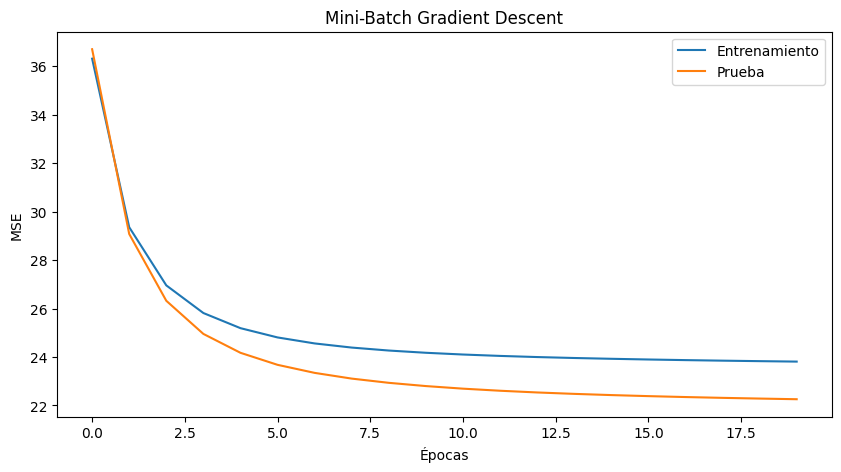

In [145]:
def mini_batch_gradient_descent(X_train, y_train, X_test, y_test,
                                lr=0.01, epochs=20, batch_size=32, schedule=True):
    n, m = X_train.shape

    # Agregar bias
    X_train = np.hstack((np.ones((n, 1)), X_train))
    X_test  = np.hstack((np.ones((X_test.shape[0], 1)), X_test))

    # Asegurar que y sean vectores columna
    y_train = y_train.reshape(-1, 1)
    y_test  = y_test.reshape(-1, 1)

    # Inicializar pesos
    W = np.zeros((m + 1, 1))

    train_errors, test_errors = [], []
    t = 0  # contador de updates

    for ep in range(epochs):
        # Permutar aleatoriamente
        permutation = np.random.permutation(n)
        X_train = X_train[permutation]
        y_train = y_train[permutation]

        # Recorrer en lotes
        for j in range(0, n, batch_size):
            x_batch = X_train[j:j+batch_size]
            y_batch = y_train[j:j+batch_size]

            prediction = x_batch @ W
            error = y_batch - prediction

            gradient = -(2 / len(x_batch)) * (x_batch.T @ error)
            lr_t = lr / np.sqrt(t+1) if schedule else lr
            W -= lr_t * gradient
            t += 1

        # calcular errores globales por época
        train_mse = np.mean((y_train - (X_train @ W))**2)
        test_mse  = np.mean((y_test  - (X_test  @ W))**2)

        train_errors.append(train_mse)
        test_errors.append(test_mse)

        print(f"Época {ep+1}/{epochs} - Train MSE: {train_mse:.4f} - Test MSE: {test_mse:.4f}")

    # gráfico
    plt.figure(figsize=(10, 5))
    plt.plot(train_errors, label='Entrenamiento')
    plt.plot(test_errors, label='Prueba')
    plt.xlabel('Épocas')
    plt.ylabel('MSE')
    plt.legend()
    plt.title('Mini-Batch Gradient Descent')
    plt.show()

    return W


W_mini = mini_batch_gradient_descent(
    X_train_scaled, np.array(y_train),
    X_test_scaled,  np.array(y_test),
    lr=0.01, epochs=20, batch_size=256
)



REGULARIZACIÓN


LASSO

In [149]:
cols_final = num_cols + cat_cols
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=cols_final, index=X_train.index)
X_test_scaled_df  = pd.DataFrame(X_test_scaled, columns=cols_final, index=X_test.index)
X_train_scaled_df

,distance_km,passenger_count,is_holiday,is_workday,mañana,tarde,noche,uber_comun,uber_grande
35048,0.881180,-0.523725,0.0,0.0,0.0,1.0,0.0,1.0,0.0
192704,1.063780,-0.523725,0.0,1.0,0.0,0.0,1.0,1.0,0.0
8207,1.775933,-0.523725,0.0,1.0,0.0,1.0,0.0,1.0,0.0
197511,-0.406149,-0.523725,0.0,0.0,1.0,0.0,0.0,1.0,0.0
156994,-0.106870,1.006061,0.0,0.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...
122490,-0.450429,-0.523725,0.0,1.0,1.0,0.0,0.0,1.0,0.0
105924,-0.717077,1.006061,0.0,0.0,0.0,1.0,0.0,1.0,0.0
134787,0.235838,-0.523725,0.0,1.0,1.0,0.0,0.0,1.0,0.0
150041,0.370107,1.006061,0.0,0.0,0.0,0.0,0.0,1.0,0.0


0.7437232706145945


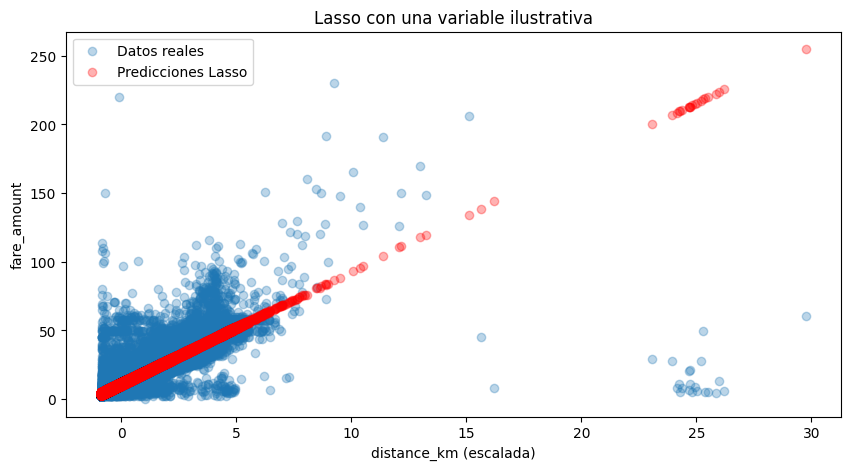

In [151]:
lasso = Lasso(alpha=0.001)
lasso.fit(X_train_scaled, y_train)
print(lasso.score(X_train_scaled,np.array(y_train).reshape(-1,1)))
##Graficar los coeficientes
# Supongamos que la columna 5 es 'distance_km'
i = 0

plt.figure(figsize=(10,5))
plt.scatter(X_train_scaled[:, i], y_train, alpha=0.3, label='Datos reales')
plt.scatter(X_train_scaled[:, i], lasso.predict(X_train_scaled), 
            color='red', alpha=0.3, label='Predicciones Lasso')
plt.xlabel("distance_km (escalada)")
plt.ylabel("fare_amount")
plt.title("Lasso con una variable ilustrativa")
plt.legend()
plt.show()


R² en train: 0.7431074801186959


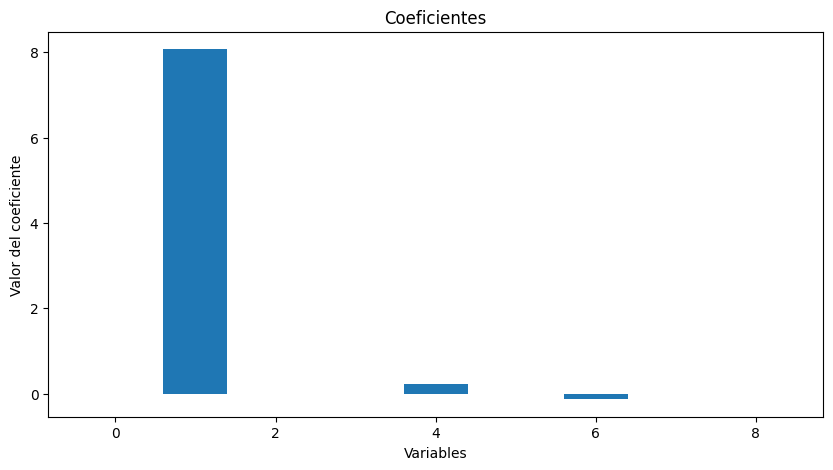

In [124]:

lasso = Lasso(alpha=0.1, max_iter=10000)
lasso.fit(X_train_scaled, y_train)

print("R² en train:", lasso.score(X_train_scaled, y_train))

# Graficar coeficientes con nombres de variables
plt.figure(figsize=(10, 5))
plt.bar(range(len(lasso.coef_)), lasso.coef_)
plt.xlabel("Variables")
plt.ylabel("Valor del coeficiente")
plt.title("Coeficientes")
plt.show()


In [154]:
modelo = LassoCV(
            alphas          = np.logspace(-10, 3, 200),
            cv              = 10
         )

_ = modelo.fit(X_train_scaled, y_train.to_numpy().ravel())

alphas = modelo.alphas_
coefs = []

for alpha in alphas:
    modelo_temp = Lasso(alpha=alpha, fit_intercept=False)
    modelo_temp.fit(X_train_scaled, y_train.to_numpy().ravel())
    coefs.append(modelo_temp.coef_.flatten())

fig, ax = plt.subplots(figsize=(12, 8.84))
ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_ylim([-0.5,None])
ax.set_xlabel('alpha')
ax.set_ylabel('parámetros')
ax.set_title('Coeficientes del modelo en función de la regularización');

KeyboardInterrupt: 

0.7437364442778991


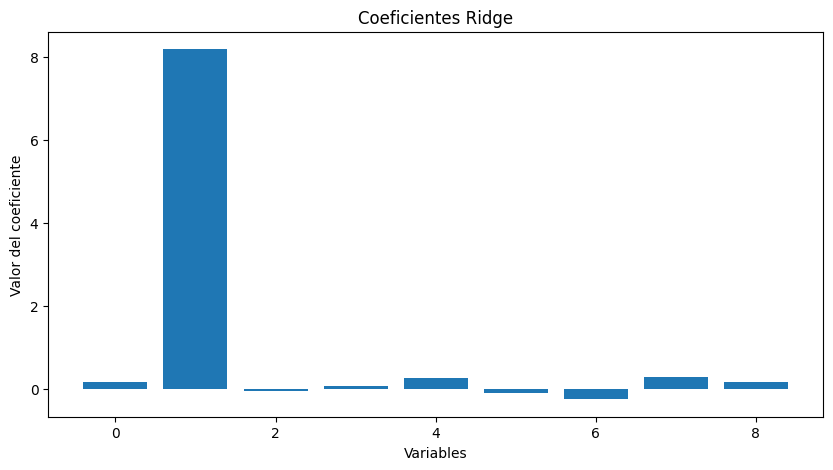

In [117]:
##RIDGE
ridge = Ridge(alpha=0.001)
ridge.fit(X_train_scaled, y_train)  
print(ridge.score(X_train_scaled,np.array(y_train).reshape(-1,1)))
# Graficar coeficientes con nombres de variables
plt.figure(figsize=(10, 5))
plt.bar(range(len(ridge.coef_)), ridge.coef_)
plt.xlabel("Variables")
plt.ylabel("Valor del coeficiente")
plt.title("Coeficientes Ridge")
plt.show()
 

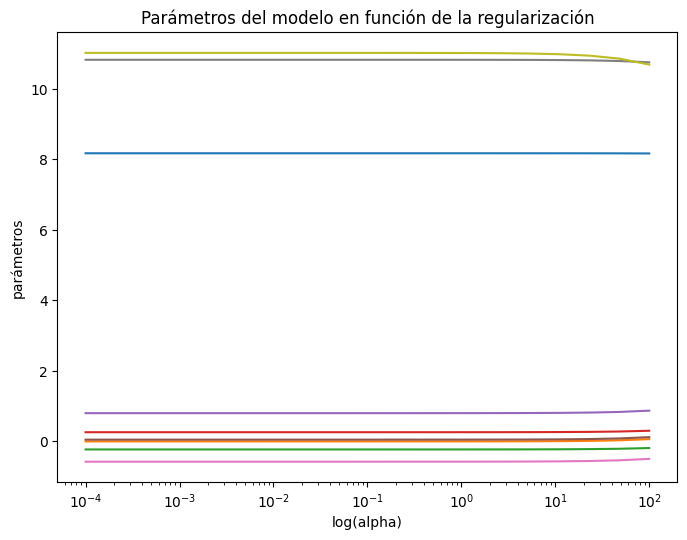

In [159]:
# Creación y entrenamiento del modelo. Scikit-Learn usa Cross Validation para encontrar el valor óptimo de alpha
# (lambda en los desarrollos de teoría). Puede ser problemático con series de tiempo.

modelo = RidgeCV(
        alphas          = np.logspace(-4, 2, 20),
        store_cv_results = True
    )

_ = modelo.fit(X = X_train_scaled, y = y_train)

alphas = modelo.alphas
coefs = []

for alpha in alphas:
    modelo_temp = Ridge(alpha=alpha, fit_intercept=False)
    modelo_temp.fit(X_train_scaled, y_train)
    coefs.append(modelo_temp.coef_.flatten())

fig, ax = plt.subplots(figsize=(8, 5.84))
ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_xlabel('log(alpha)')
ax.set_ylabel('parámetros')
ax.set_title('Parámetros del modelo en función de la regularización');
plt.axis('tight')
plt.show()

0.7437357921554781


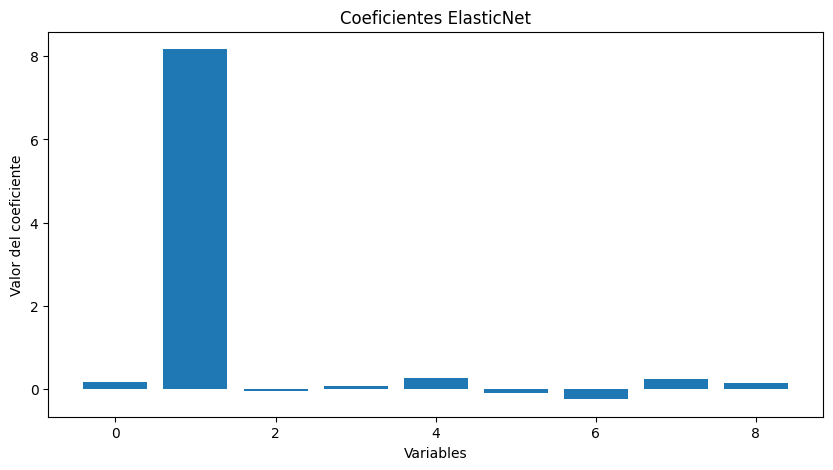

In [118]:
##ElasticNet
elastic_net = ElasticNet(alpha=0.001, l1_ratio=0.5, max_iter=10000)
elastic_net.fit(X_train_scaled, y_train)    
print(elastic_net.score(X_train_scaled,np.array(y_train).reshape(-1,1)))
# Graficar coeficientes con nombres de variables
plt.figure(figsize=(10, 5))
plt.bar(range(len(elastic_net.coef_)), elastic_net.coef_)
plt.xlabel("Variables")
plt.ylabel("Valor del coeficiente")
plt.title("Coeficientes ElasticNet")
plt.show()

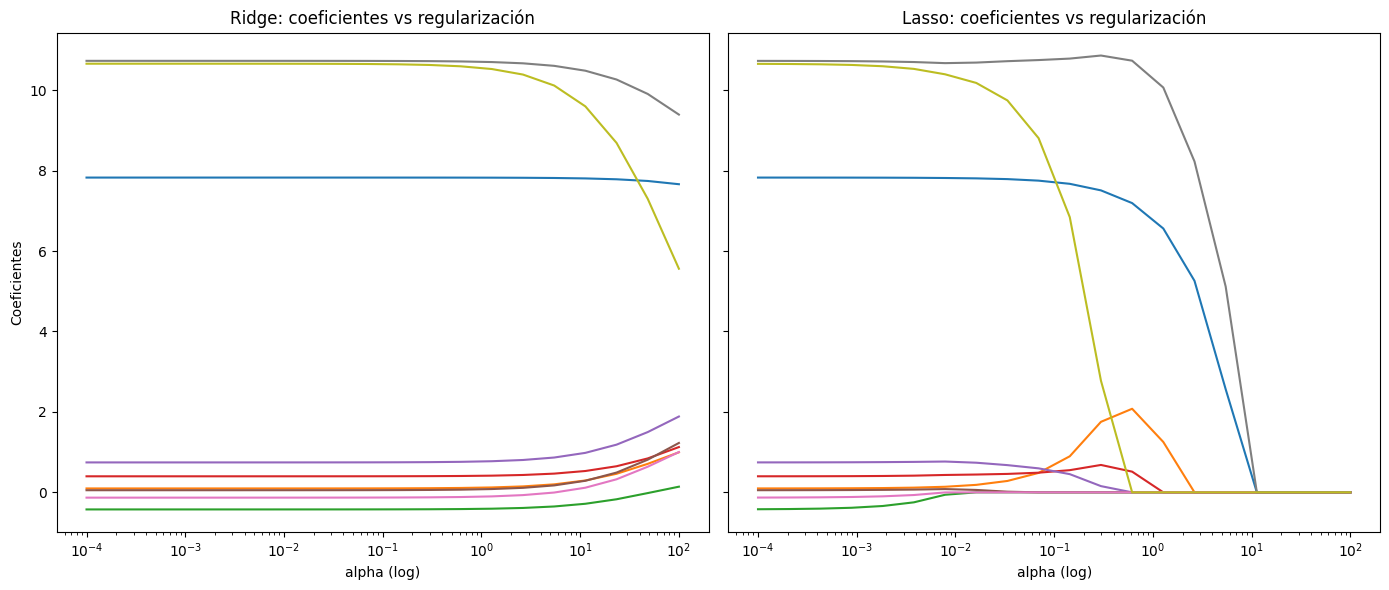

In [158]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge, Lasso
from sklearn.utils import resample

# Submuestreo para acelerar (ejemplo: 5000 filas aleatorias)
X_small, y_small = resample(X_train_scaled, y_train.to_numpy().ravel(), 
                            n_samples=5000, random_state=42)

# Rango de alphas más chico
alphas = np.logspace(-4, 2, 20)

coefs_ridge, coefs_lasso = [], []

for a in alphas:
    ridge = Ridge(alpha=a, fit_intercept=False)
    ridge.fit(X_small, y_small)
    coefs_ridge.append(ridge.coef_)
    
    lasso = Lasso(alpha=a, fit_intercept=False, max_iter=2000)
    lasso.fit(X_small, y_small)
    coefs_lasso.append(lasso.coef_)

# --- Gráfico comparativo ---
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Ridge
axes[0].plot(alphas, coefs_ridge)
axes[0].set_xscale("log")
axes[0].set_xlabel("alpha (log)")
axes[0].set_ylabel("Coeficientes")
axes[0].set_title("Ridge: coeficientes vs regularización")

# Lasso
axes[1].plot(alphas, coefs_lasso)
axes[1].set_xscale("log")
axes[1].set_xlabel("alpha (log)")
axes[1].set_title("Lasso: coeficientes vs regularización")

plt.tight_layout()
plt.show()